# Analytics

#### Date: 2021/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: Povos e Comunidades Tradicionais

##### Semester: 2021/01
##### Professor: Hilmer Neri

##### Members:

- Caio Vinicius F. de Araujo
- Guilherme Mendes Pereira
- Julio Cesar Litwin Lima
- Lucas Gomes de Oliveira
- Lucas Gomes Silva
- Lucas Maciel Aguiar

### LIBRARIES

In [2]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [3]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [5]:
jsons = glob('../analytics-raw-data/*.json') # add the path here

In [6]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PCTs-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [7]:
base_component_df = create_base_component_df(jsons)

In [8]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
9,duplicated_lines_density,0.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
10,functions,9,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
11,security_rating,1.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
12,files,20,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
13,complexity,18,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
14,ncloc,359,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
15,coverage,83.1,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
16,reliability_rating,1.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
17,comment_lines_density,16.1,False,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
162,duplicated_lines_density,0.0,True,fga-eps-mds_2021_1-PCTs-DocumentsAPI-07-10-202...,DocumentsAPI,07-10-2021-07-31


#### Create dataframe per file

In [9]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [10]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df_ts = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'ts')
        file_component_df_ts['filename'] = os.path.basename(i)

        file_component_df_js = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')
        file_component_df_js['filename'] = os.path.basename(i)

        file_component_df_py = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'py')
        file_component_df_py['filename'] = os.path.basename(i)

        file_component_df_yaml = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'yaml')
        file_component_df_yaml['filename'] = os.path.basename(i)

        df = df.append(file_component_df_ts, ignore_index=True)
        df = df.append(file_component_df_js, ignore_index=True)
        df = df.append(file_component_df_py, ignore_index=True)
        df = df.append(file_component_df_yaml, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"PCTs-(.*?)-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [11]:
file_component_df = create_file_df(jsons)

In [12]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
5,documents/migrations/0001_initial.py,0,0,4.5,0.0,100.0,21,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
6,documents/migrations/0002_document_classificat...,0,0,7.7,0.0,100.0,12,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
7,documents/migrations/0003_auto_20211028_2212.py,0,0,3.0,0.0,100.0,32,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
8,pcts_documents/__init__.py,0,0,NaN,0.0,NaN,0,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
9,documents/__init__.py,0,0,NaN,0.0,NaN,0,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
10,documents/migrations/__init__.py,0,0,NaN,0.0,NaN,0,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
11,documents/tests/__init__.py,0,0,NaN,0.0,NaN,0,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
12,documents/admin.py,0,0,0.0,0.0,100.0,1,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
13,documents/apps.py,0,0,0.0,0.0,100.0,4,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35
14,pcts_documents/asgi.py,0,0,66.7,0.0,0.0,4,1.0,0,100.0,0,1.0,fga-eps-mds_2021_1-PCTs-DocumentsAPI-02-11-202...,DocumentsAPI,02-11-2021-23-35


#### Create dataframe per repository

In [13]:
scraper_df = file_component_df[file_component_df['repository'] == 'Scraper']
documentsapi_df = file_component_df[file_component_df['repository'] == 'DocumentsAPI']
mltraining_df = file_component_df[file_component_df['repository'] == 'MLTraining']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']

In [14]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0

        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0

        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [15]:
def m1(df):
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    return density_non_complex_files

##### COMMENTS

In [16]:
def m2(df):
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    return density_comment_files

##### DUPLICATIONS

In [17]:
def m3(df):
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [18]:
def m4(df):

    passed_tests = df['test_success_density'].astype(float).median() / 100

    return passed_tests

##### Fast test builds

In [19]:
def m5(df):

    count_tests = sum(df['tests'].astype(float))
    if count_tests or count_tests == 0:
        density_fast_test_builds = 0
        return 0
    density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / count_tests

    return density_fast_test_builds if not np.isnan(density_fast_test_builds) else 0

##### Test coverage

In [20]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [21]:
def create_metrics_df(df):

    version_vec = df['version'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    metrics_df = pd.DataFrame()

    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list,
                               'version': version_list,
                               'ncloc': ncloc_list})

    return metrics_df

In [22]:
scraper_metrics = create_metrics_df(scraper_df)
documentsapi_metrics = create_metrics_df(documentsapi_df)
mltraining_metrics = create_metrics_df(mltraining_df)
frontend_metrics = create_metrics_df(frontend_df)

### Data visualization

- You must do this for each of your repositories

### Scraper

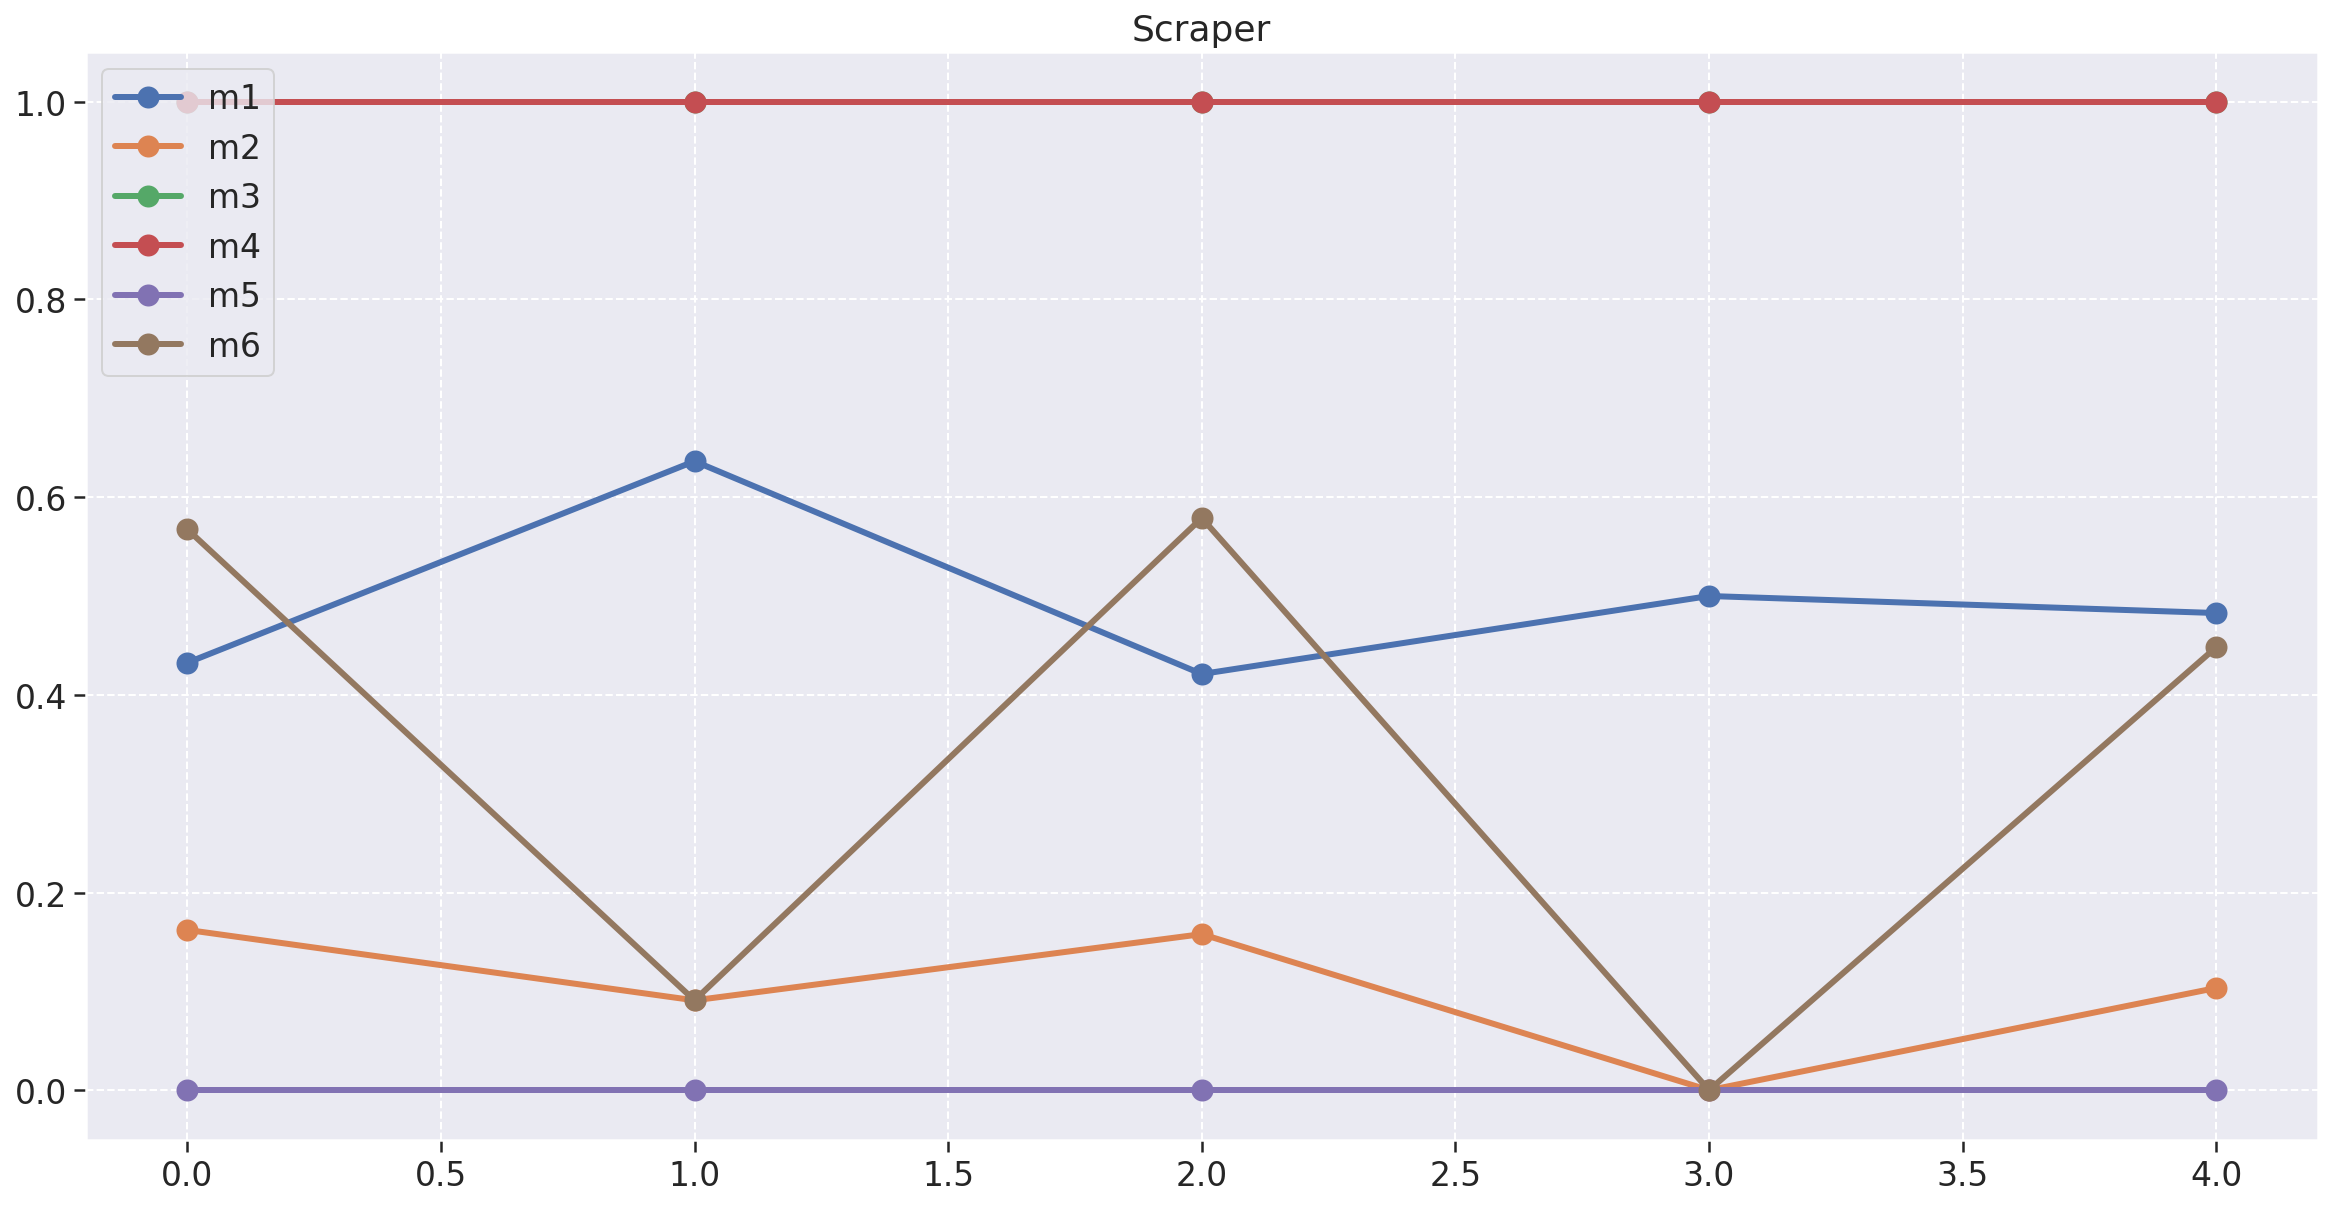

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper')
plt.plot(scraper_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(scraper_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(scraper_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(scraper_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(scraper_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(scraper_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

### Documents API

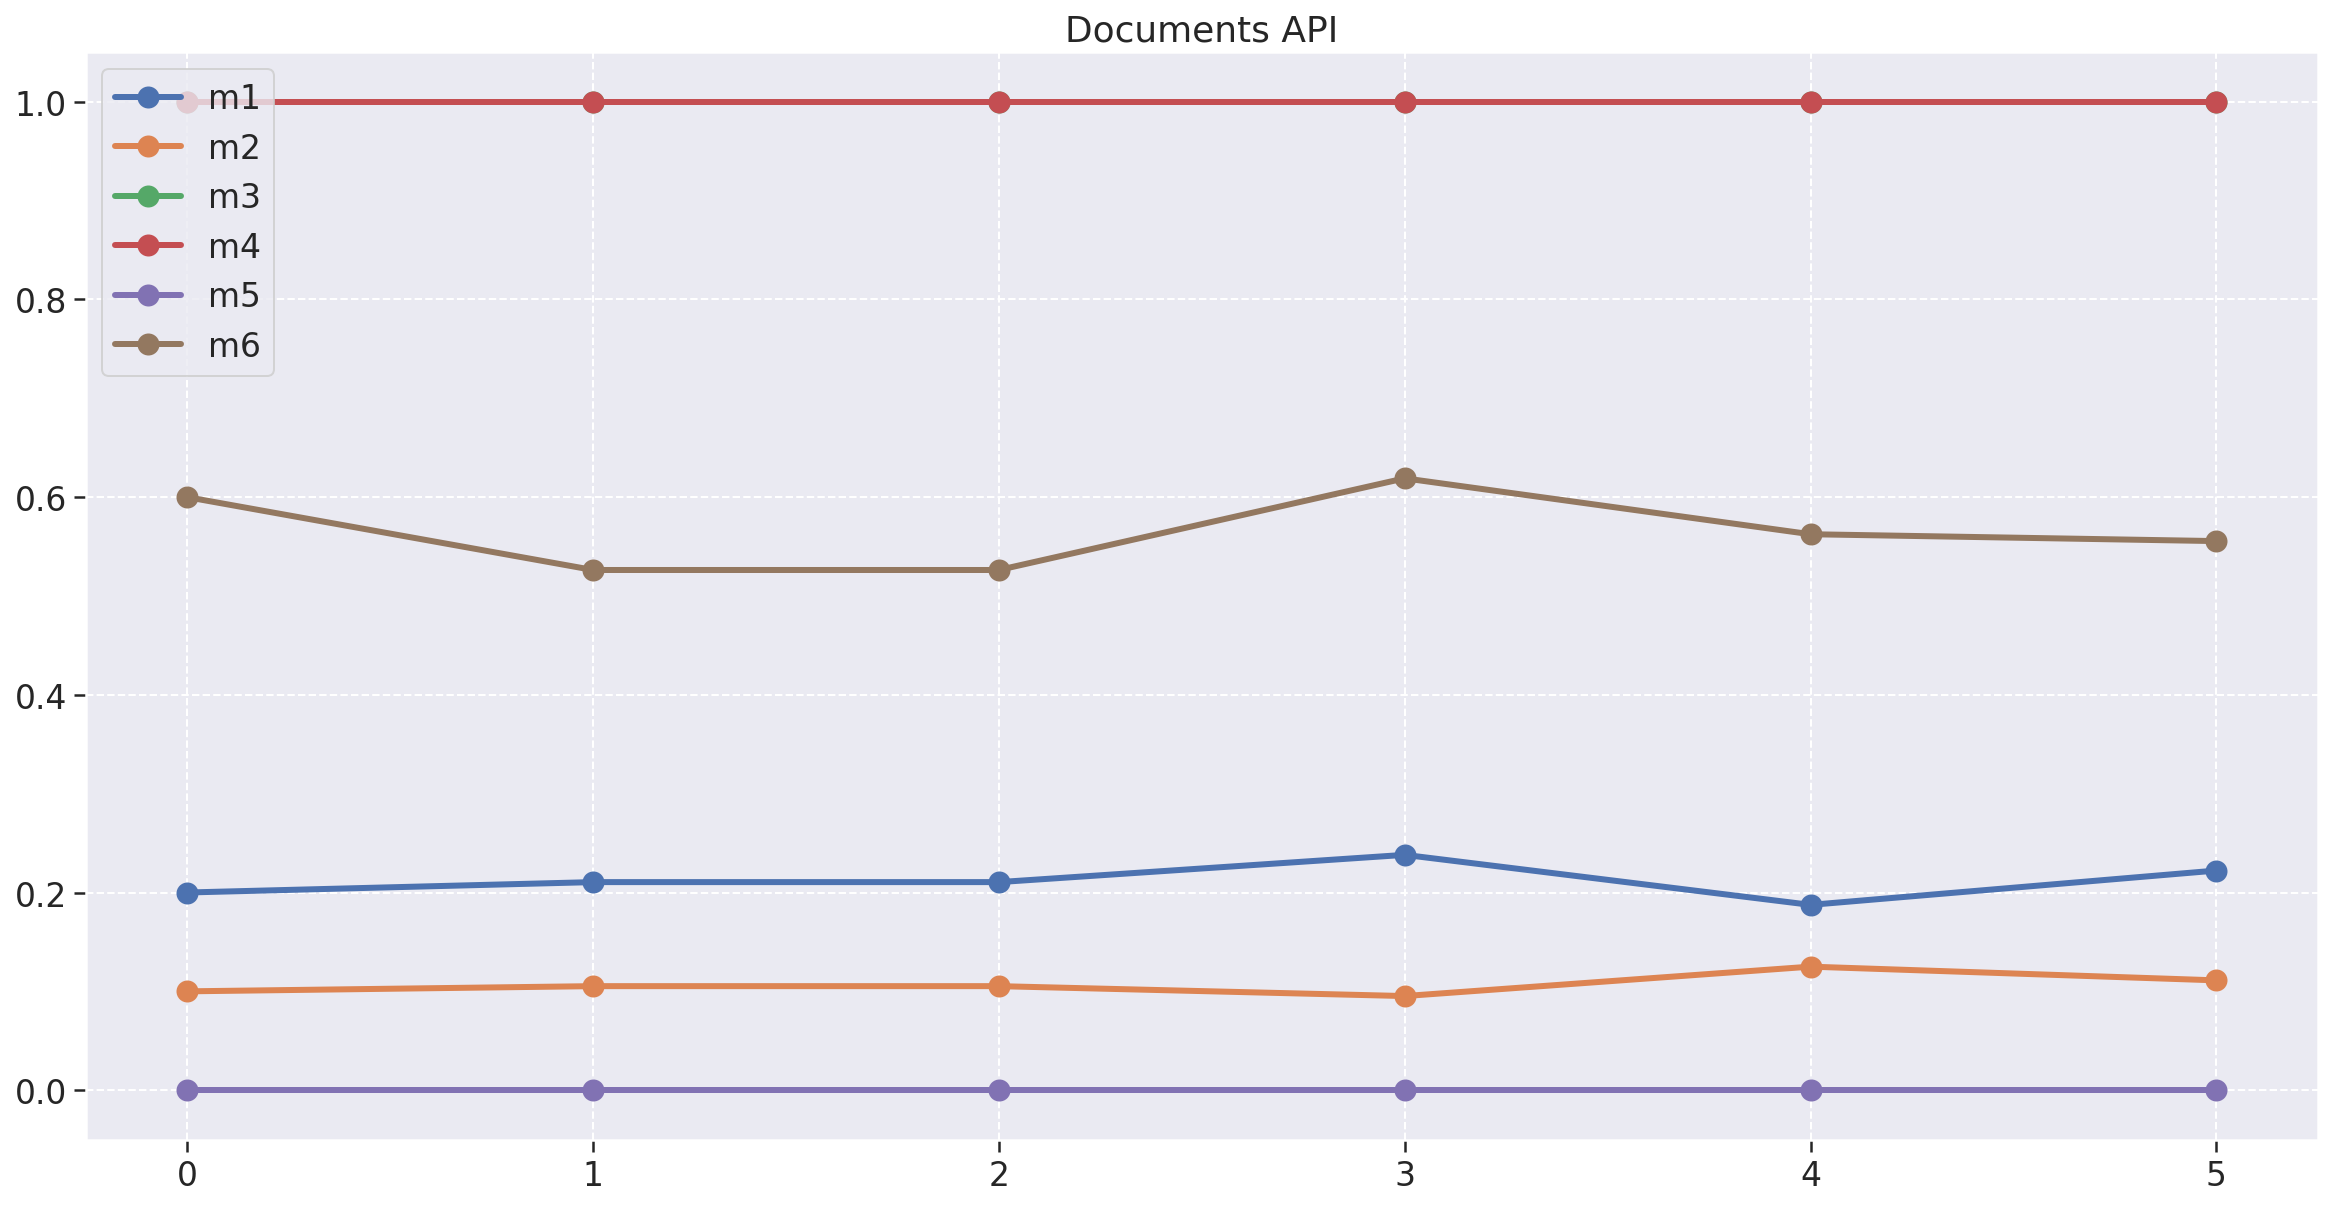

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.title('Documents API')
plt.plot(documentsapi_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(documentsapi_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(documentsapi_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(documentsapi_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(documentsapi_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(documentsapi_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

### ML Training

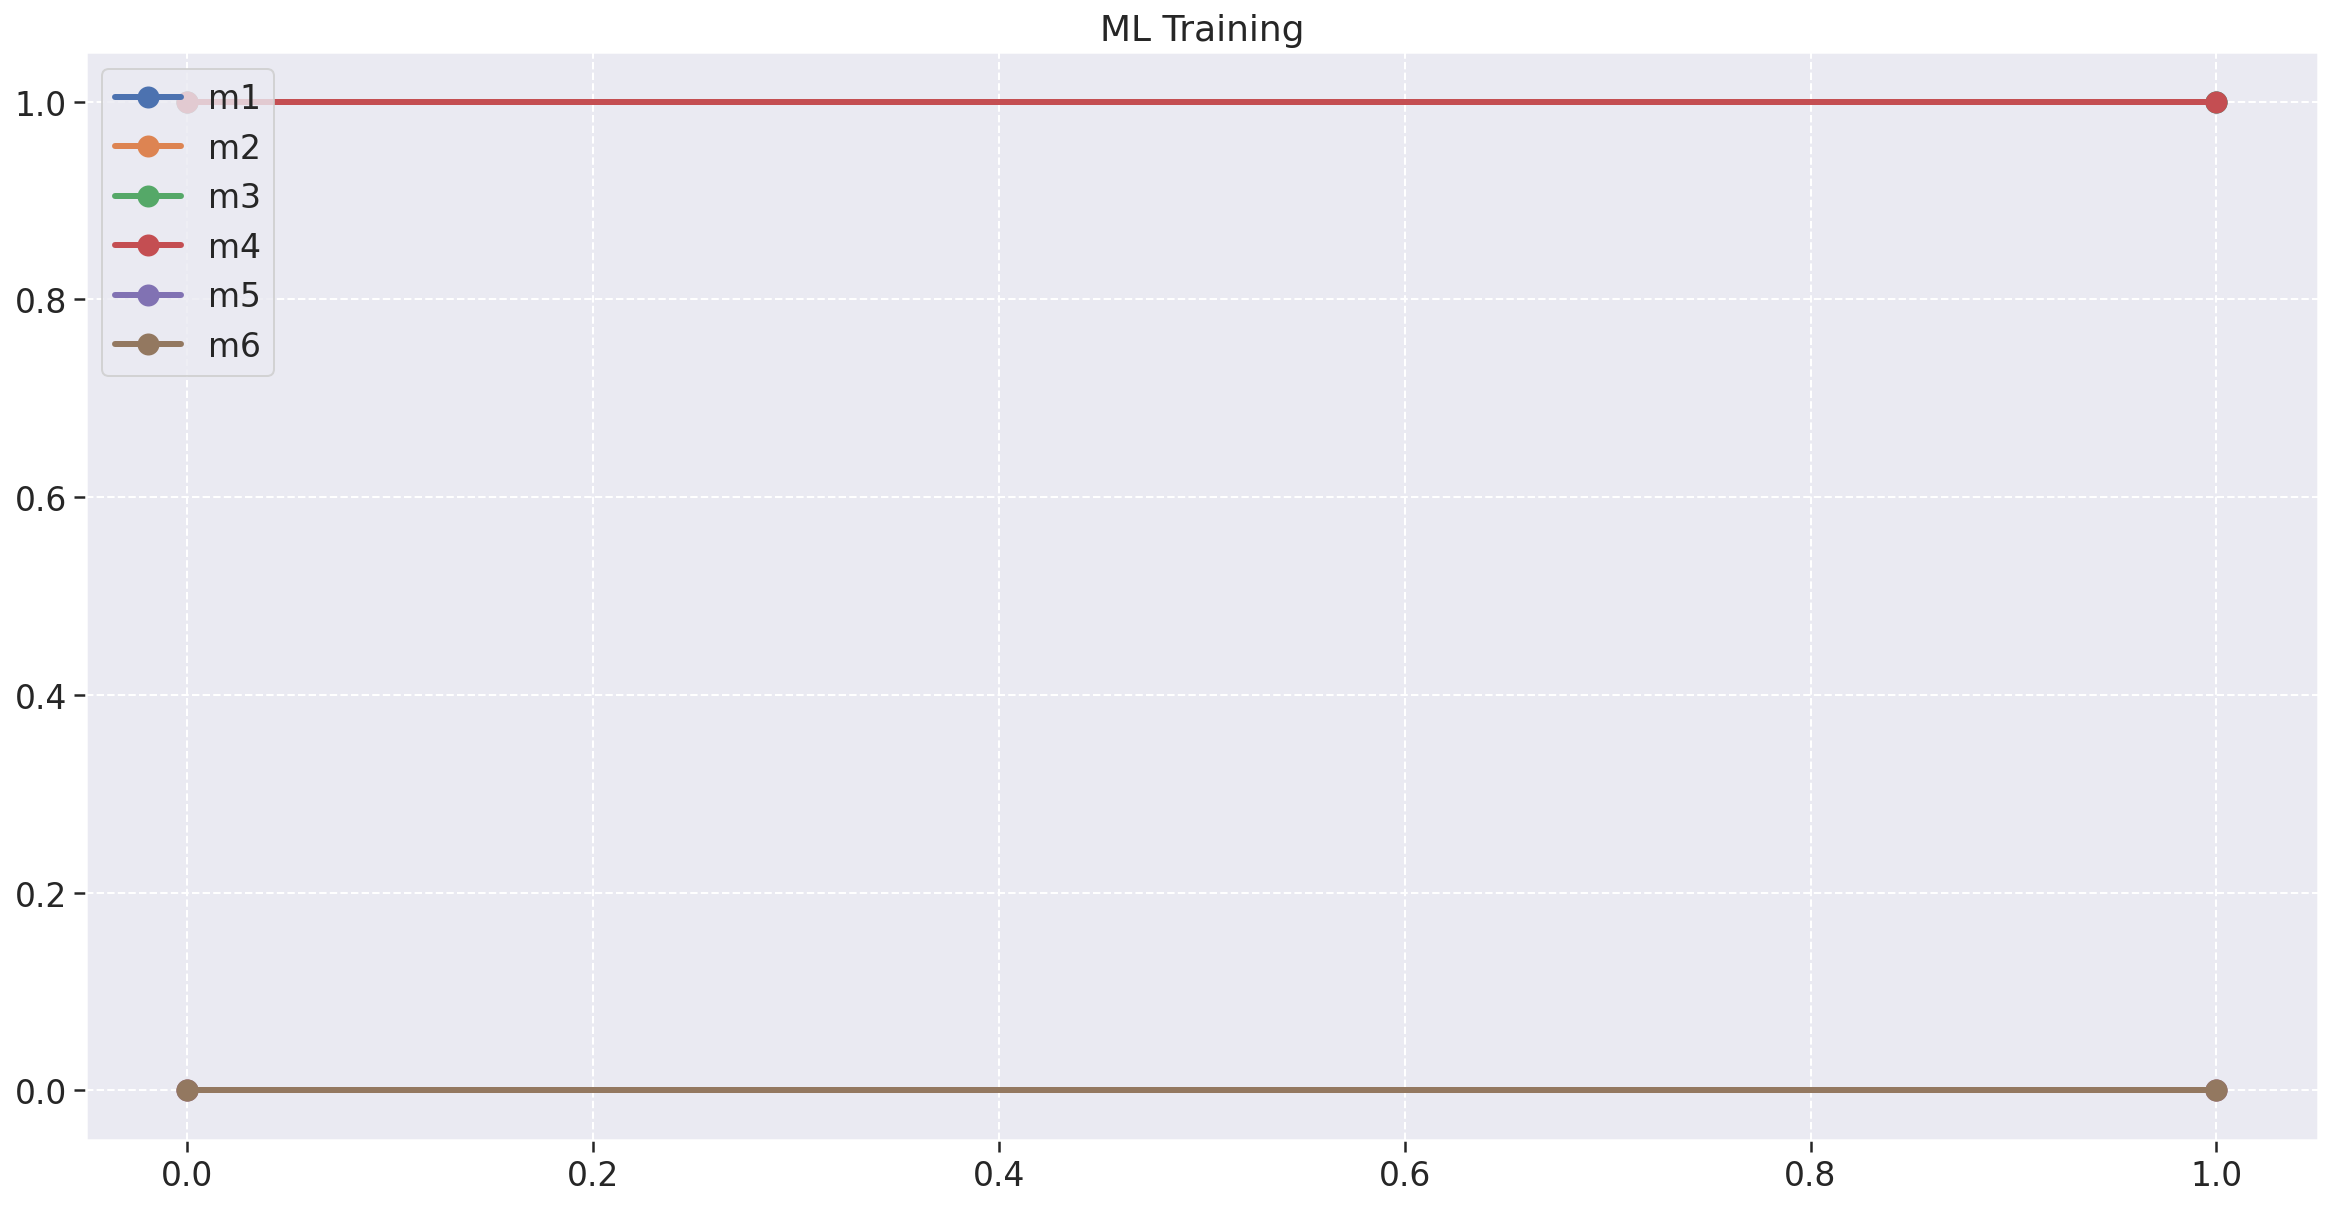

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training')
plt.plot(mltraining_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(mltraining_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(mltraining_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(mltraining_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(mltraining_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(mltraining_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend(loc='upper left')

### Front End

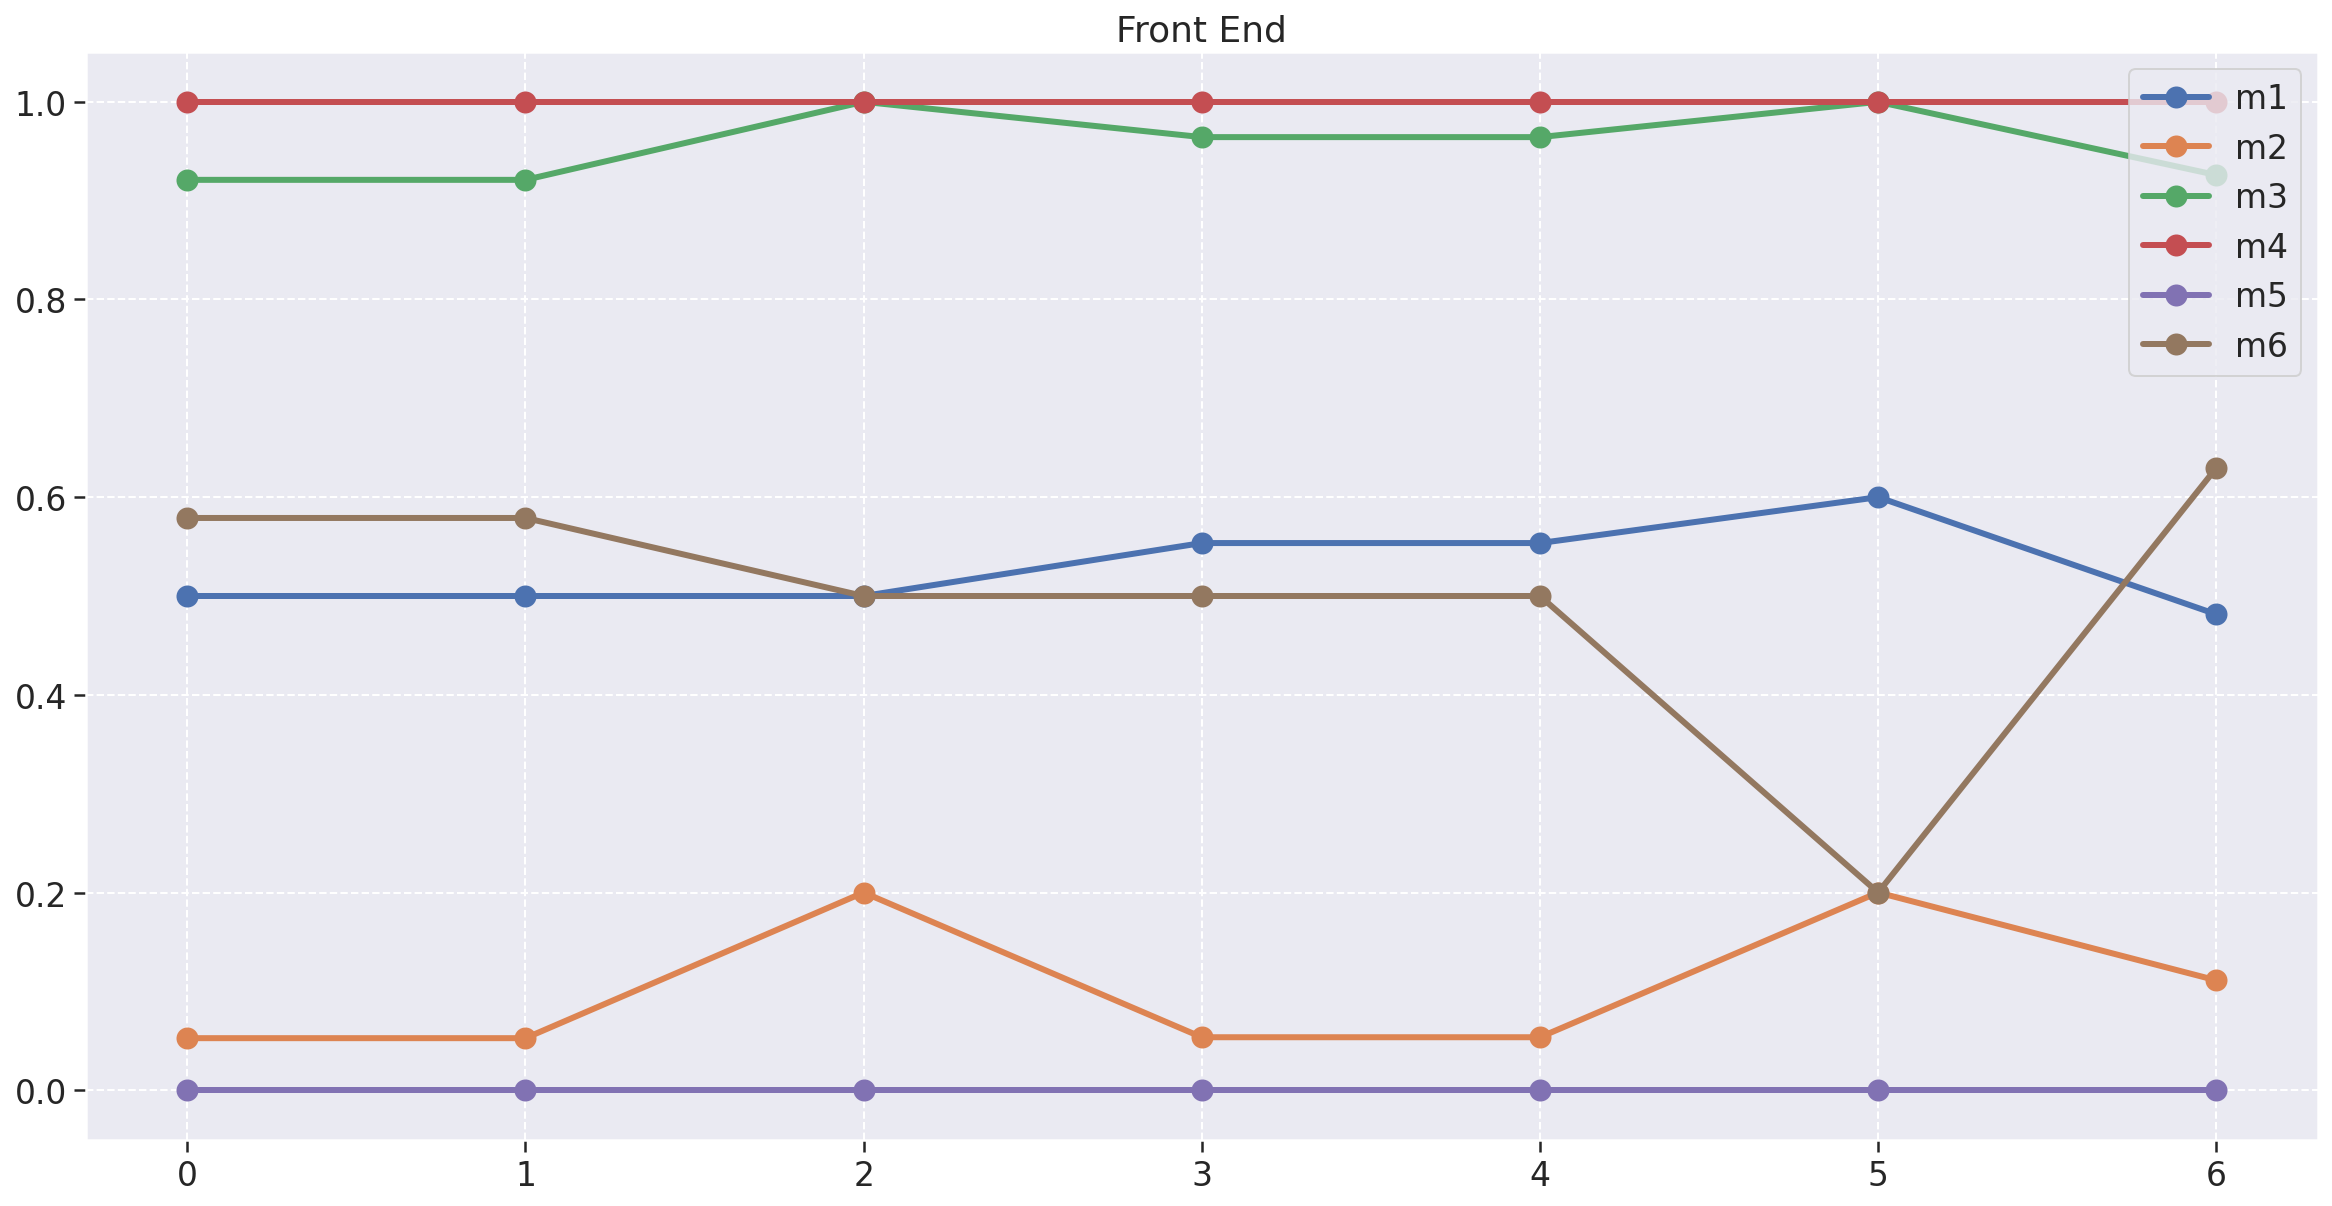

In [26]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End')
plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10, label='m1')
plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10, label='m2')
plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10, label='m3')
plt.plot(frontend_metrics['m4'], linewidth=3, marker='o', markersize=10, label='m4')
plt.plot(frontend_metrics['m5'], linewidth=3, marker='o', markersize=10, label='m5')
plt.plot(frontend_metrics['m6'], linewidth=3, marker='o', markersize=10, label='m6')
plt.legend()

### Sub characteristic aggregation

- You must do this for each of your repositories

In [27]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.15
pm5 = 0.15
pm6 = 0.7

scraper_metrics['code_quality'] = ((scraper_metrics['m1']*pm1) + (scraper_metrics['m2']*pm2) + (scraper_metrics['m3']*pm3)) * psc1
documentsapi_metrics['code_quality'] = ((documentsapi_metrics['m1']*pm1) + (documentsapi_metrics['m2']*pm2) + (documentsapi_metrics['m3']*pm3)) * psc1
mltraining_metrics['code_quality'] = ((mltraining_metrics['m1']*pm1) + (mltraining_metrics['m2']*pm2) + (mltraining_metrics['m3']*pm3)) * psc1
frontend_metrics['code_quality'] = ((frontend_metrics['m1']*pm1) + (frontend_metrics['m2']*pm2) + (frontend_metrics['m3']*pm3)) * psc1

scraper_metrics['testing_status'] = ((scraper_metrics['m4']*pm4) + (scraper_metrics['m5']*pm5) + (scraper_metrics['m6']*pm6)) * psc2
documentsapi_metrics['testing_status'] = ((documentsapi_metrics['m4']*pm4) + (documentsapi_metrics['m5']*pm5) + (documentsapi_metrics['m6']*pm6)) * psc2
mltraining_metrics['testing_status'] = ((mltraining_metrics['m4']*pm4) + (mltraining_metrics['m5']*pm5) + (mltraining_metrics['m6']*pm6)) * psc2
frontend_metrics['testing_status'] = ((frontend_metrics['m4']*pm4) + (frontend_metrics['m5']*pm5) + (frontend_metrics['m6']*pm6)) * psc2

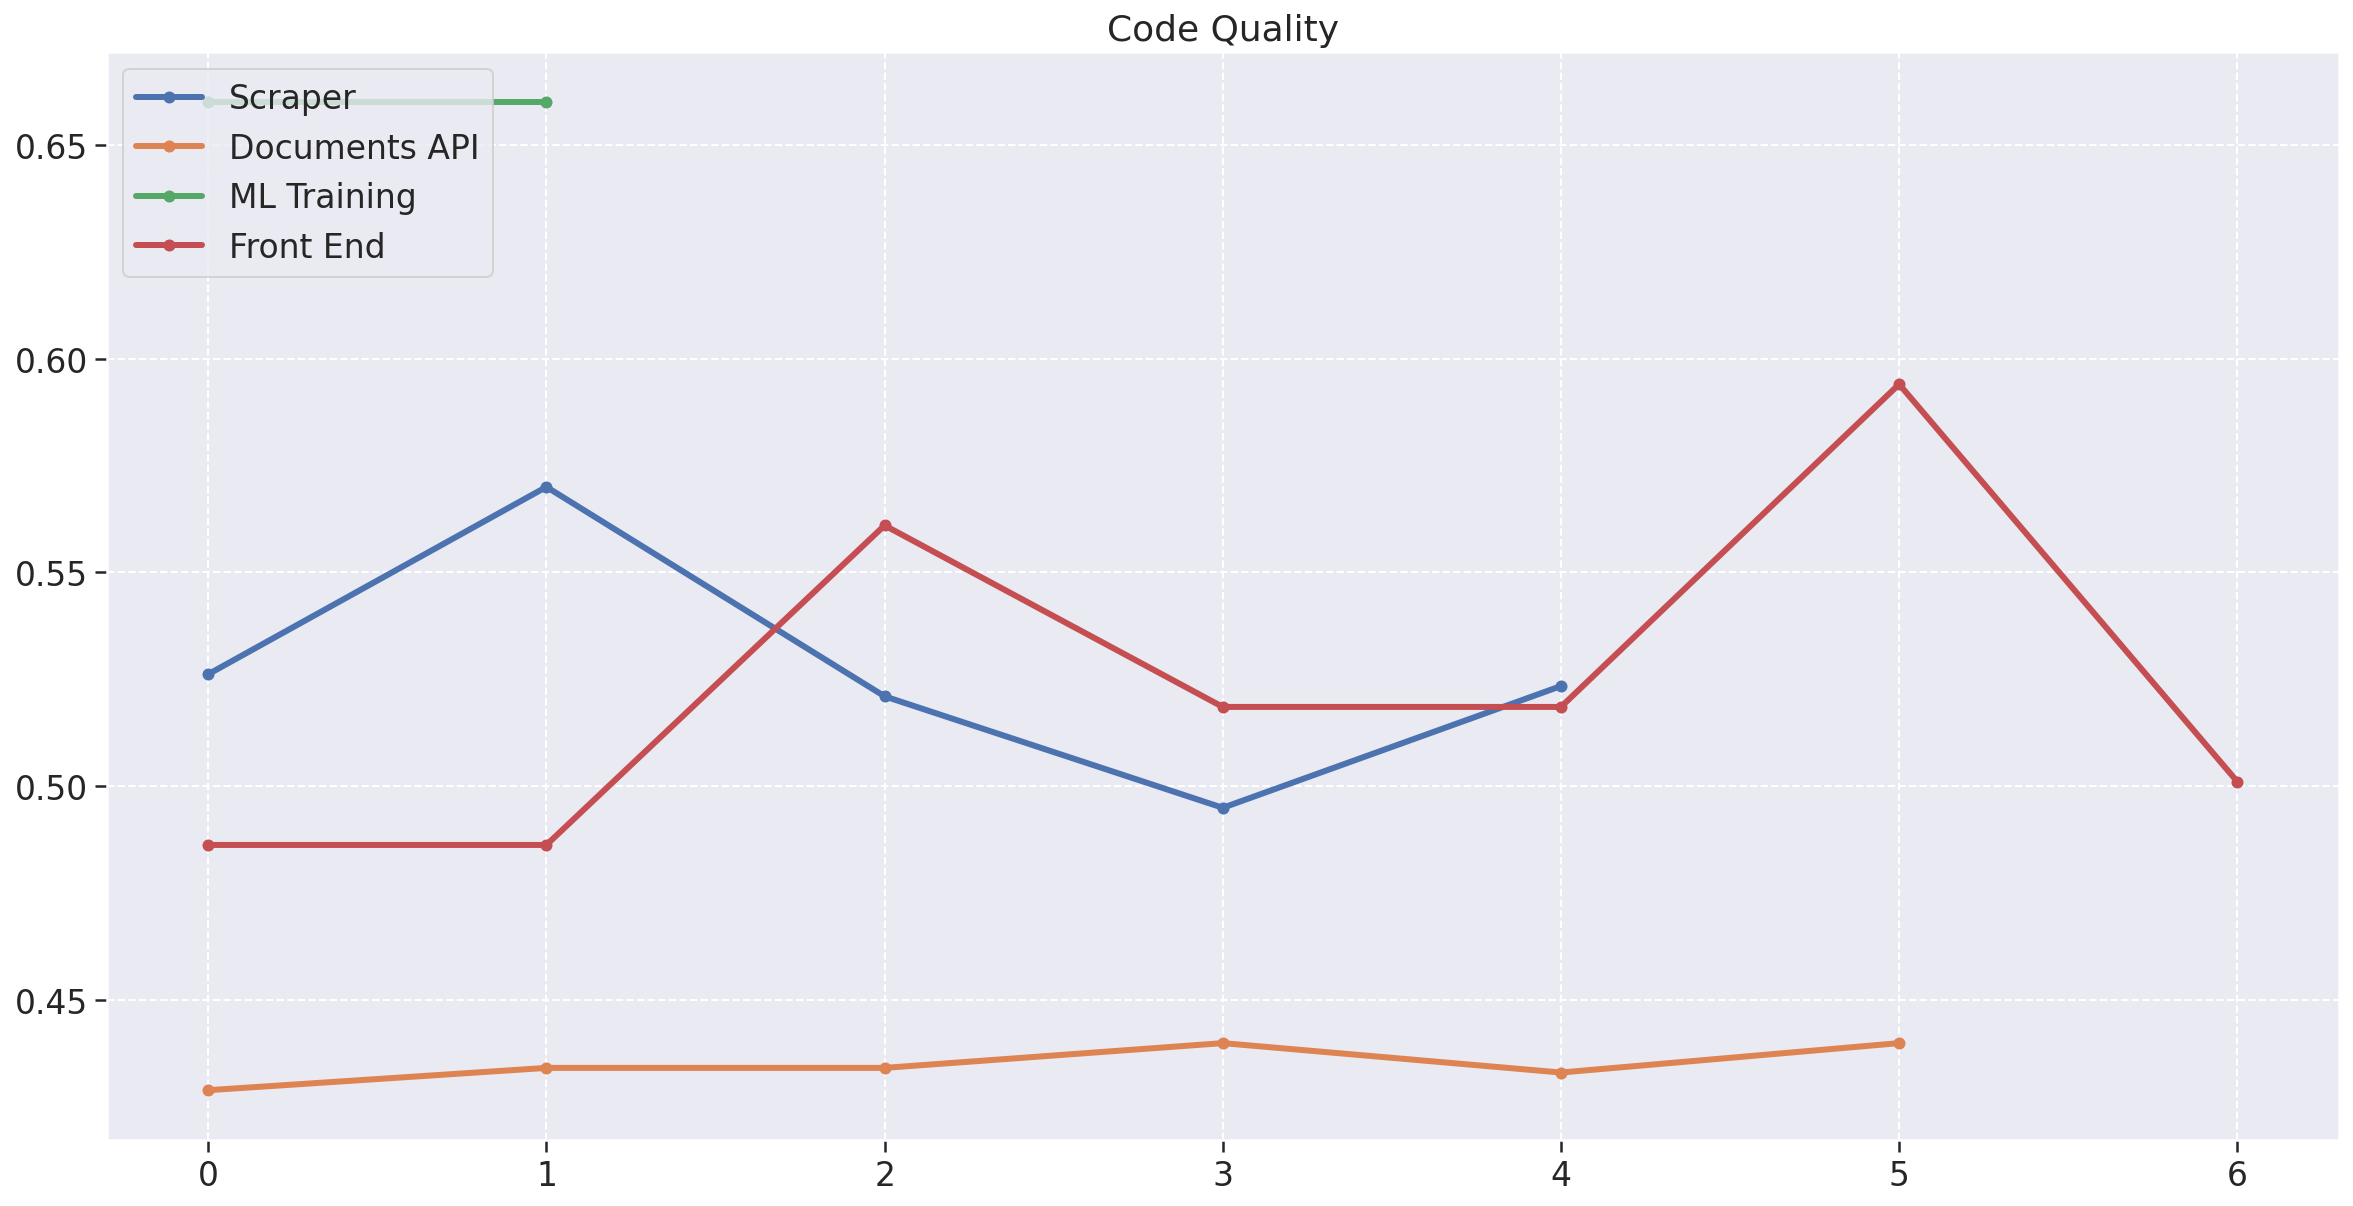

In [28]:
fig = plt.figure(figsize=(20, 10))


plt.title('Code Quality')
plt.plot(scraper_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Scraper')
plt.plot(documentsapi_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Documents API')
plt.plot(mltraining_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='ML Training')
plt.plot(frontend_metrics['code_quality'], linewidth=3, marker='o', markersize=5, label='Front End')

plt.legend(loc='upper left')

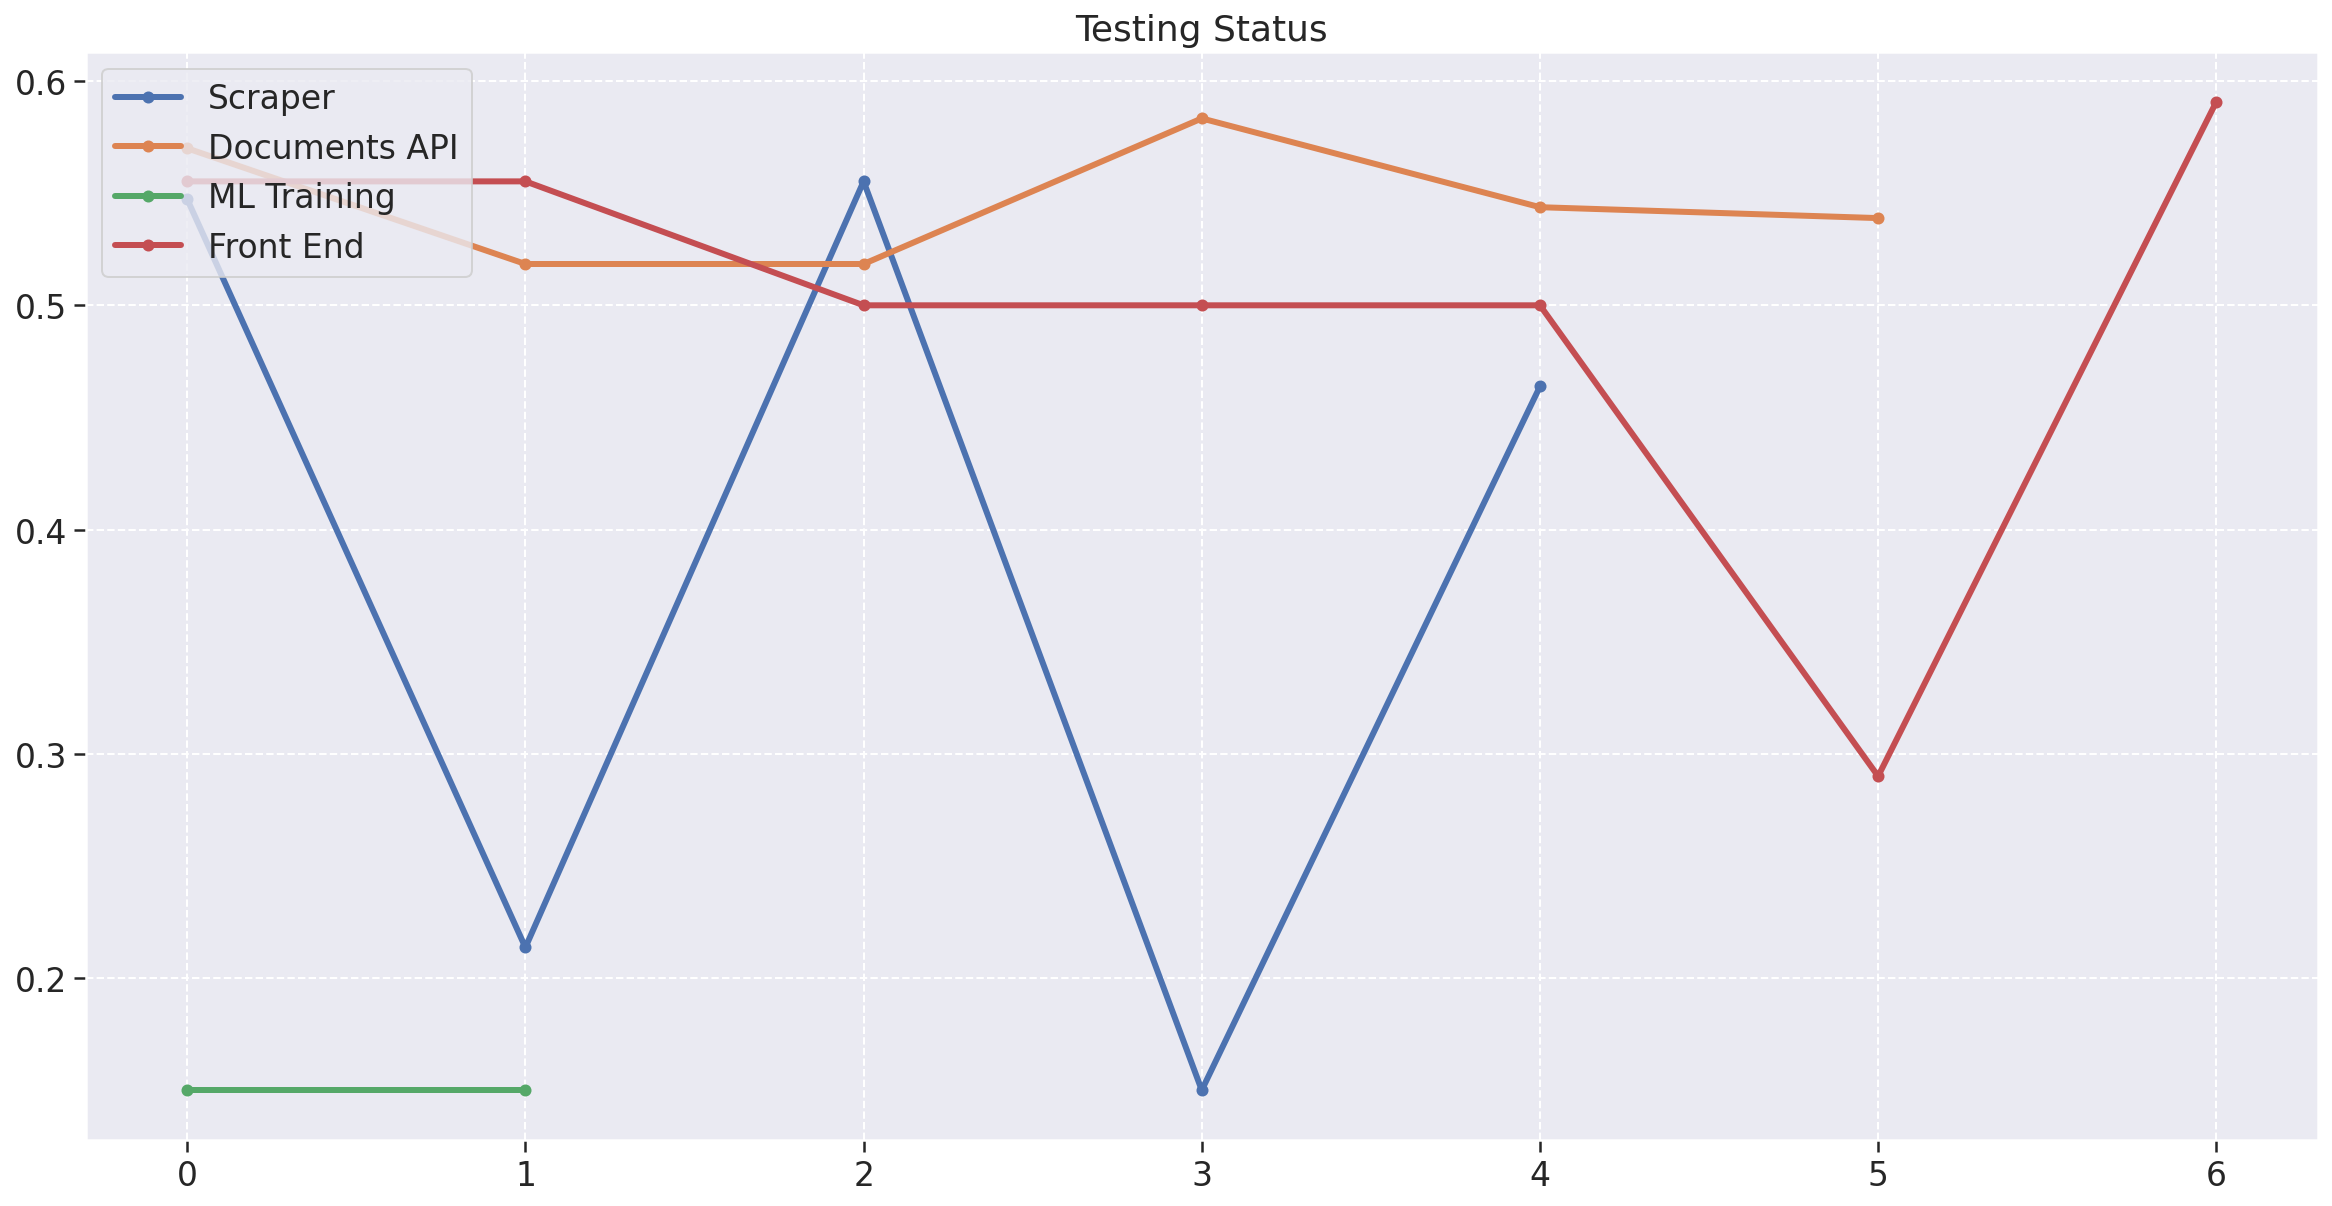

In [29]:
fig = plt.figure(figsize=(20, 10))

plt.title('Testing Status')
plt.plot(scraper_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Scraper')
plt.plot(documentsapi_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Documents API')
plt.plot(mltraining_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='ML Training')
plt.plot(frontend_metrics['testing_status'], linewidth=3, marker='o', markersize=5, label='Front End')

plt.legend(loc='upper left')

## Descriptive Statistics

### Scraper

In [30]:
scraper_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,0.432432,0.162162,1.0,1.0,0,0.567568,Scraper,02-11-2021-23-26,1348,0.526216,0.547297
1,0.636364,0.090909,1.0,1.0,0,0.090909,Scraper,07-10-2021-07-43,484,0.570000,0.213636
2,0.421053,0.157895,1.0,1.0,0,0.578947,Scraper,07-11-2021-19-54,1337,0.521053,0.555263
3,0.500000,0.000000,1.0,1.0,0,0.000000,Scraper,15-09-2021-00-01,138,0.495000,0.150000
4,0.482759,0.103448,1.0,1.0,0,0.448276,Scraper,21-10-2021-15-11,1058,0.523448,0.463793


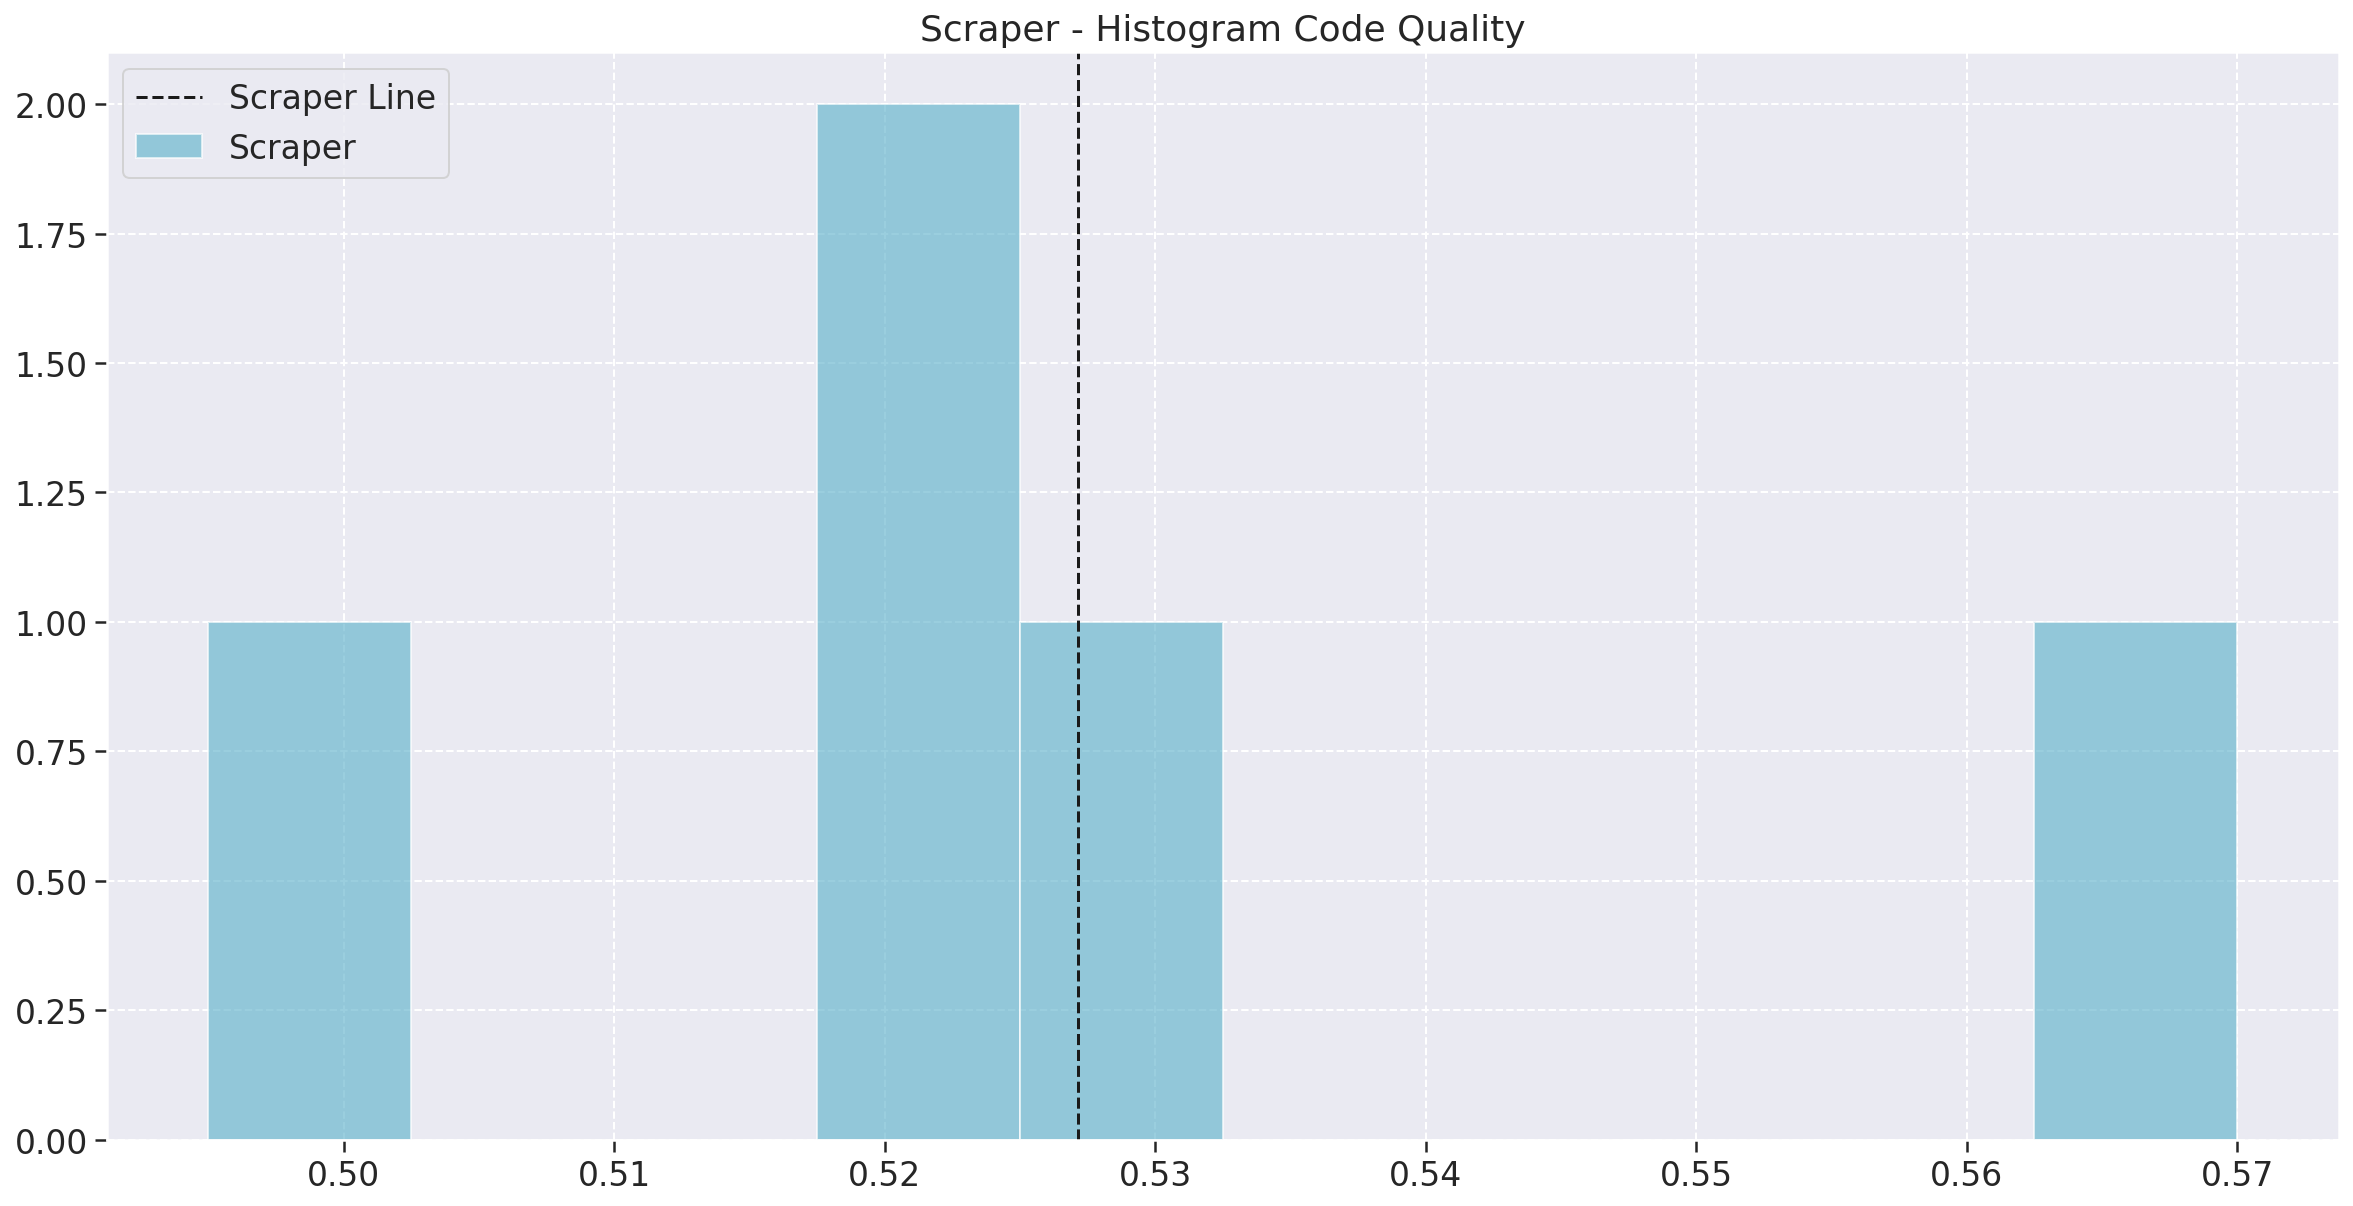

In [31]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Histogram Code Quality')
plt.hist(scraper_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='Scraper')
plt.axvline(scraper_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='Scraper Line')

plt.legend(loc='upper left')

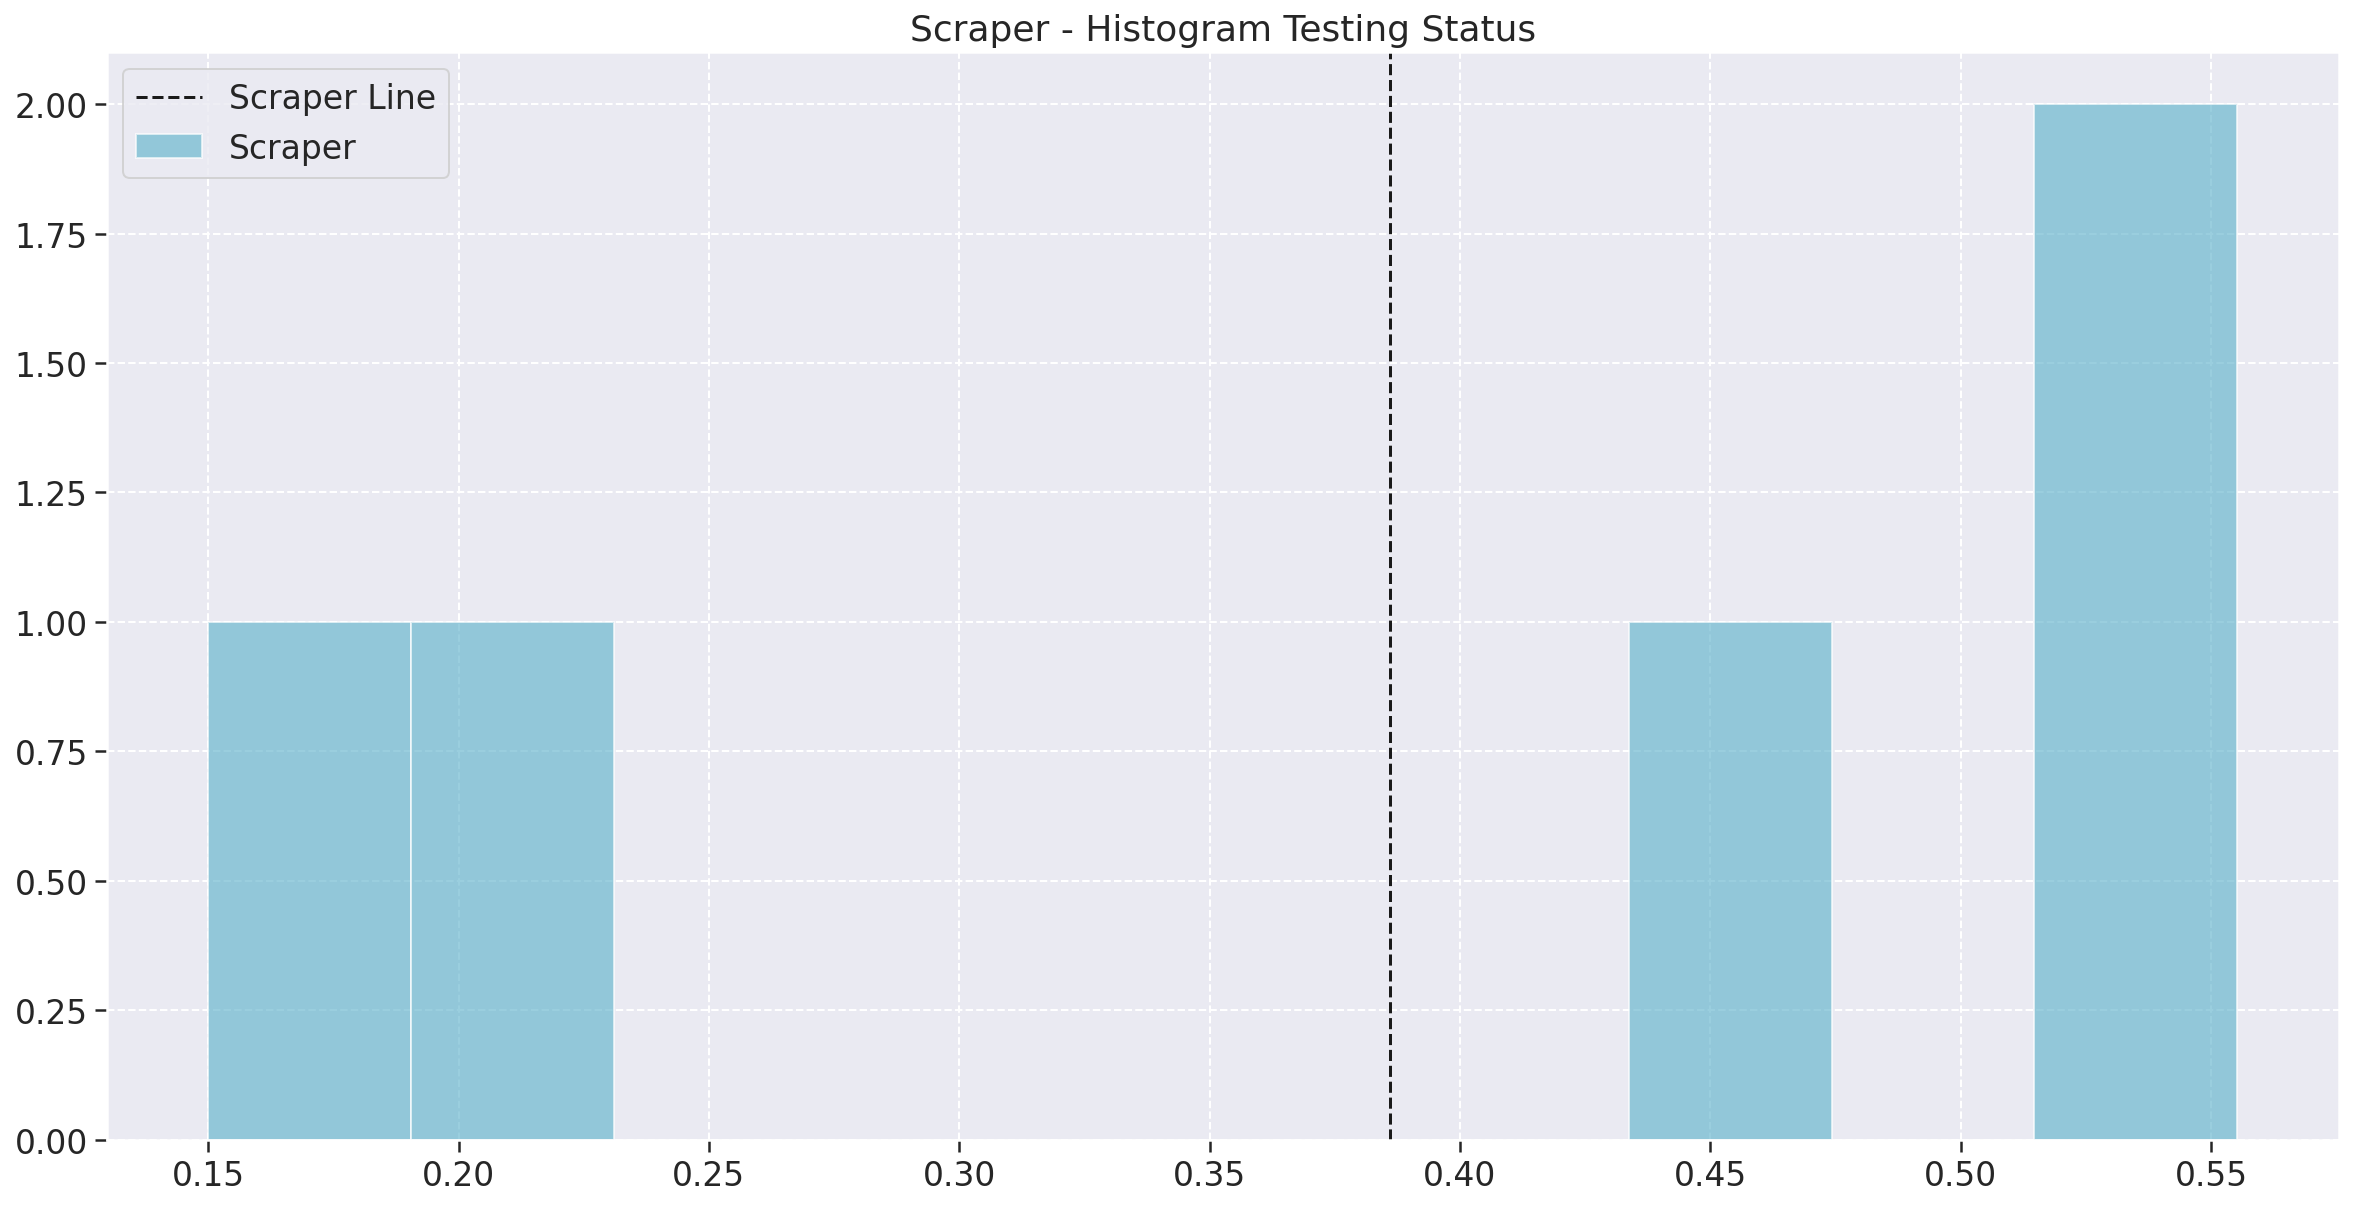

In [32]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Histogram Testing Status')
plt.hist(scraper_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='Scraper')
plt.axvline(scraper_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='Scraper Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ecd3c4b20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ecd3d1280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ecd3c4790>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ecd3d19a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ecd3d1d30>],
 'means': []}

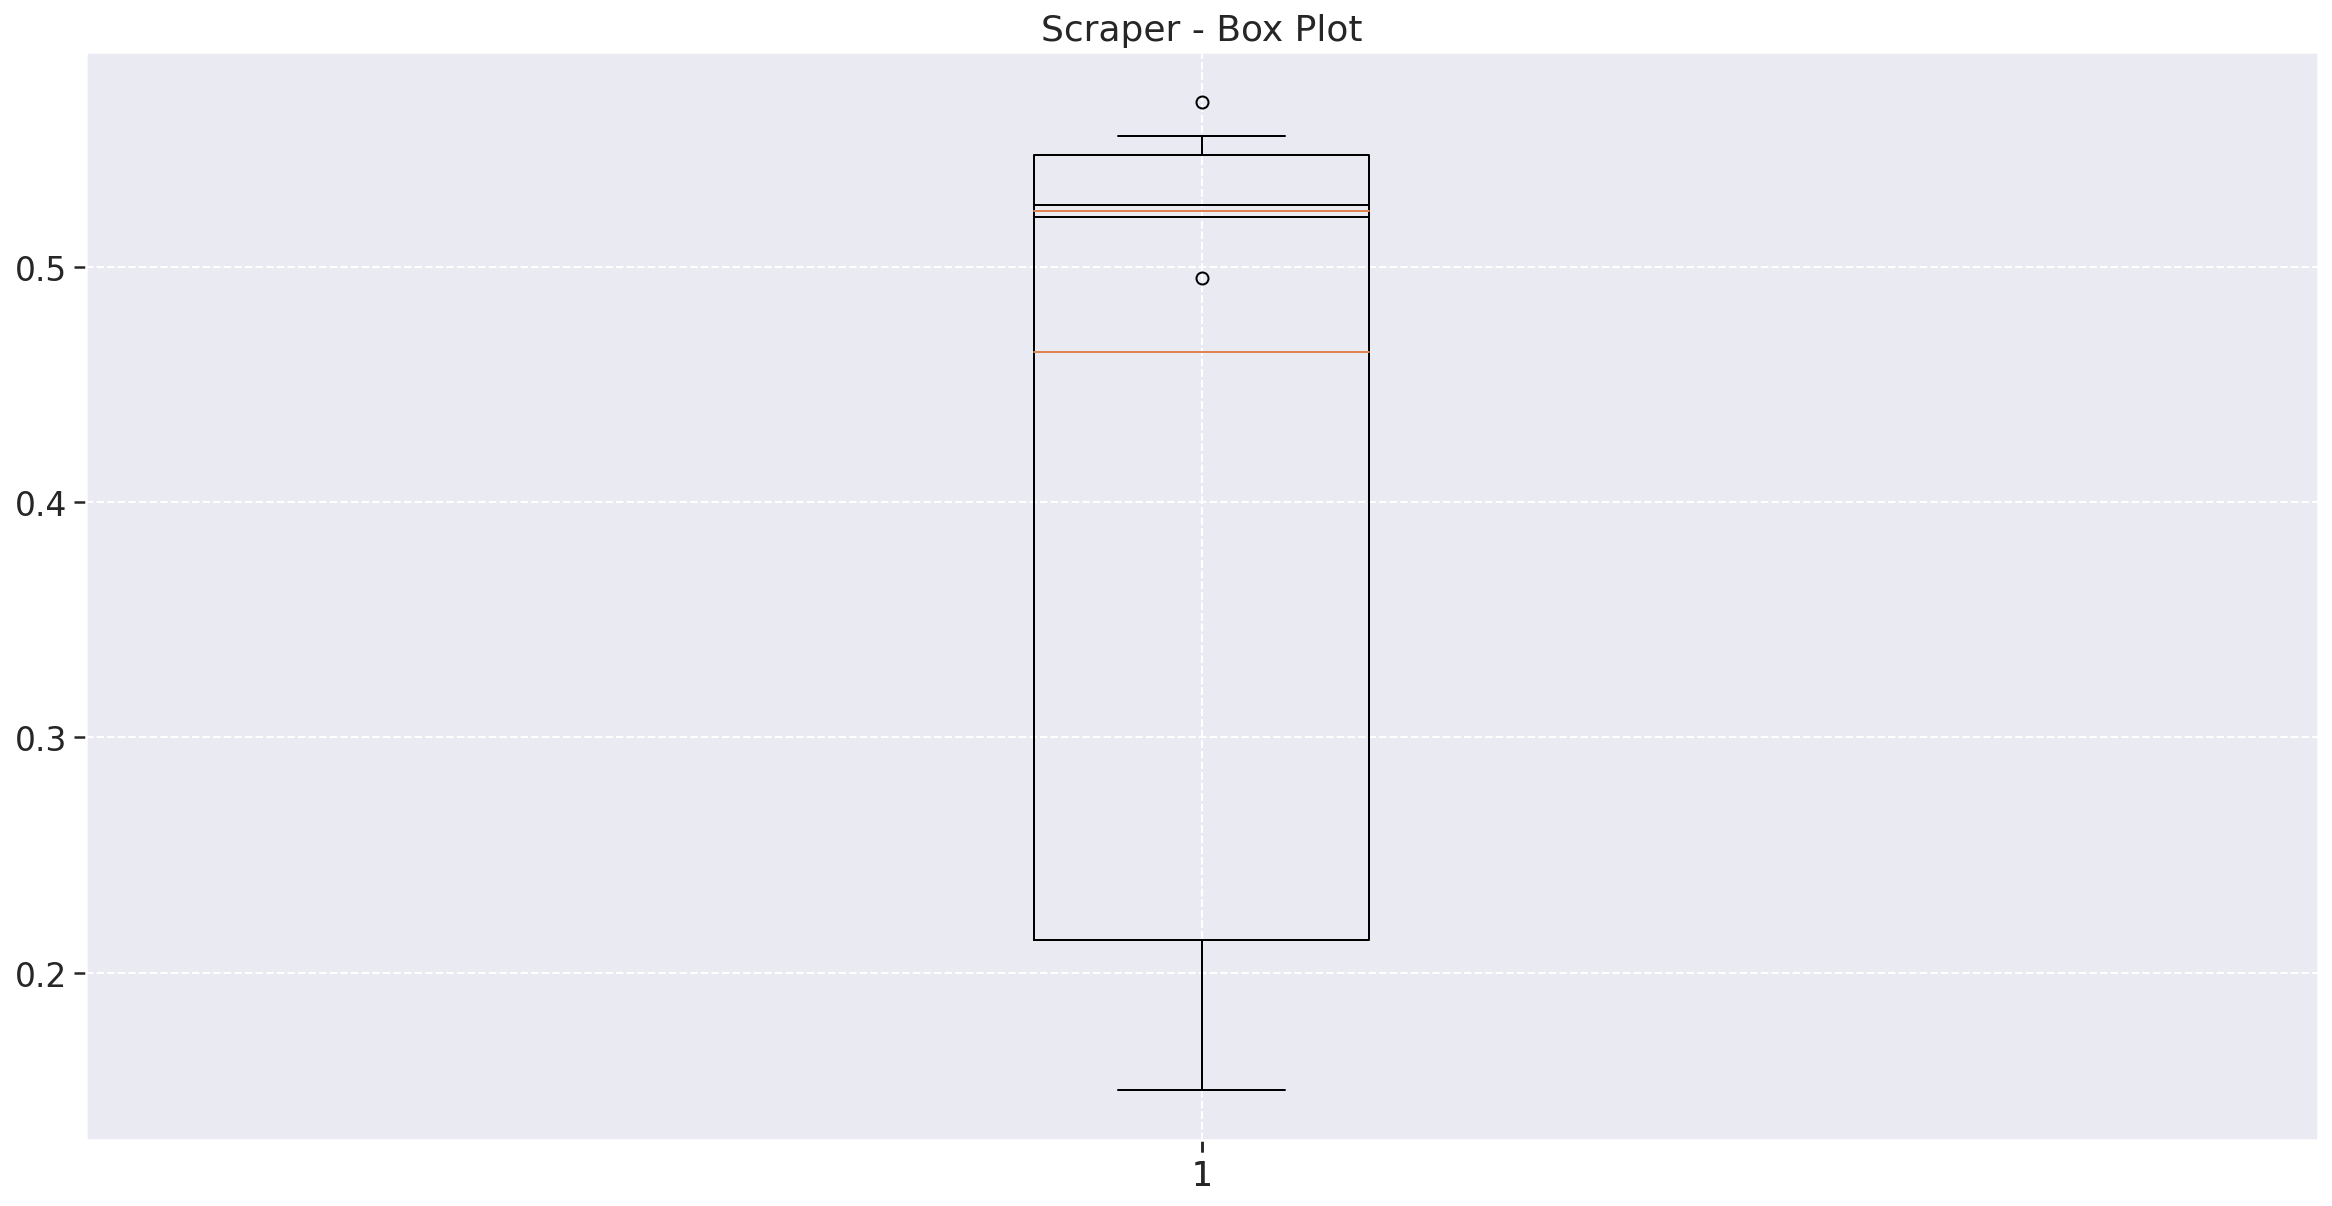

In [33]:
fig = plt.figure(figsize=(20, 10))

plt.title('Scraper - Box Plot')
plt.boxplot(scraper_metrics['code_quality'])
plt.boxplot(scraper_metrics['testing_status'])

Text(0.5, 1.0, 'Matriz de Correção - Scraper')

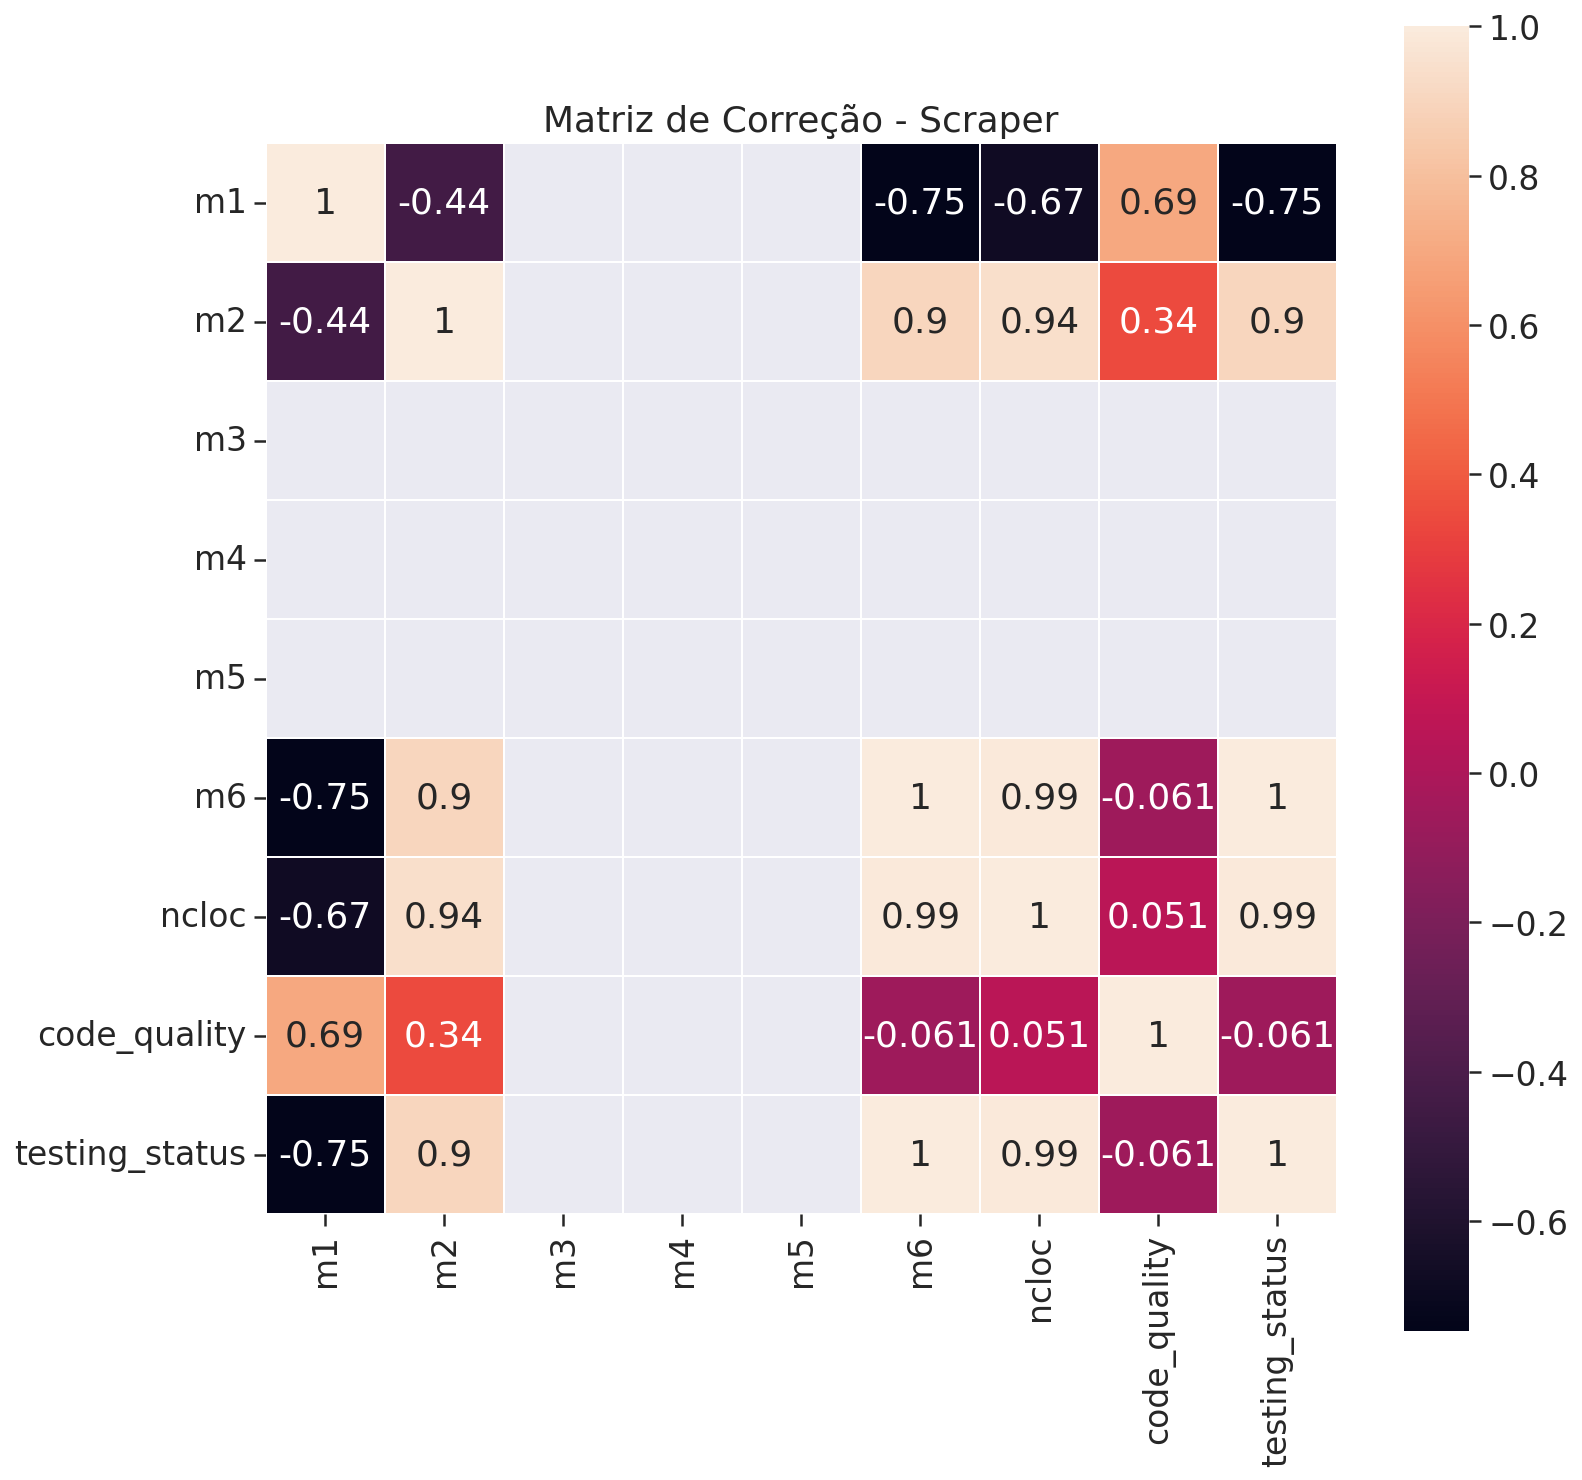

In [34]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(scraper_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Scraper')

### Document API

In [35]:
documentsapi_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,0.200000,0.100000,1.0,1.0,0,0.600000,DocumentsAPI,02-11-2021-23-35,359,0.429000,0.570000
1,0.210526,0.105263,1.0,1.0,0,0.526316,DocumentsAPI,07-10-2021-07-31,336,0.434211,0.518421
2,0.210526,0.105263,1.0,1.0,0,0.526316,DocumentsAPI,07-10-2021-12-28,341,0.434211,0.518421
3,0.238095,0.095238,1.0,1.0,0,0.619048,DocumentsAPI,07-11-2021-18-29,482,0.440000,0.583333
4,0.187500,0.125000,1.0,1.0,0,0.562500,DocumentsAPI,15-09-2021-00-24,289,0.433125,0.543750
5,0.222222,0.111111,1.0,1.0,0,0.555556,DocumentsAPI,15-10-2021-20-45,266,0.440000,0.538889


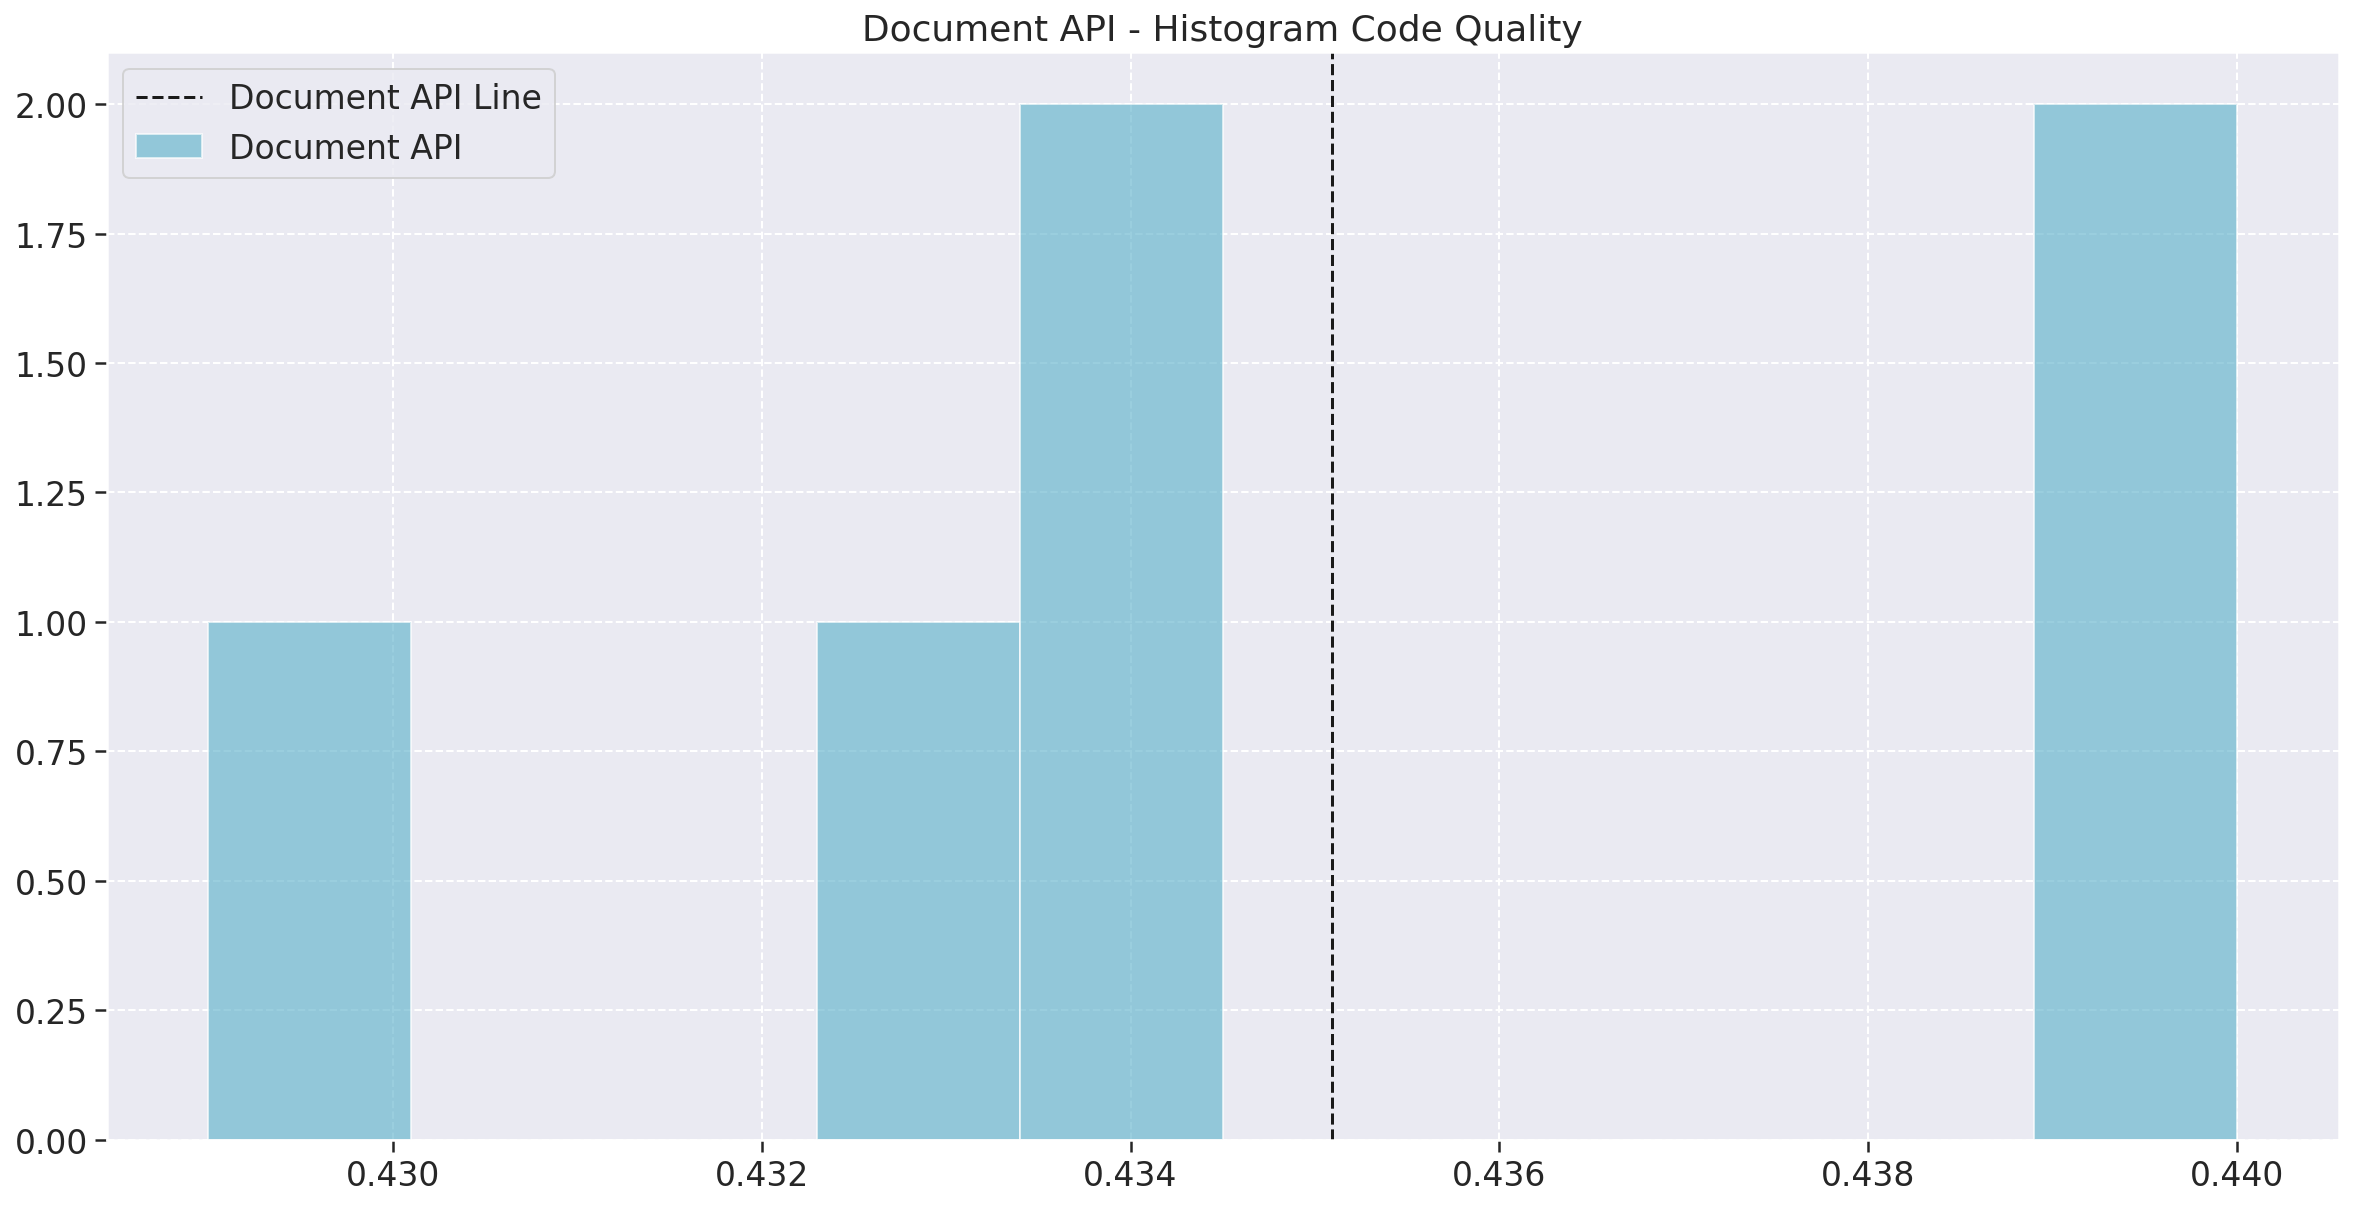

In [36]:
fig = plt.figure(figsize=(20, 10))

plt.title('Document API - Histogram Code Quality')
plt.hist(documentsapi_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='Document API')
plt.axvline(documentsapi_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='Document API Line')

plt.legend(loc='upper left')

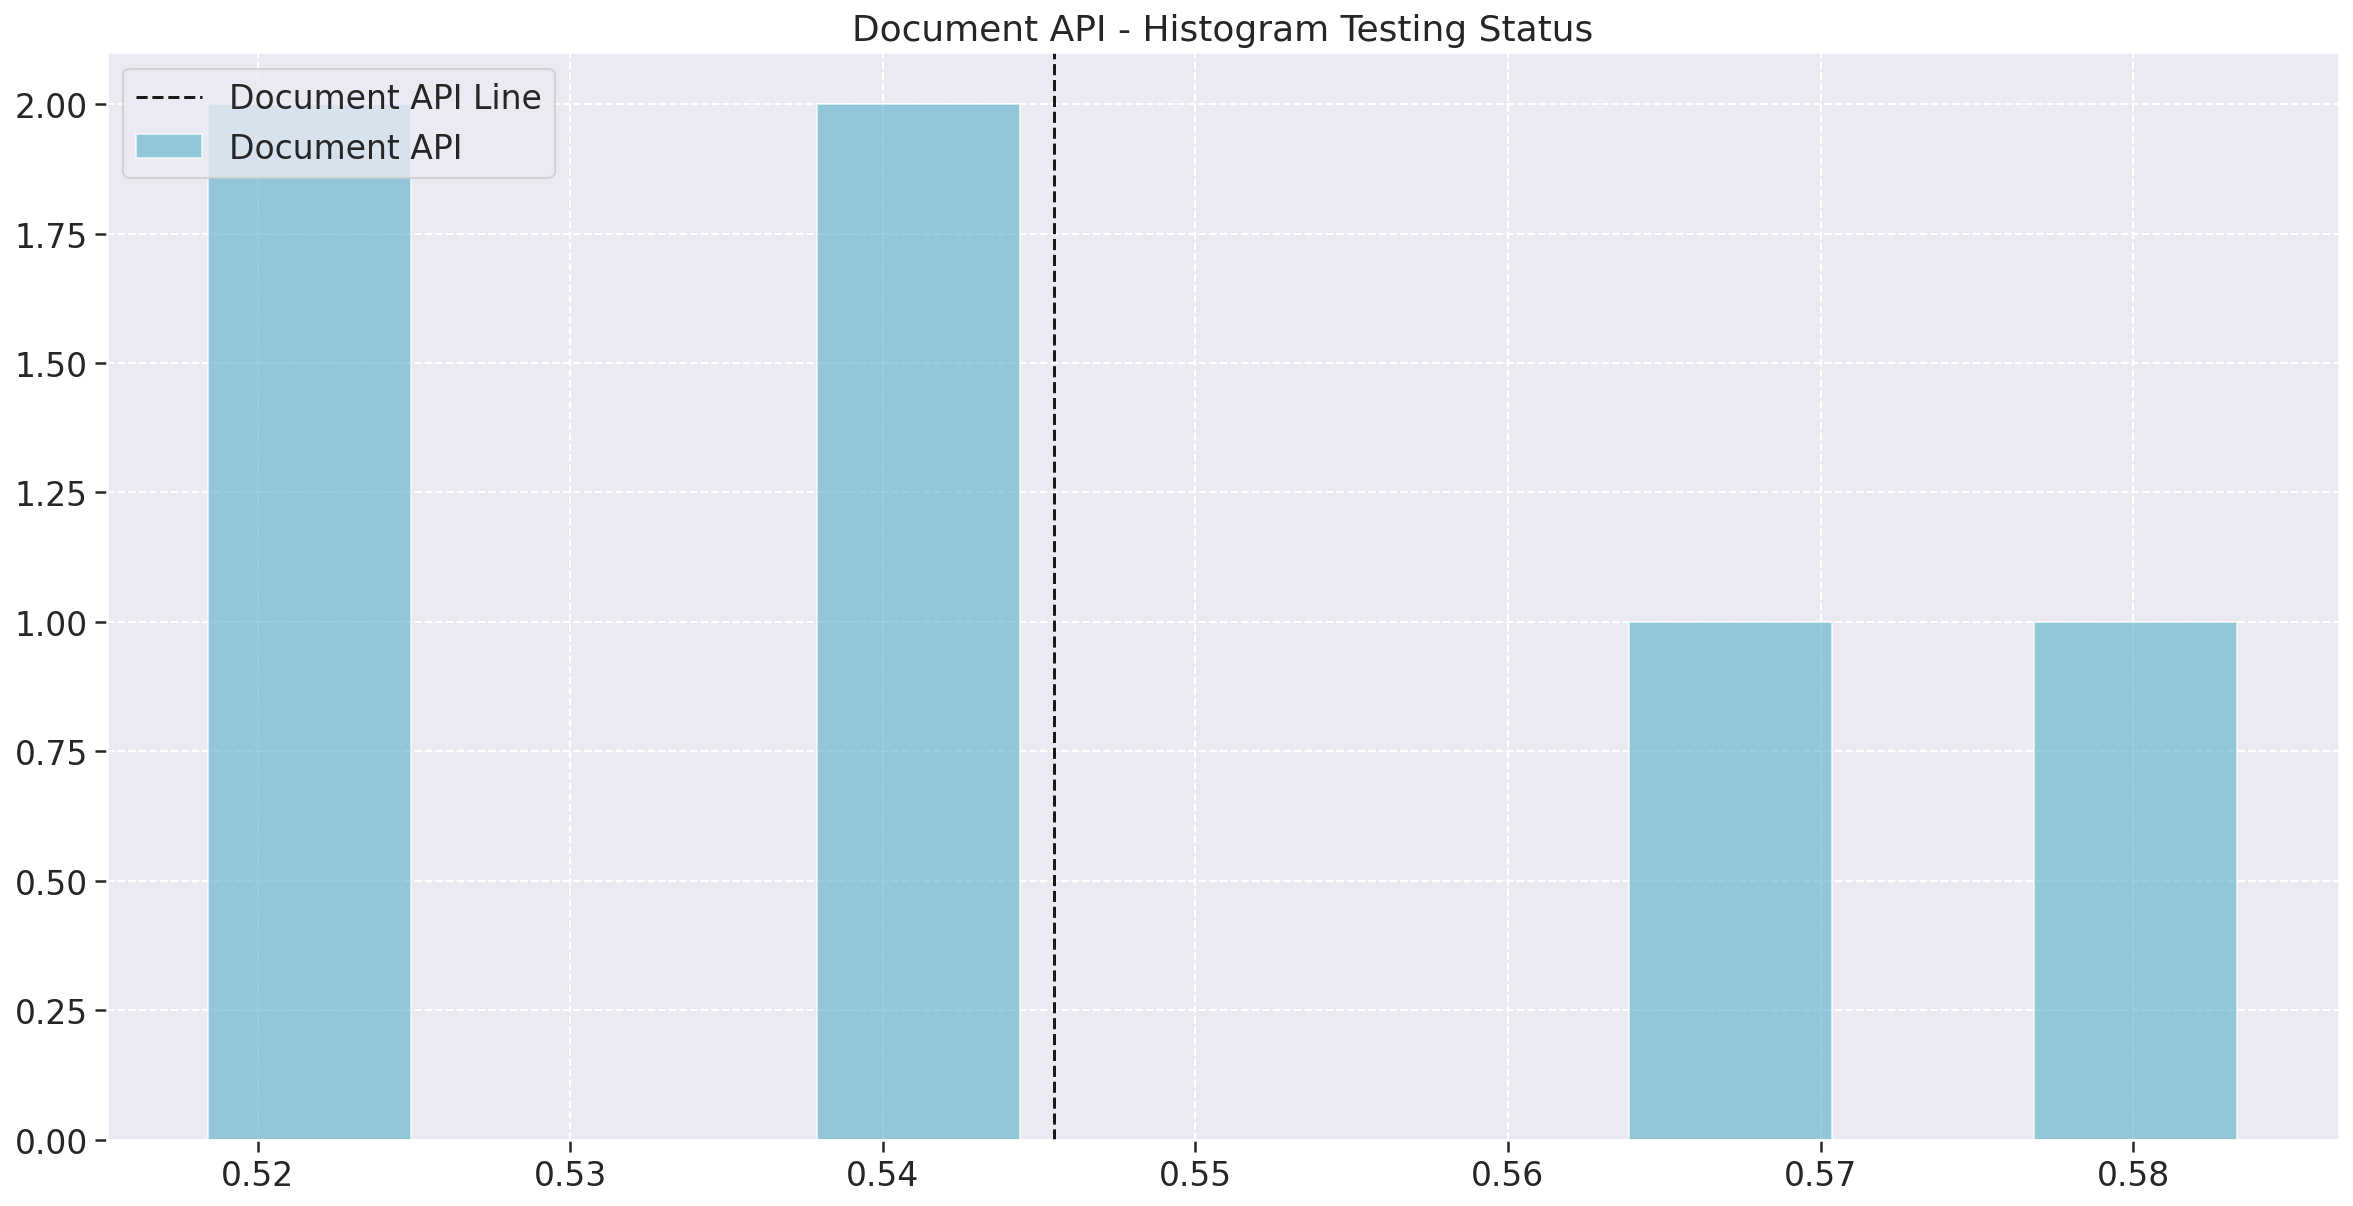

In [37]:
fig = plt.figure(figsize=(20, 10))

plt.title('Document API - Histogram Testing Status')
plt.hist(documentsapi_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='Document API')
plt.axvline(documentsapi_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='Document API Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ecd0eebe0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ecd0f9340>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ecd0ee850>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ecd0f9a60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ecd0f9df0>],
 'means': []}

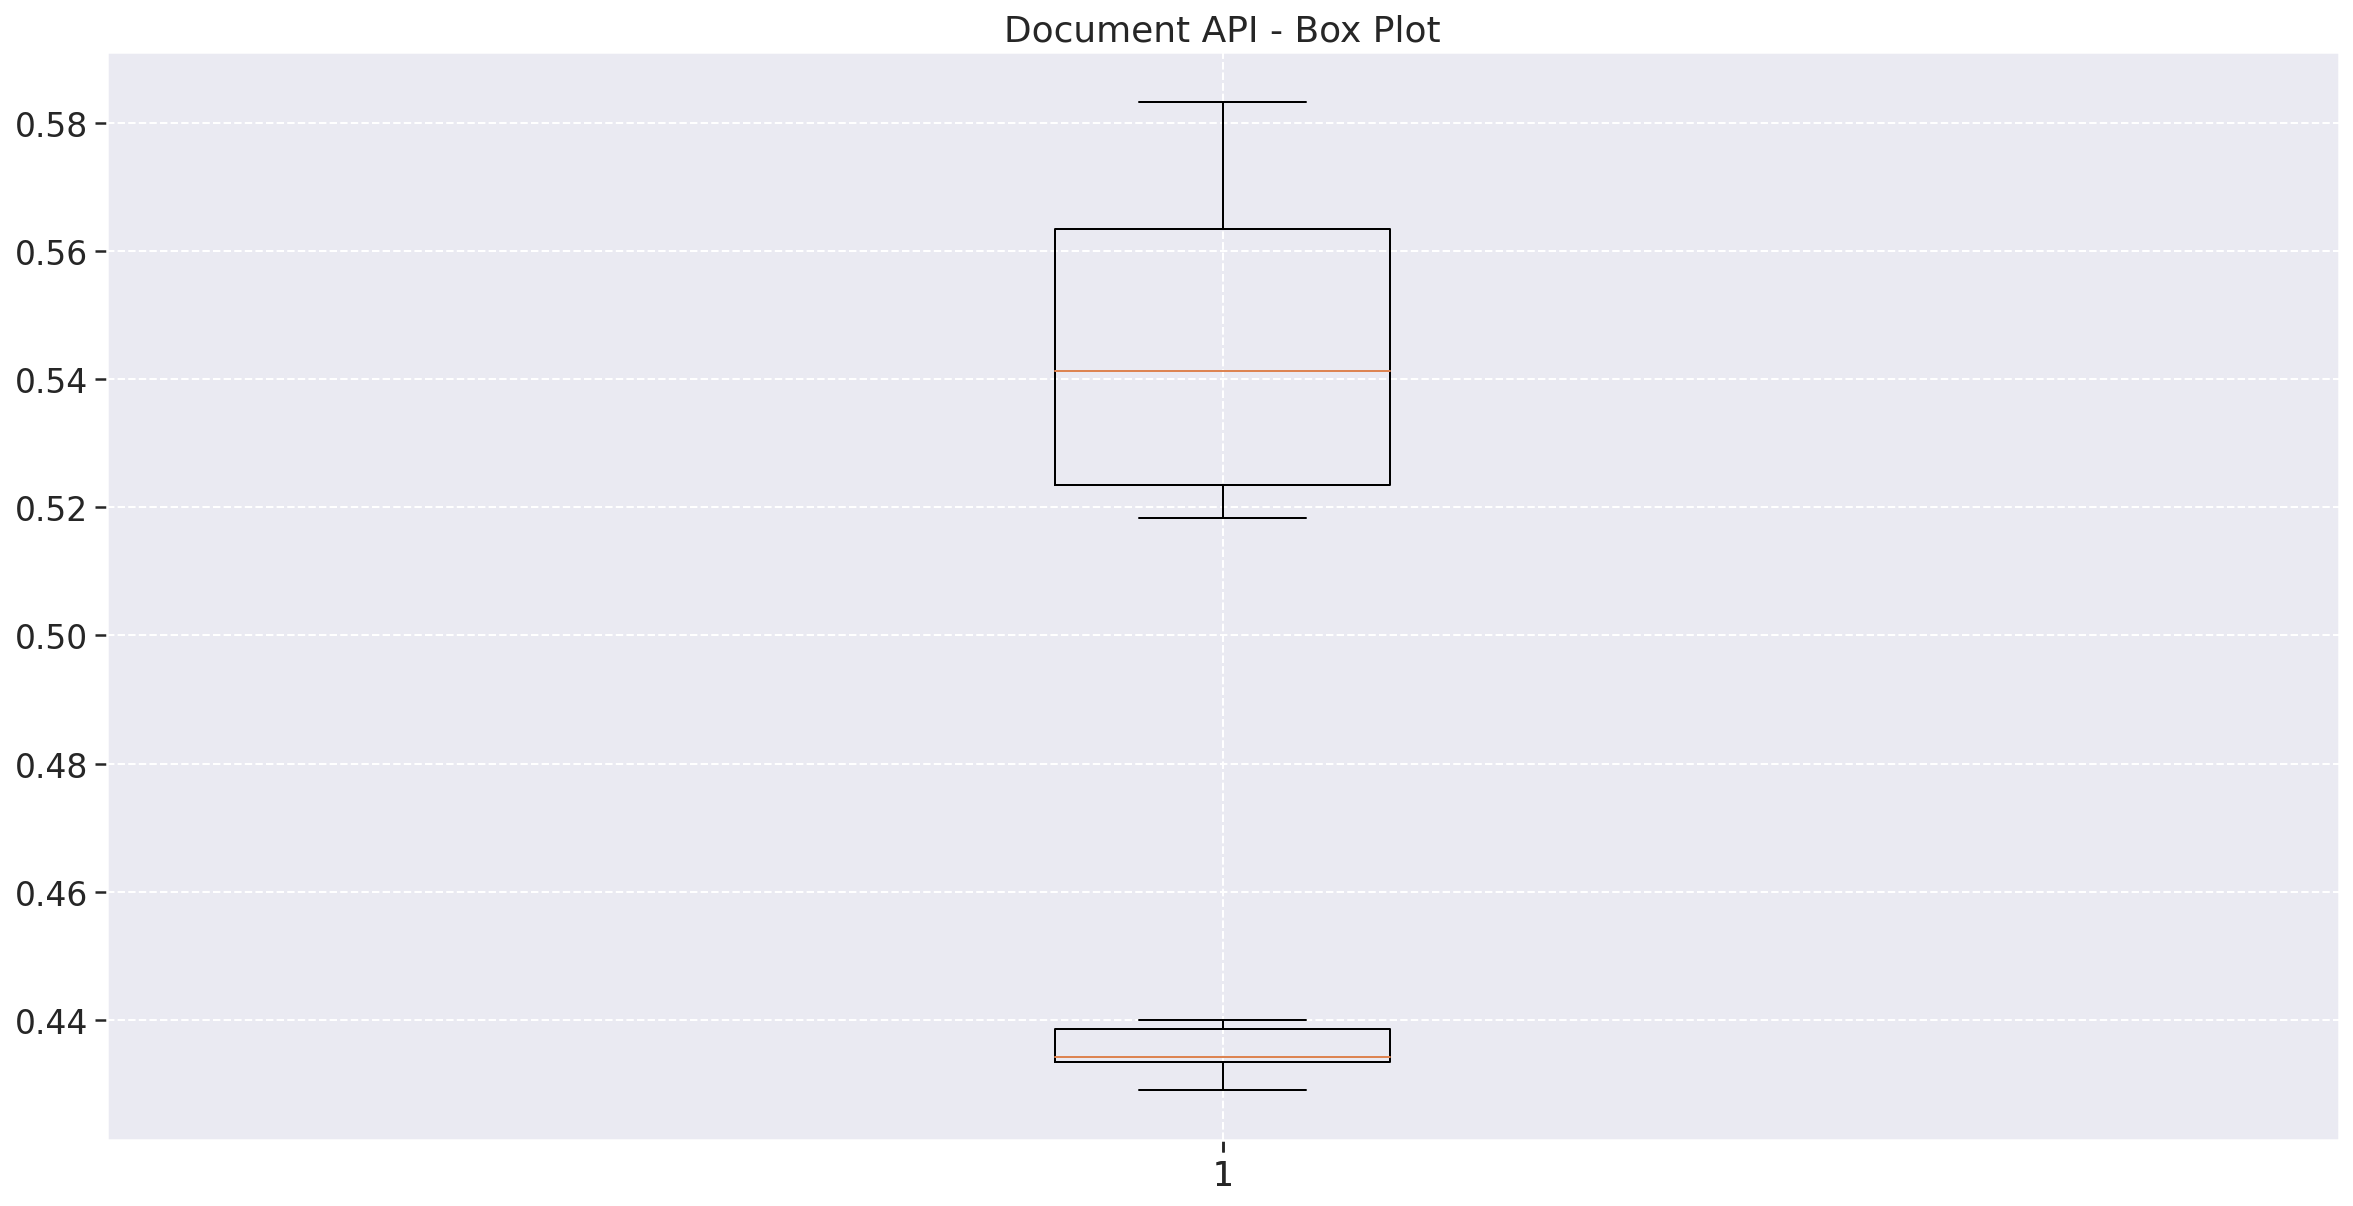

In [38]:
fig = plt.figure(figsize=(20, 10))

plt.title('Document API - Box Plot')
plt.boxplot(documentsapi_metrics['code_quality'])
plt.boxplot(documentsapi_metrics['testing_status'])

Text(0.5, 1.0, 'Matriz de Correção - Document API')

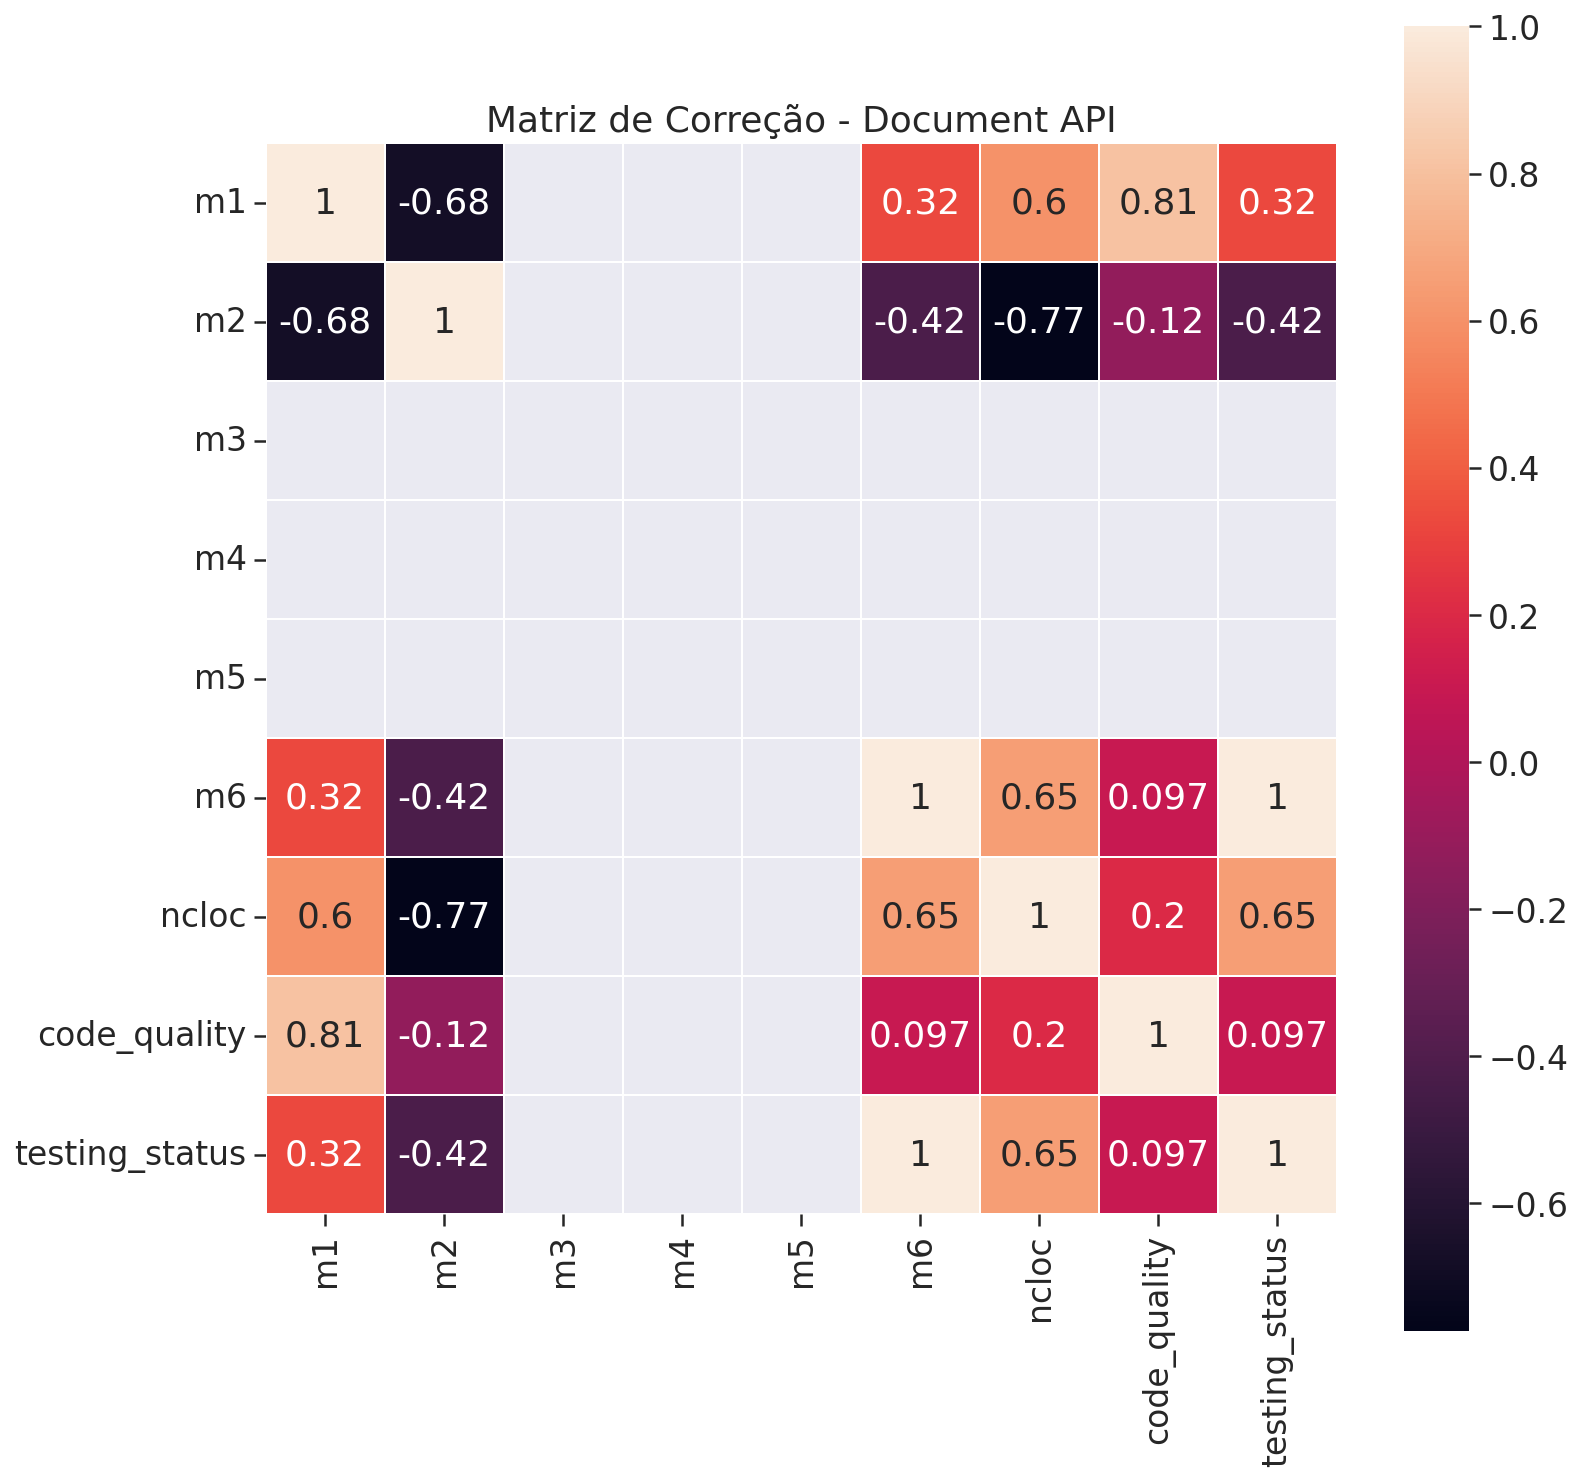

In [39]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(documentsapi_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Document API')

### ML Training

In [40]:
mltraining_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,1.0,0.0,1.0,1.0,0,0.0,MLTraining,14-09-2021-23-45,138,0.66,0.15
1,1.0,0.0,1.0,1.0,0,0.0,MLTraining,21-10-2021-15-24,138,0.66,0.15


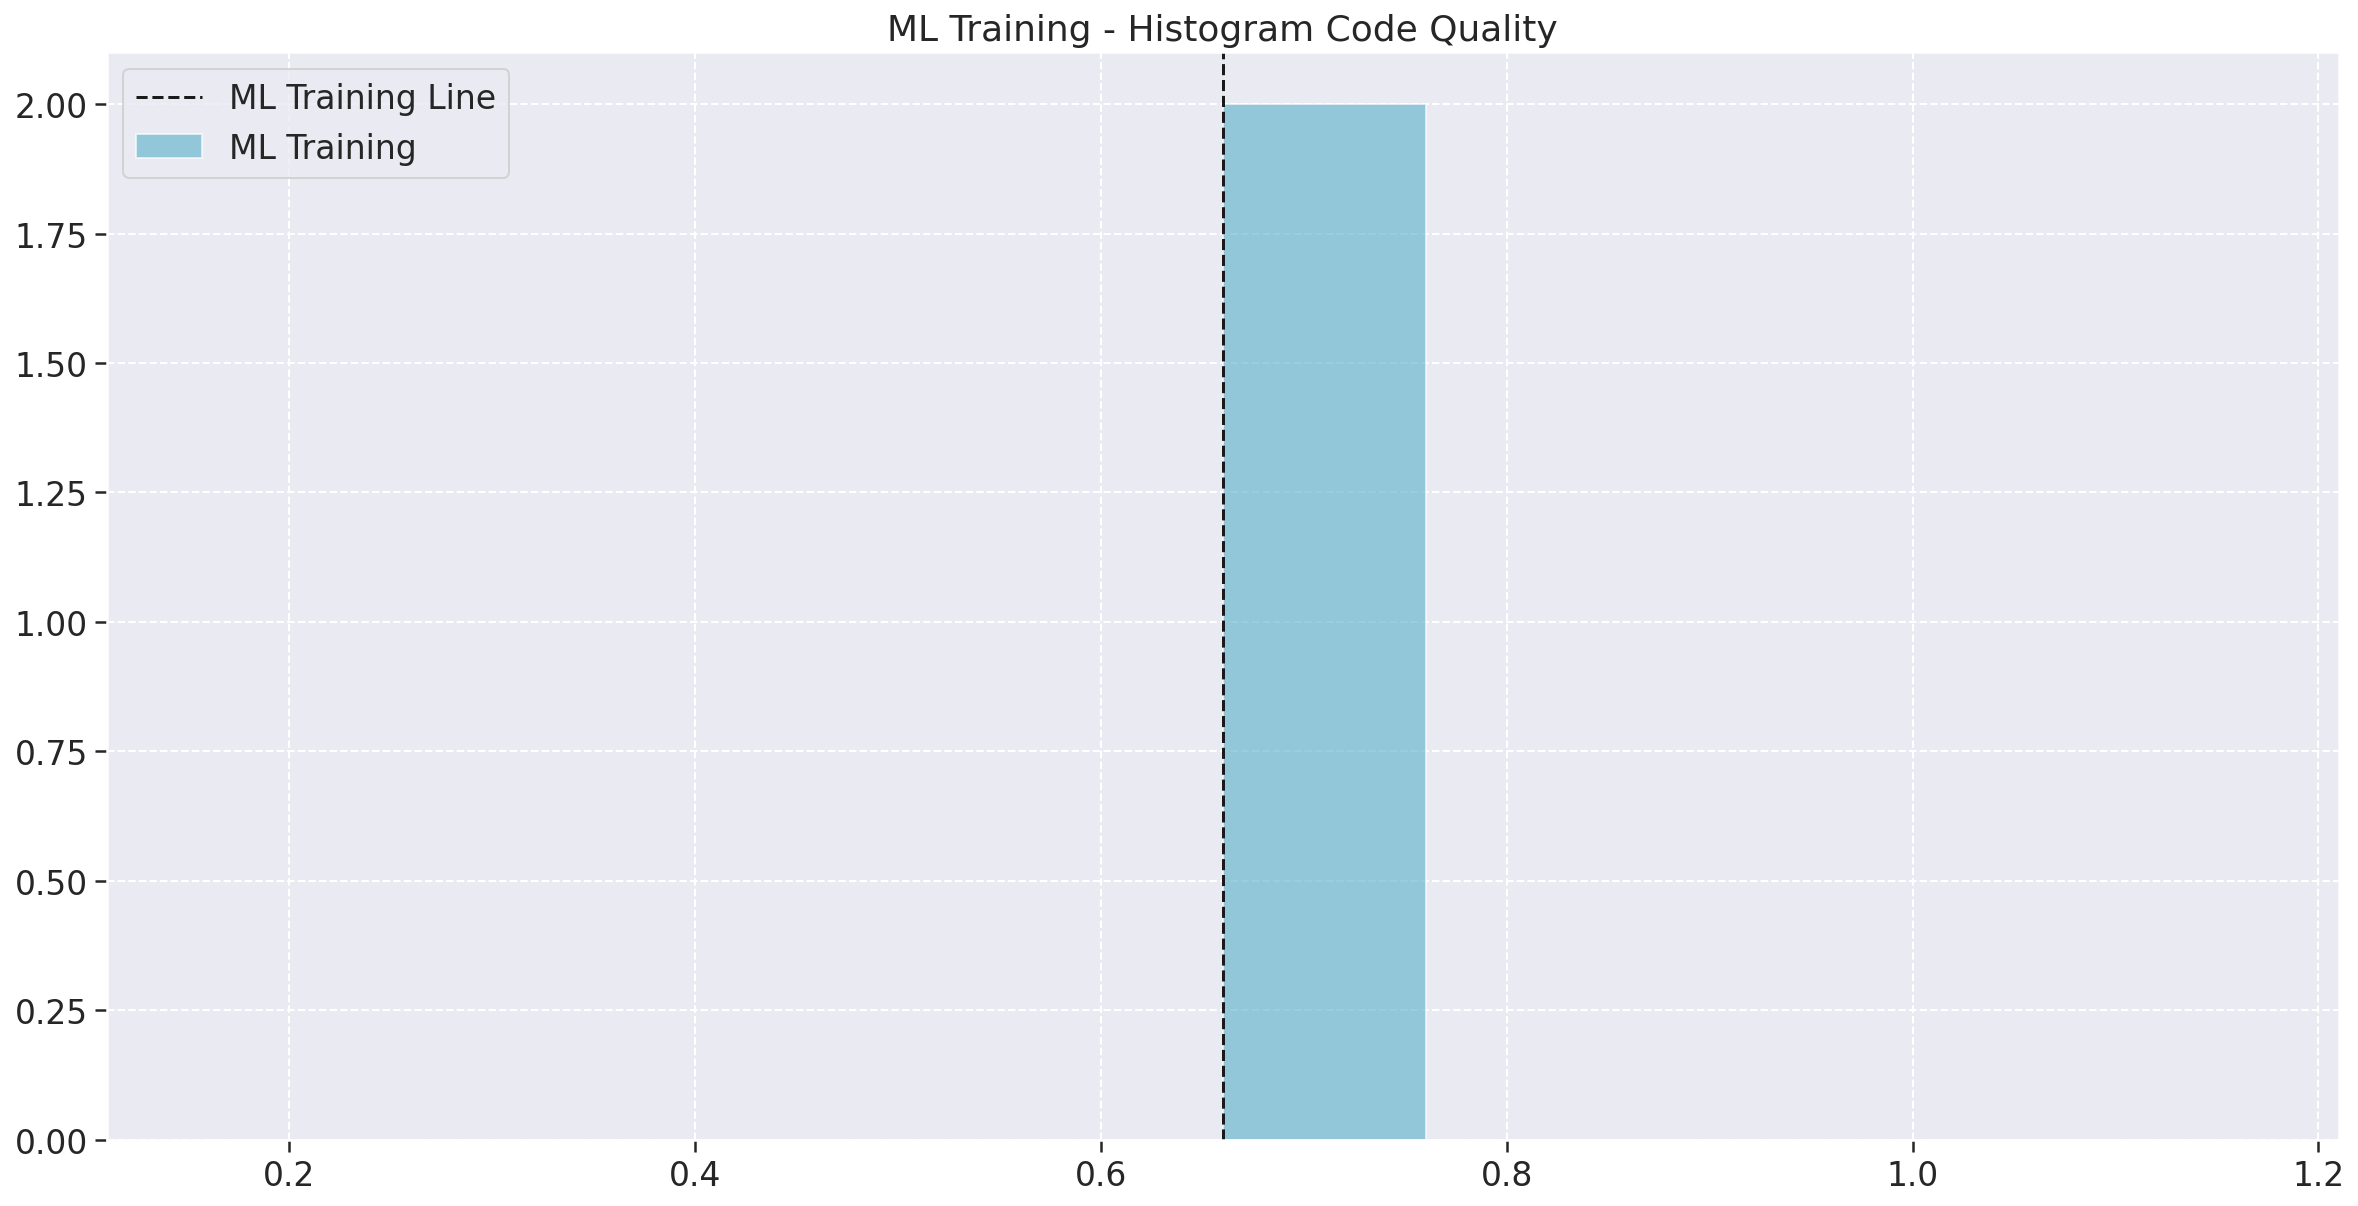

In [41]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training - Histogram Code Quality')
plt.hist(mltraining_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='ML Training')
plt.axvline(mltraining_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='ML Training Line')

plt.legend(loc='upper left')

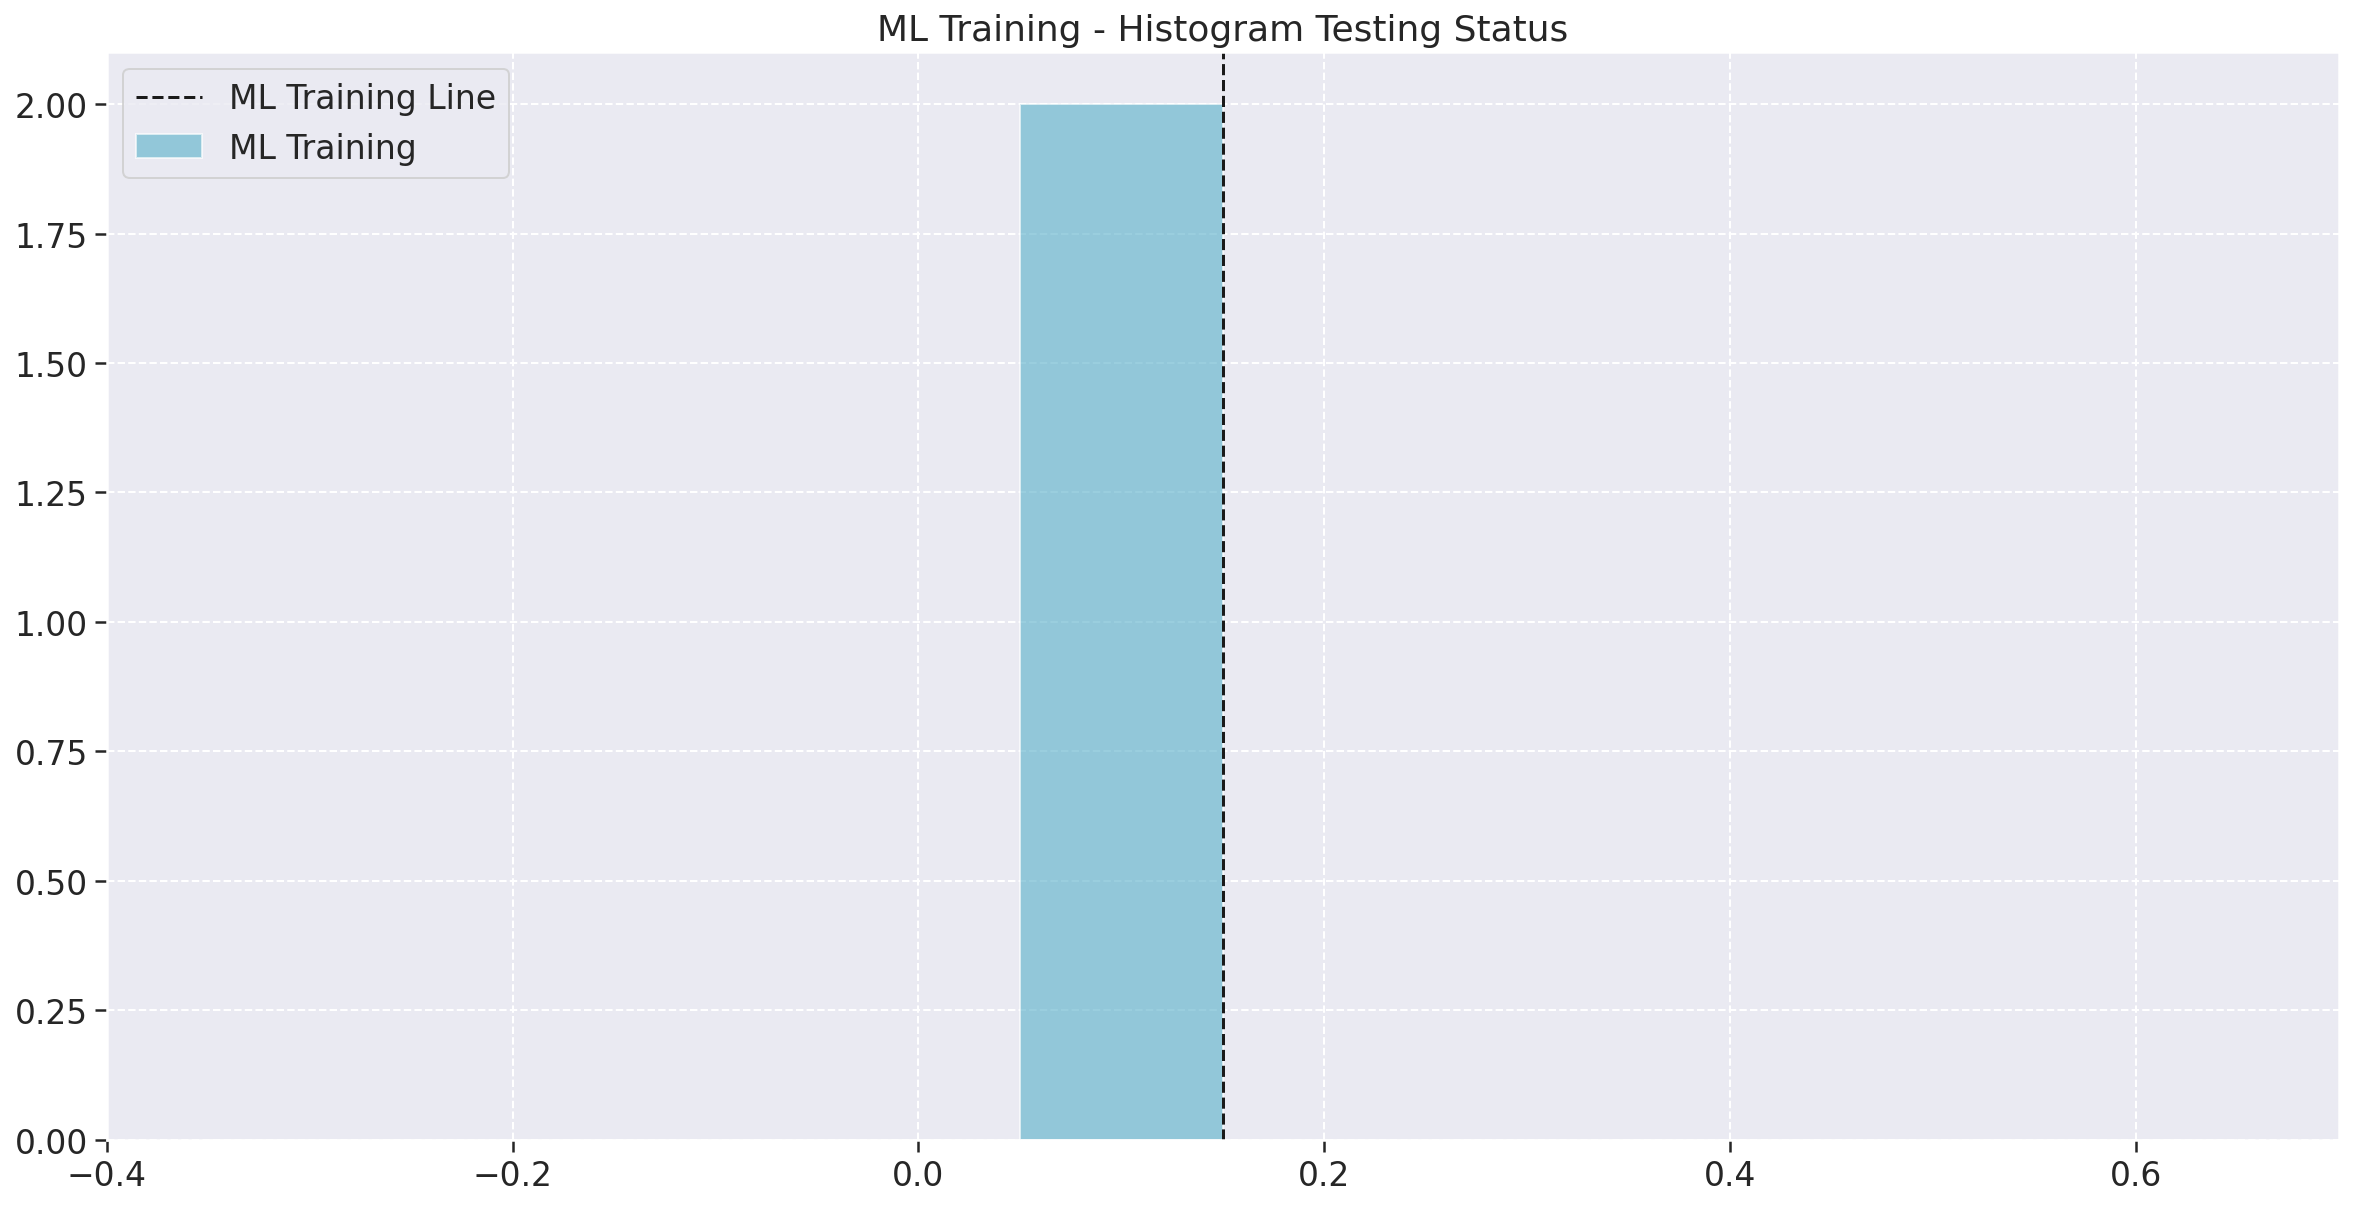

In [42]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training - Histogram Testing Status')
plt.hist(mltraining_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='ML Training')
plt.axvline(mltraining_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='ML Training Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ecce26b80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ecce2e2e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ecce267f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ecce2ea00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ecce2ed90>],
 'means': []}

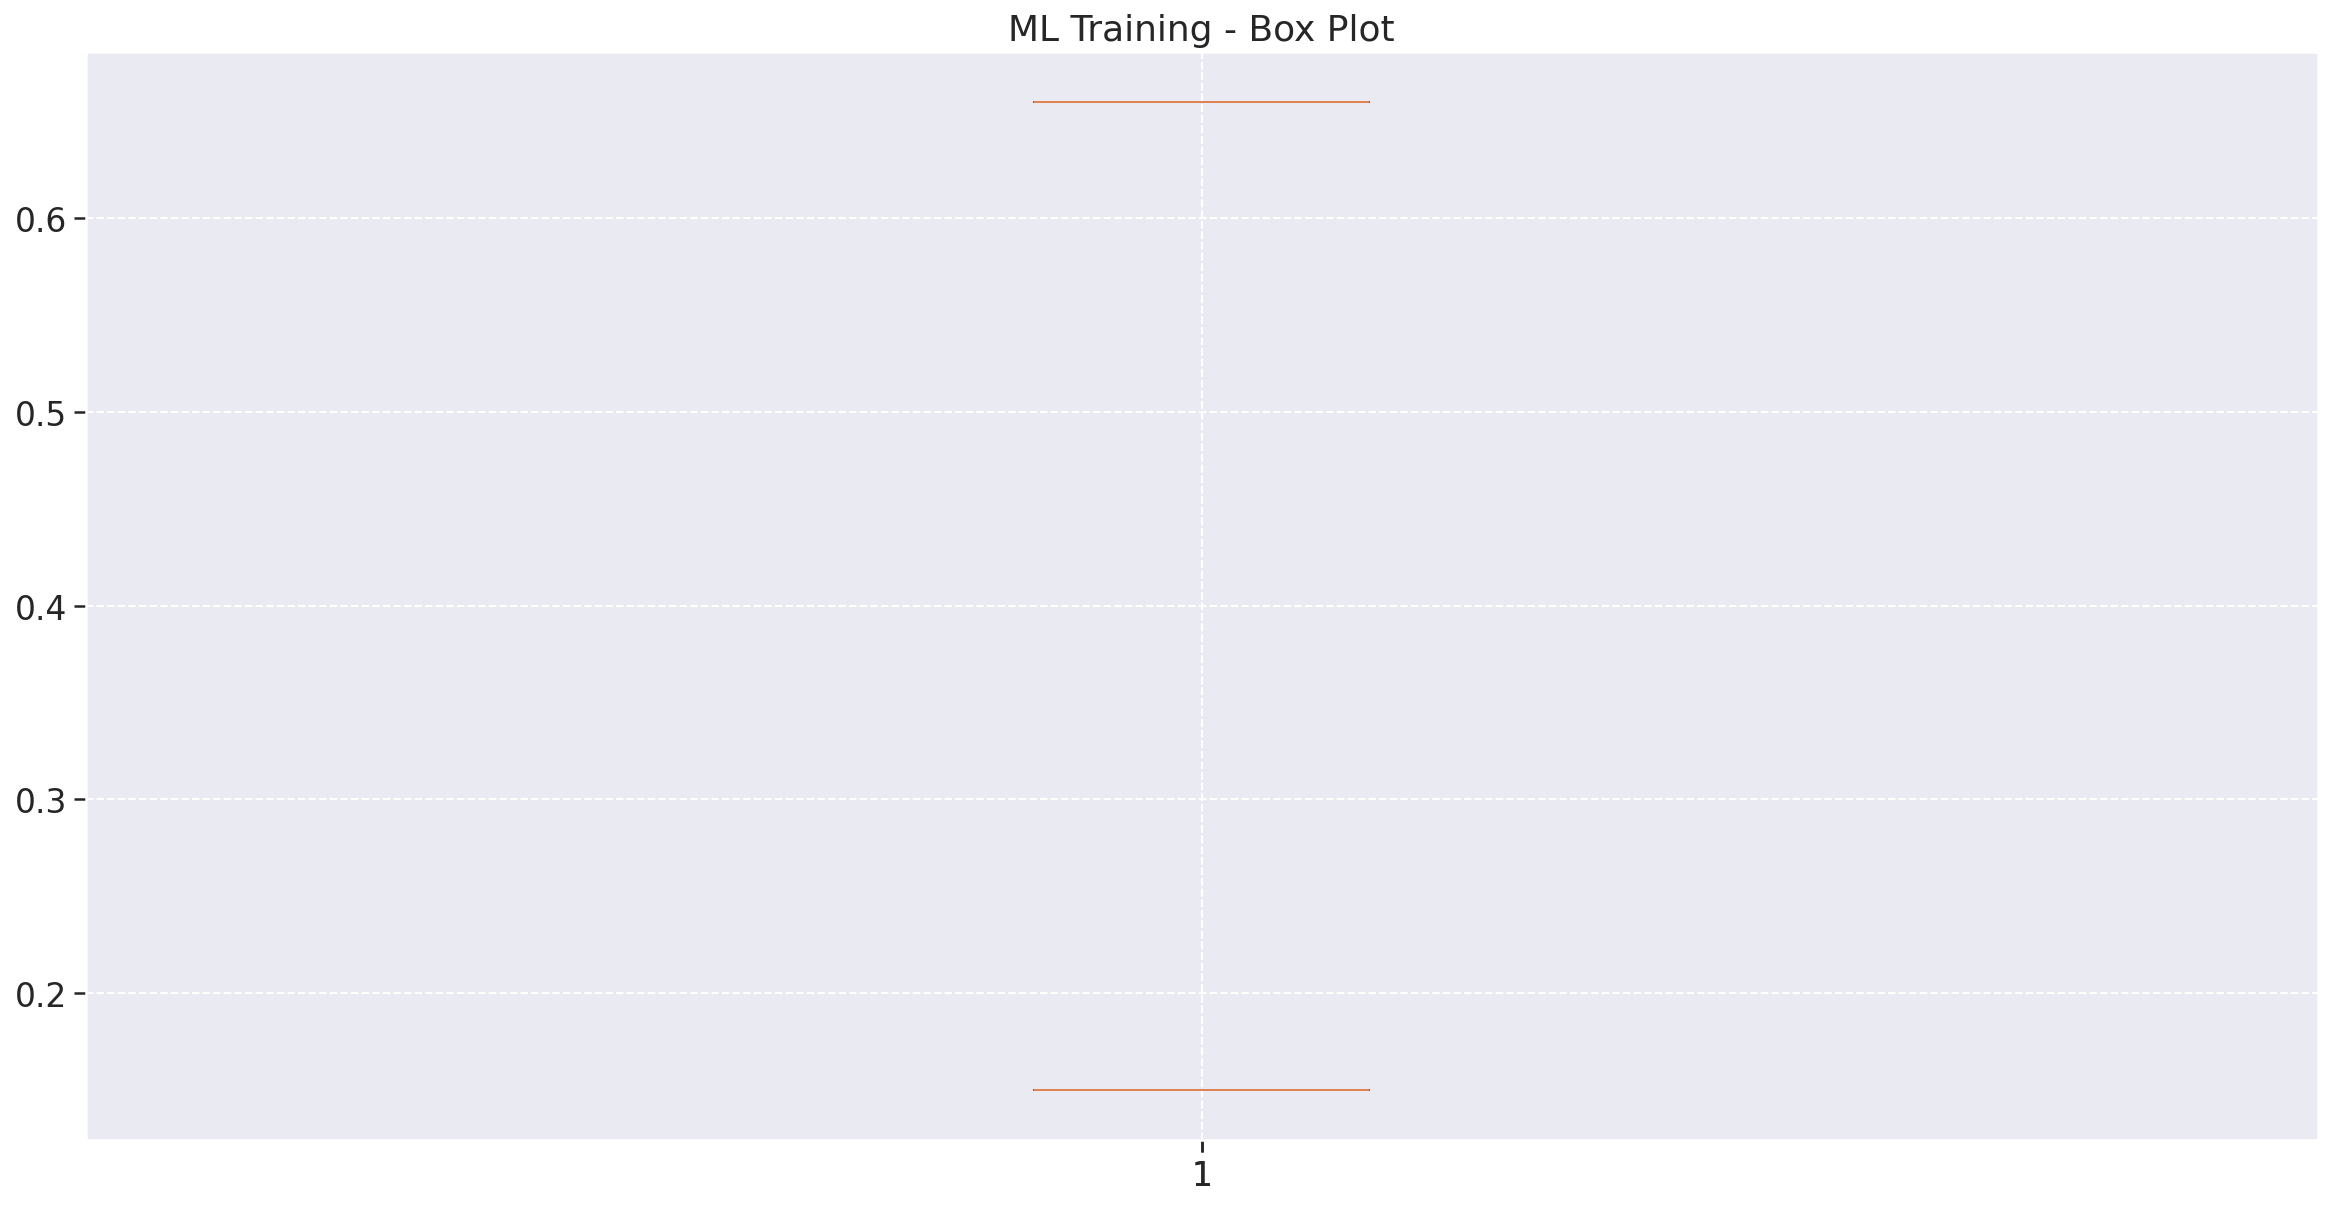

In [43]:
fig = plt.figure(figsize=(20, 10))

plt.title('ML Training - Box Plot')
plt.boxplot(mltraining_metrics['code_quality'])
plt.boxplot(mltraining_metrics['testing_status'])

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Text(0.5, 1.0, 'Matriz de Correção - ML Training')

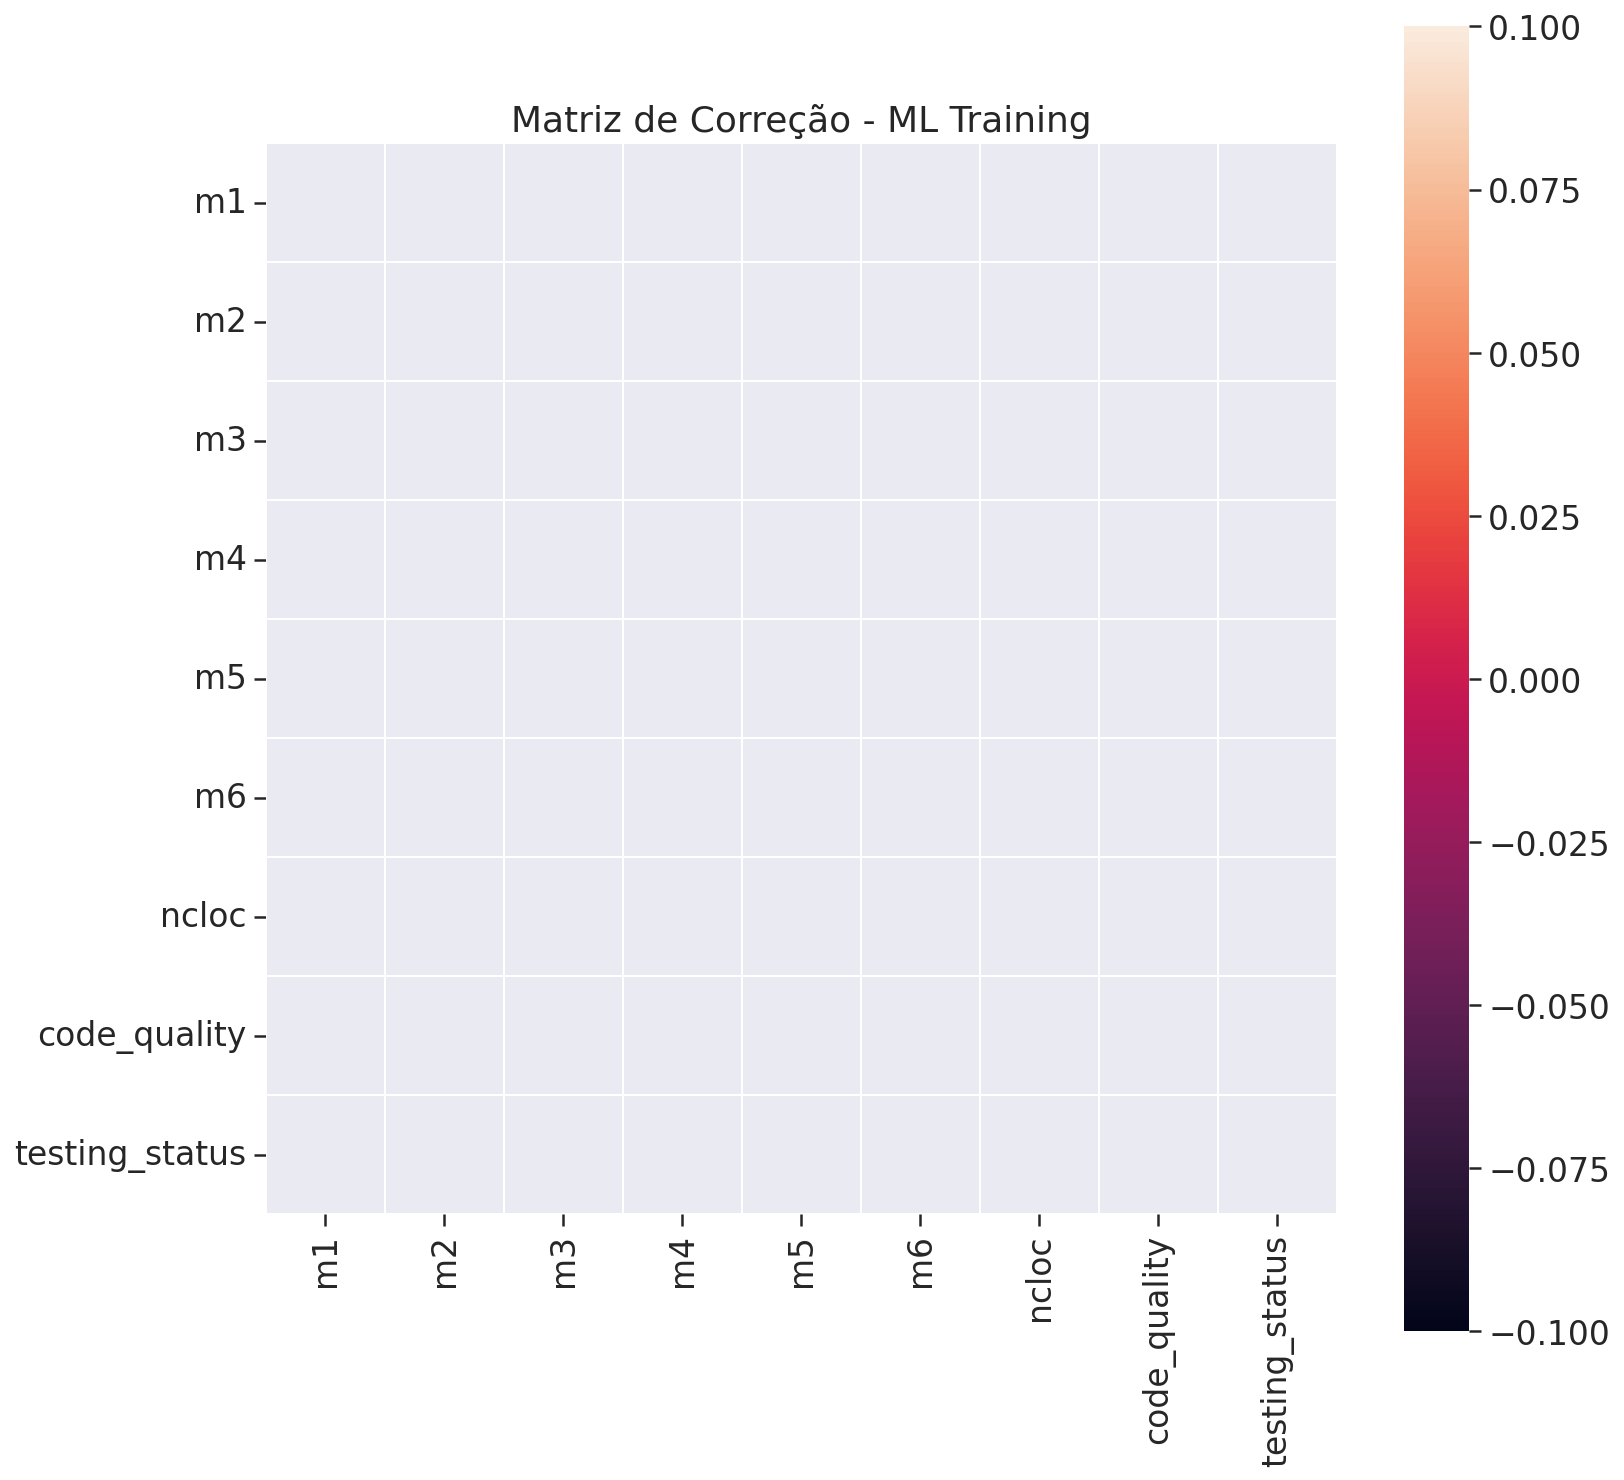

In [44]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(mltraining_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - ML Training')

### Front End

In [45]:
frontend_metrics

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status
0,0.500000,0.052632,0.921053,1.0,0,0.578947,Frontend,02-11-2021-23-30,2460,0.486316,0.555263
1,0.500000,0.052632,0.921053,1.0,0,0.578947,Frontend,03-11-2021-17-44,2460,0.486316,0.555263
2,0.500000,0.200000,1.000000,1.0,0,0.500000,Frontend,07-10-2021-11-50,125,0.561000,0.500000
3,0.553571,0.053571,0.964286,1.0,0,0.500000,Frontend,07-11-2021-18-38,4244,0.518571,0.500000
4,0.553571,0.053571,0.964286,1.0,0,0.500000,Frontend,09-11-2021-16-43,4274,0.518571,0.500000
5,0.600000,0.200000,1.000000,1.0,0,0.200000,Frontend,15-09-2021-00-47,58,0.594000,0.290000
6,0.481481,0.111111,0.925926,1.0,0,0.629630,Frontend,27-10-2021-17-37,1334,0.501111,0.590741


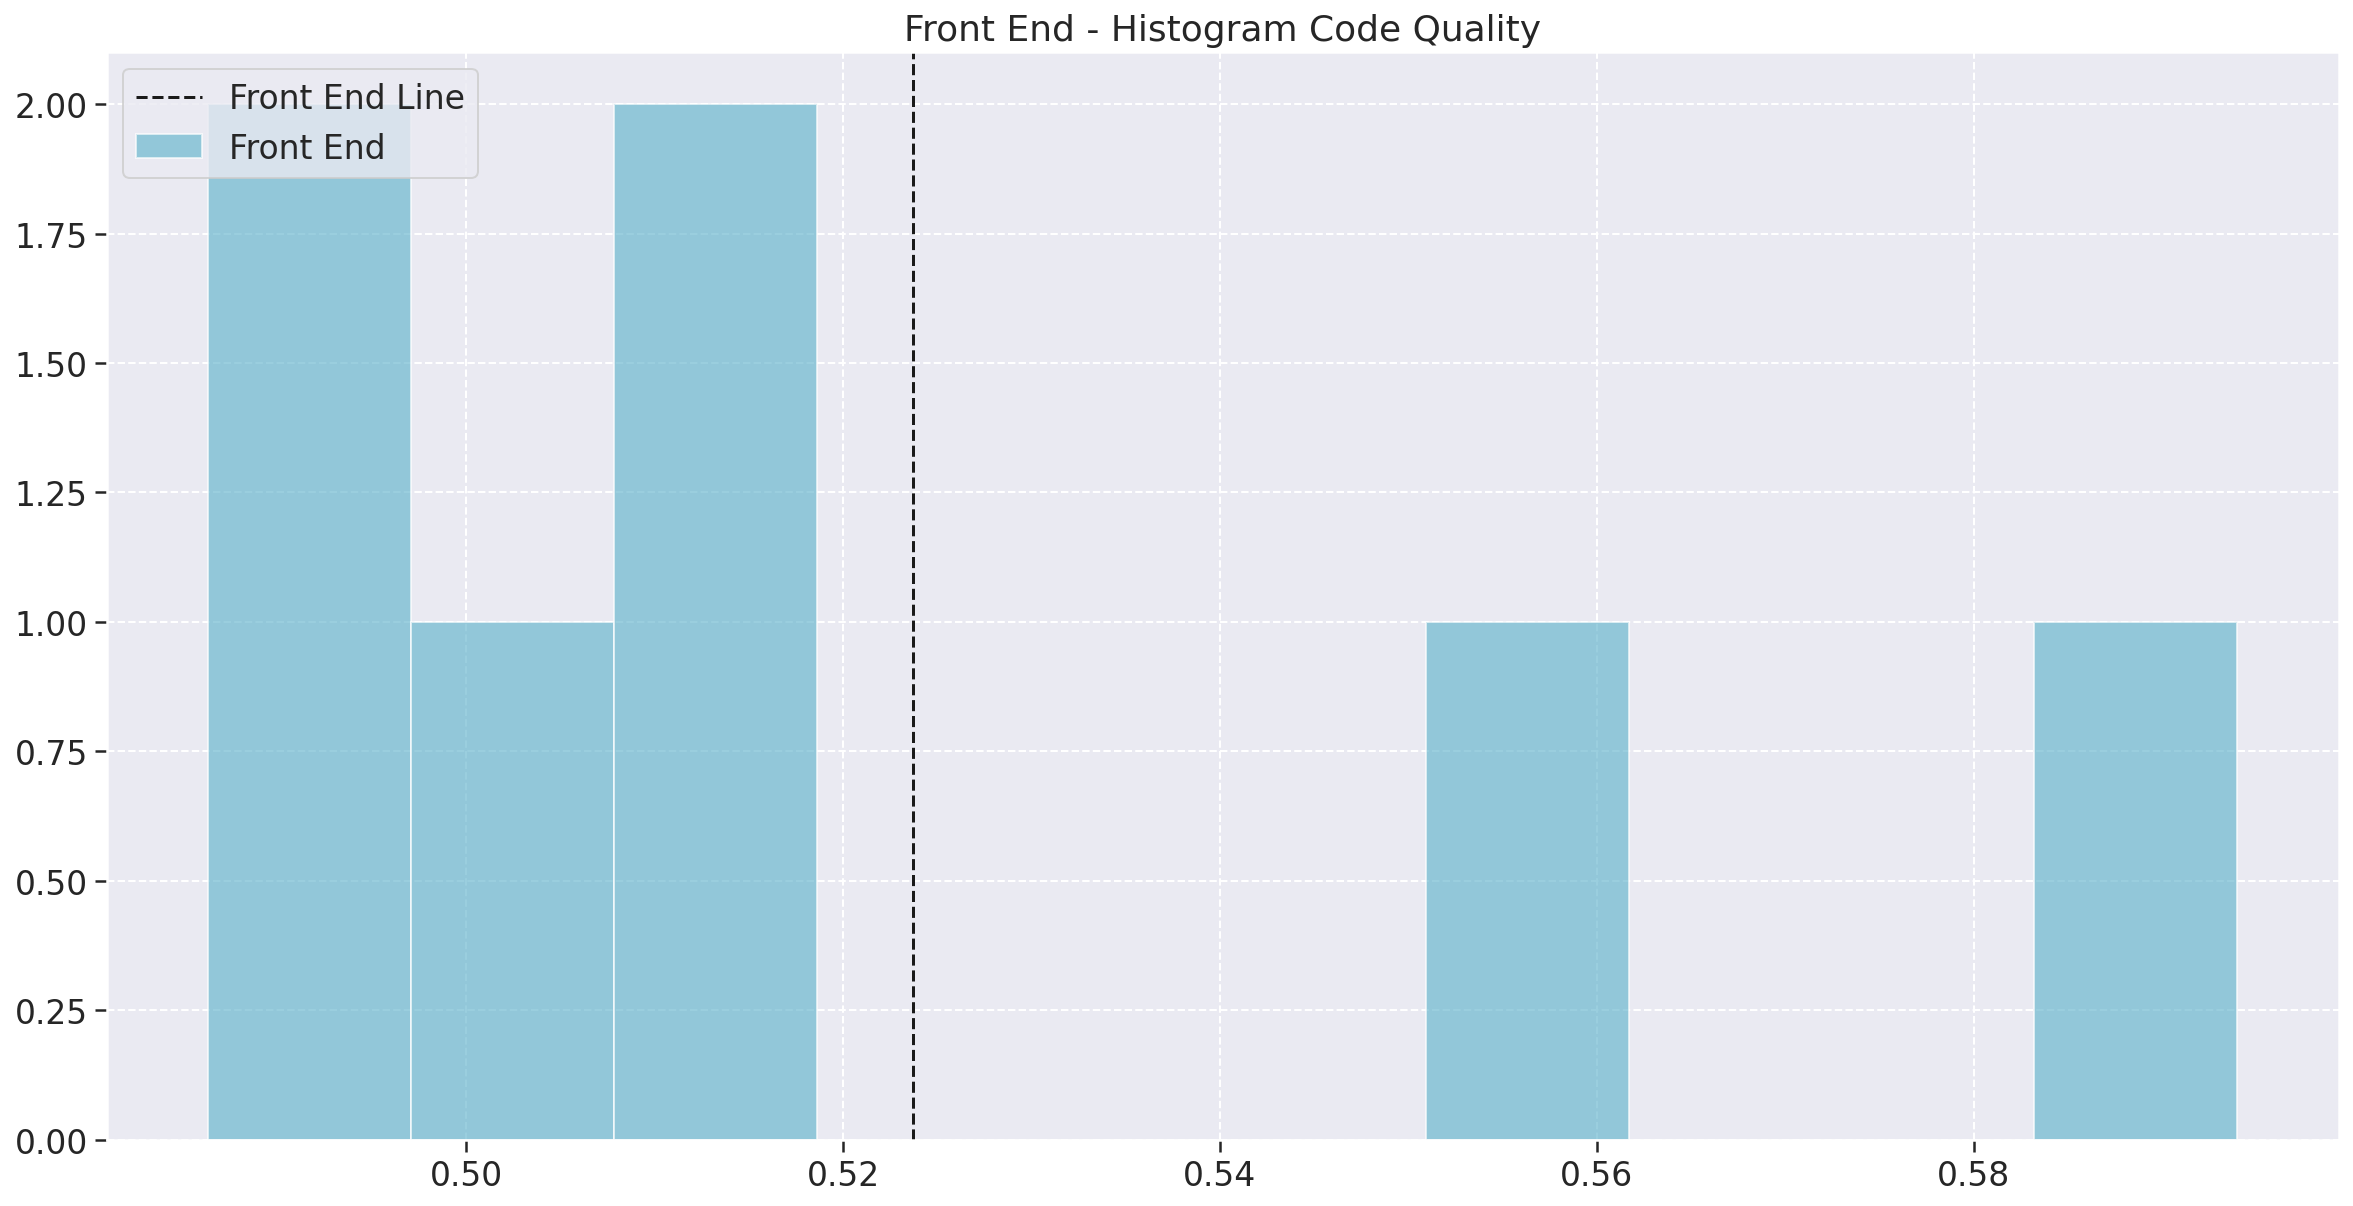

In [46]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End - Histogram Code Quality')
plt.hist(frontend_metrics['code_quality'], bins=10, color='c', alpha=0.65, label='Front End')
plt.axvline(frontend_metrics['code_quality'].mean(), color='k', linestyle='dashed', label='Front End Line')

plt.legend(loc='upper left')

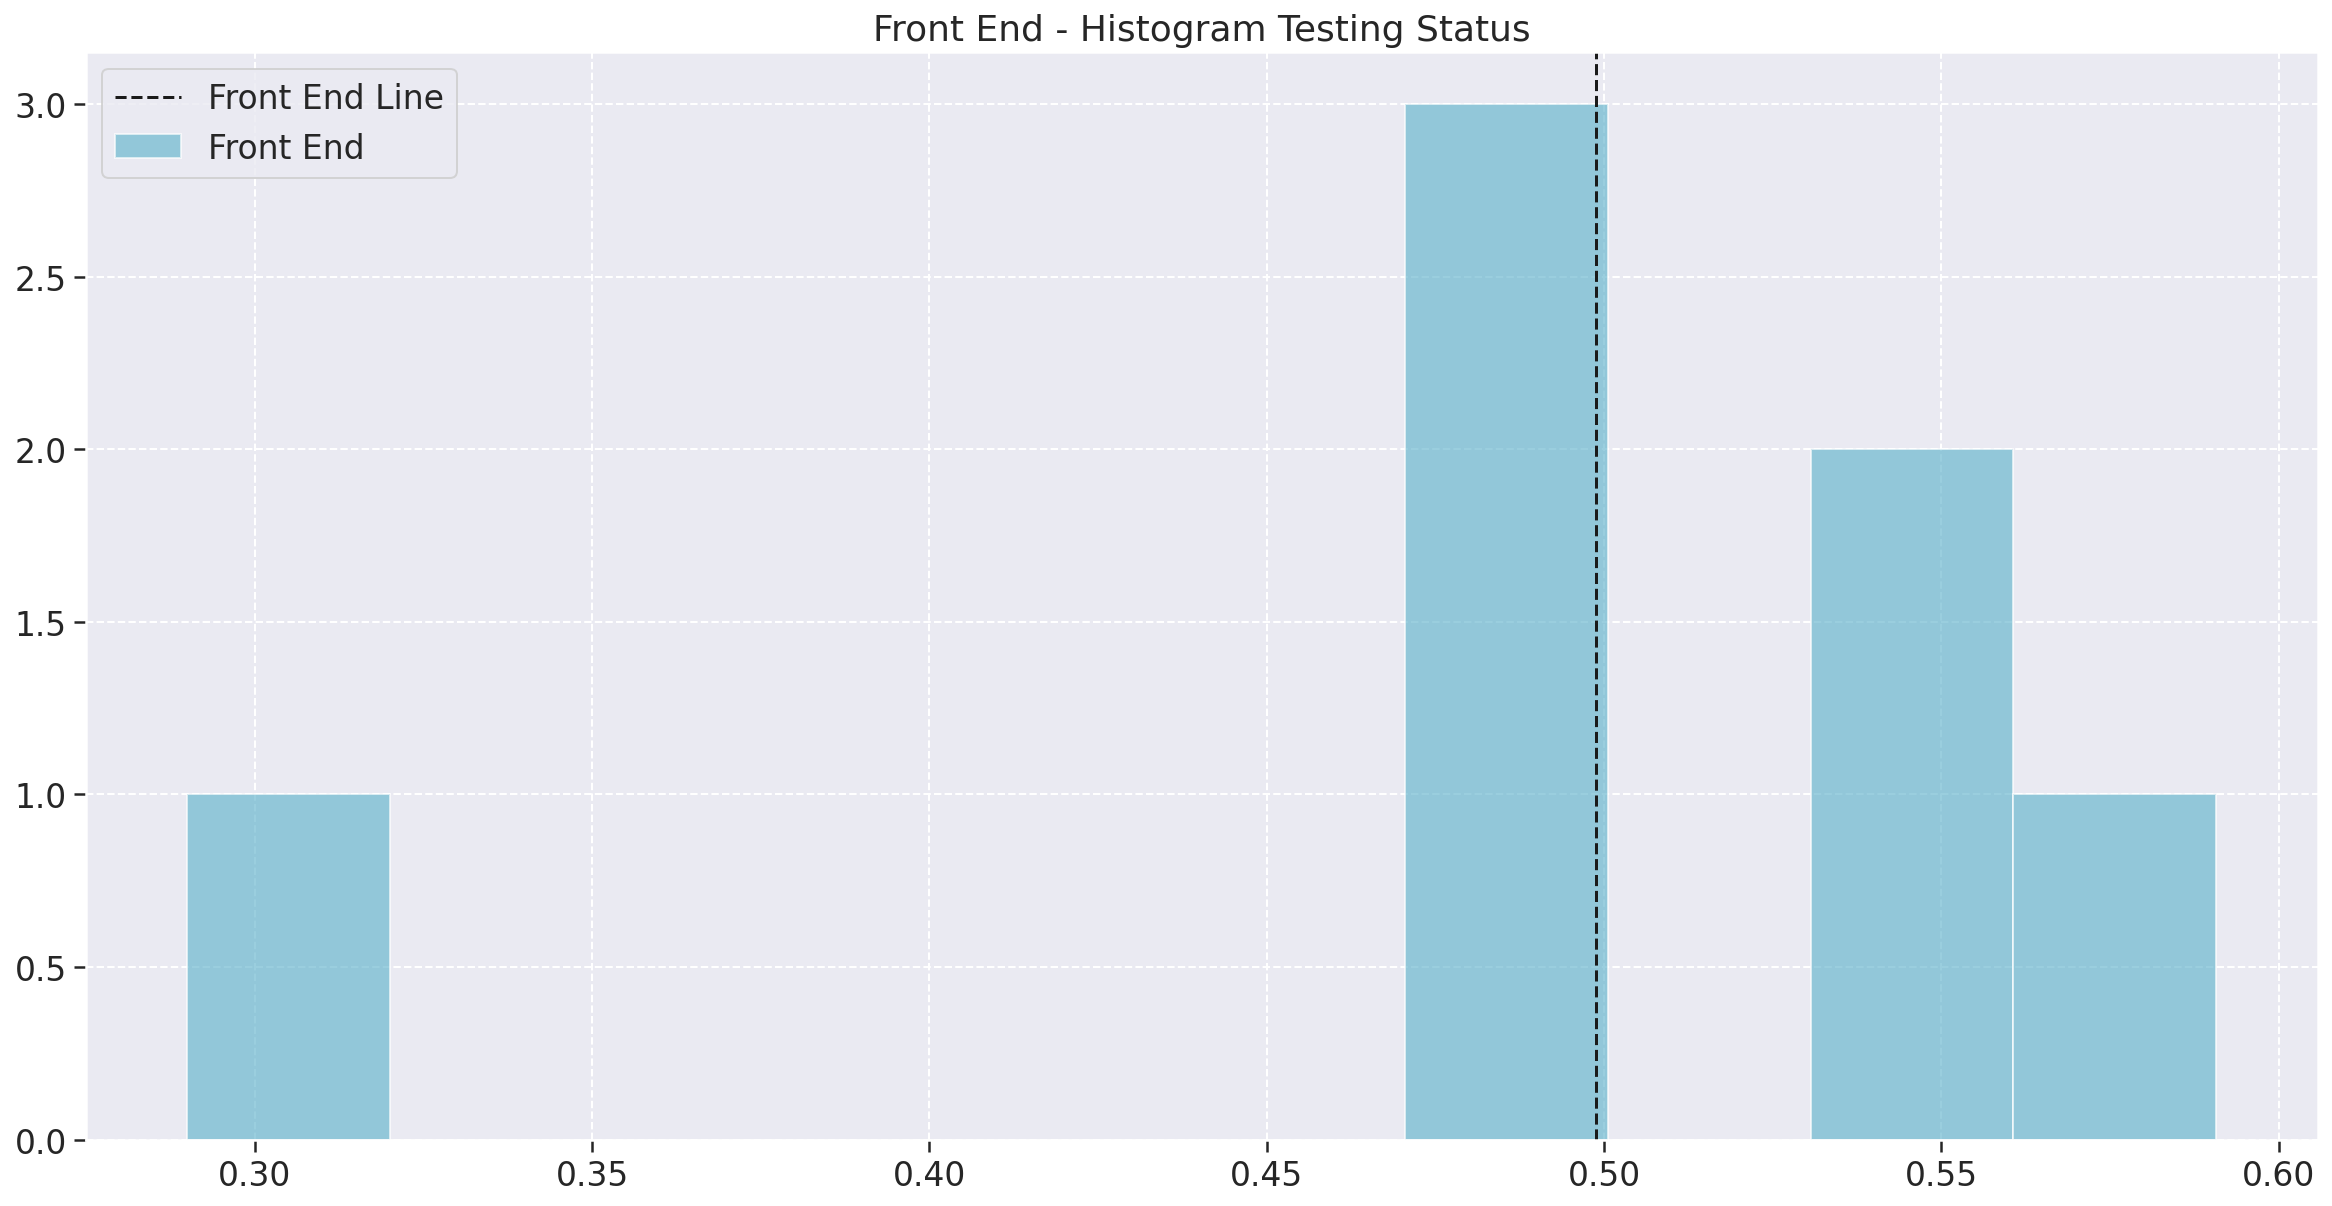

In [47]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End - Histogram Testing Status')
plt.hist(frontend_metrics['testing_status'], bins=10, color='c', alpha=0.65, label='Front End')
plt.axvline(frontend_metrics['testing_status'].mean(), color='k', linestyle='dashed', label='Front End Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ecc135c40>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ecc13f3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ecc1358b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ecc13fac0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ecc13fe50>],
 'means': []}

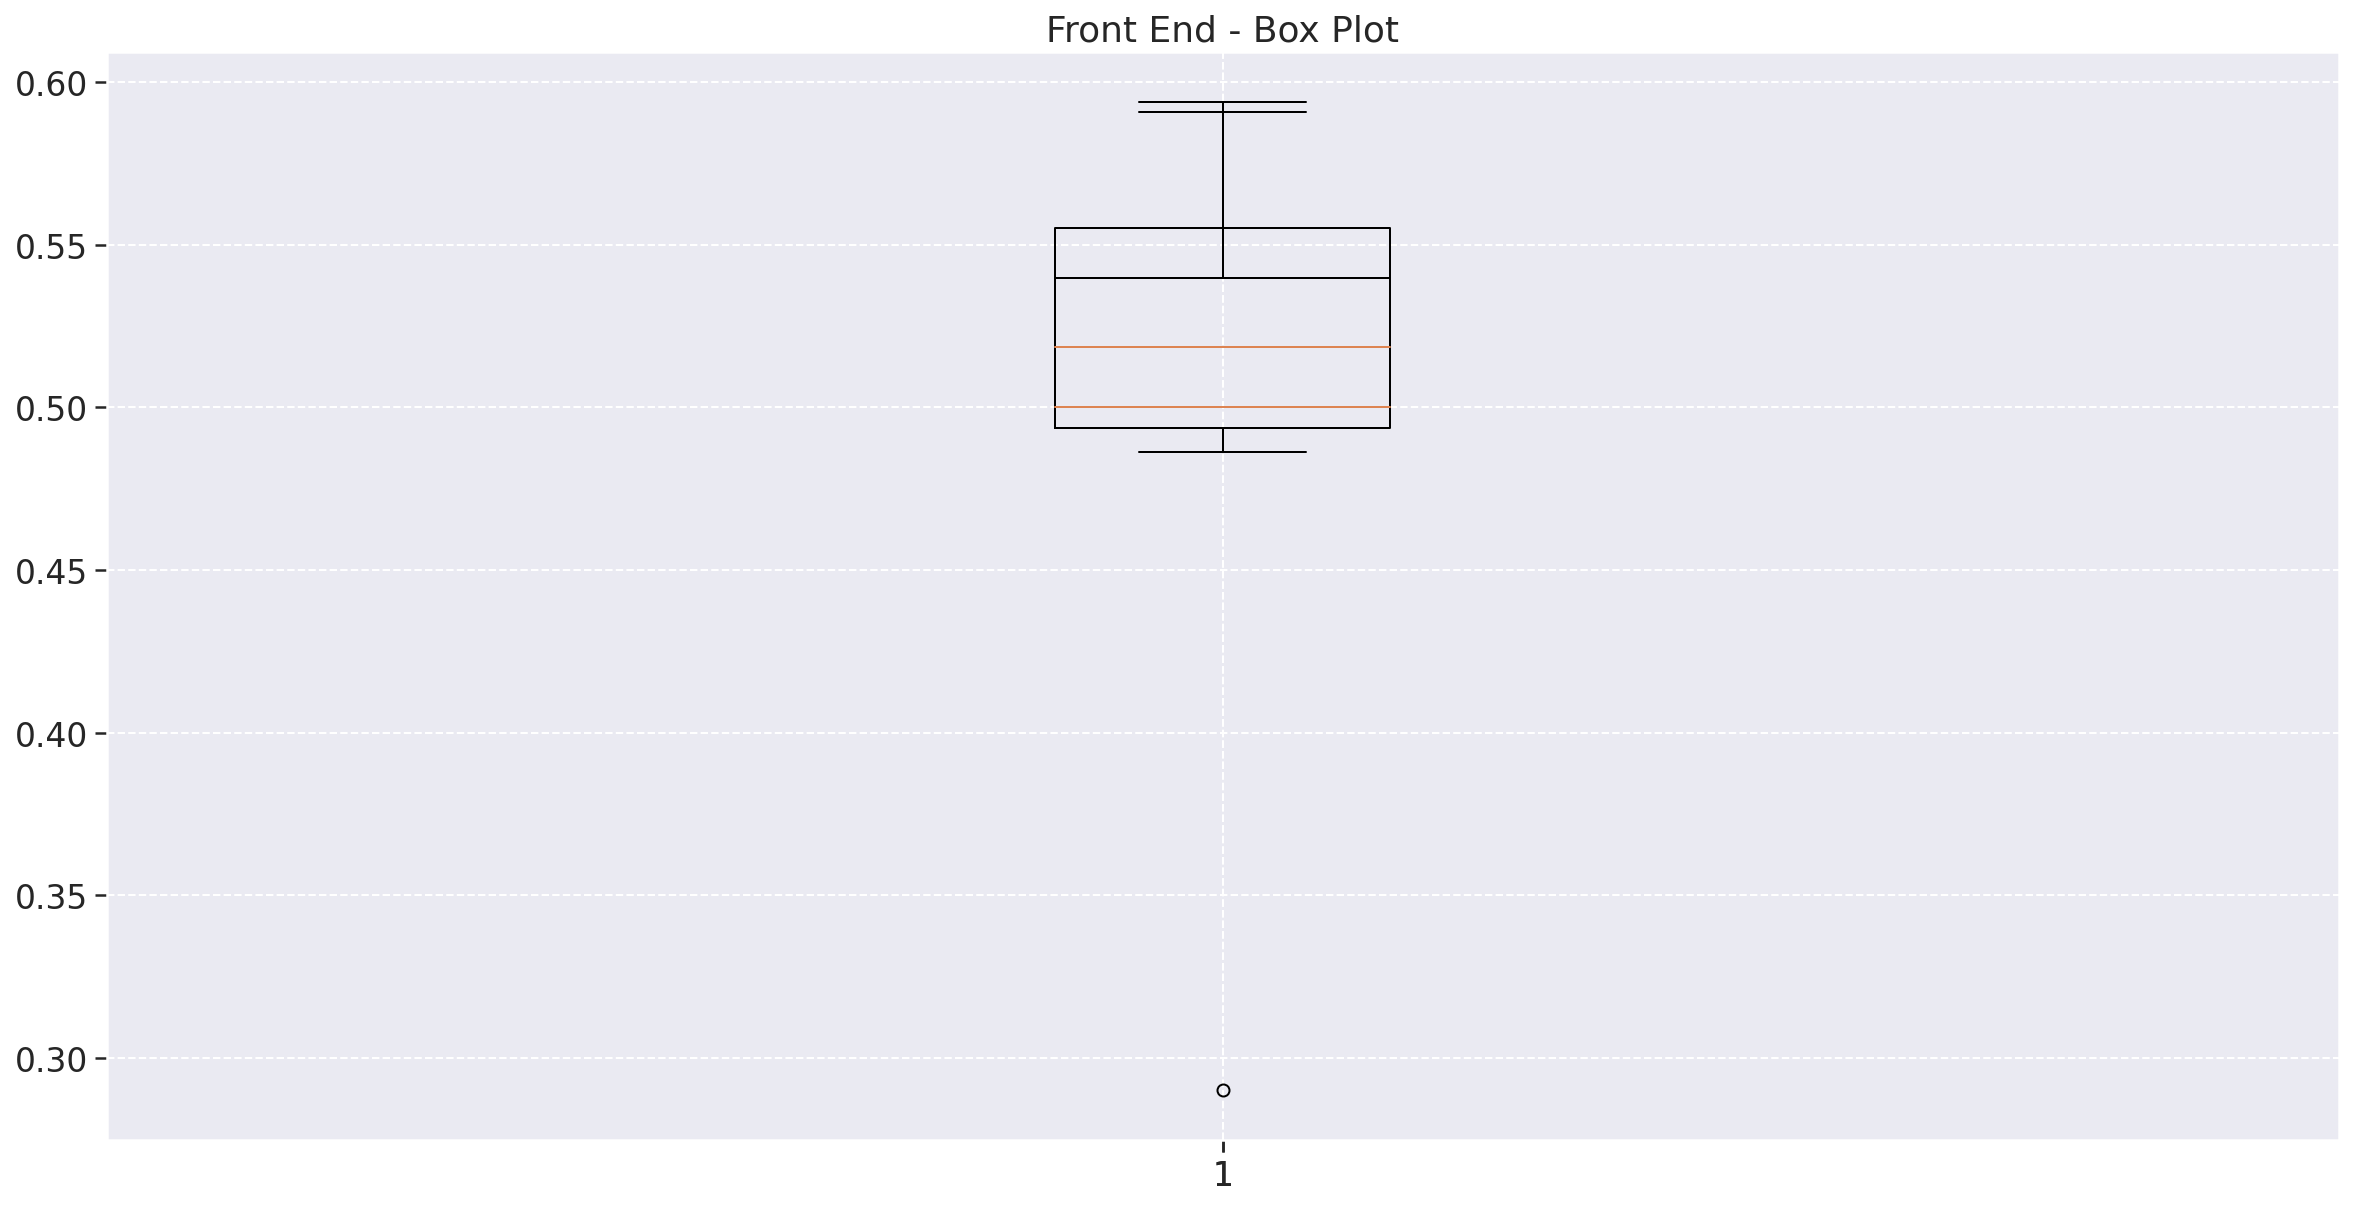

In [48]:
fig = plt.figure(figsize=(20, 10))

plt.title('Front End - Box Plot')
plt.boxplot(frontend_metrics['code_quality'])
plt.boxplot(frontend_metrics['testing_status'])

Text(0.5, 1.0, 'Matriz de Correção - Front End')

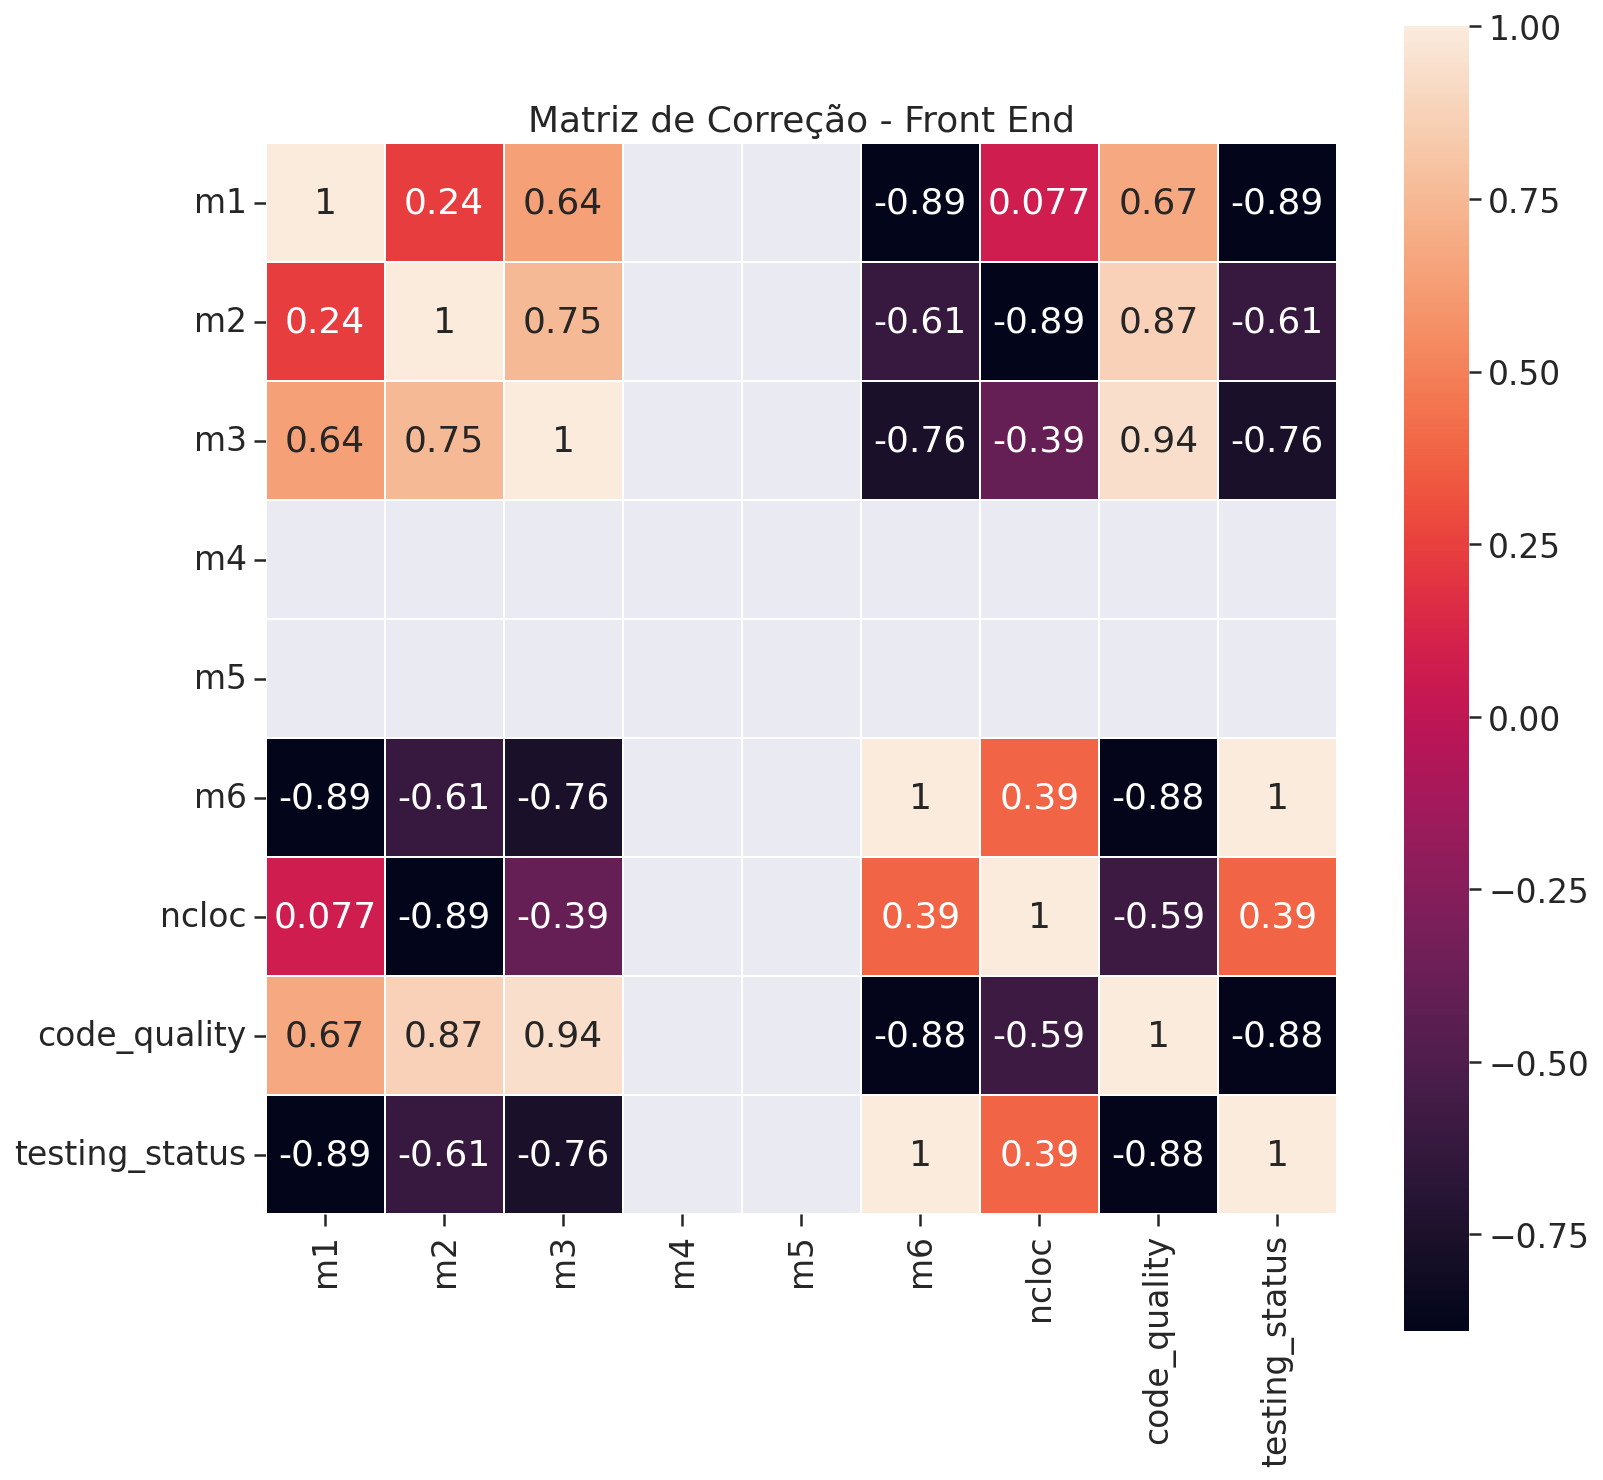

In [49]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(frontend_metrics.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Front End')

### Maintainability and Reliabity

In [50]:
metrics_df = pd.concat([scraper_metrics, documentsapi_metrics, mltraining_metrics, frontend_metrics], ignore_index=True)

metrics_df['maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['maintainability'] + metrics_df['Reliability']

In [51]:
def create_descriptive_df(df):
    maintainability_df = df['maintainability']
    reliability_df = df['Reliability']
    
    descriptive_df = pd.DataFrame(
                columns=['Maintainability', 'Reliability'])
    
    descriptive_df.loc['mean'] = [maintainability_df.mean() * 100, reliability_df.mean()* 100]
    descriptive_df.loc['mode'] = [maintainability_df.mode().max()* 100, reliability_df.mode().max()* 100]
    descriptive_df.loc['25%'] = [maintainability_df.quantile(0.25)* 100, reliability_df.quantile(0.25)* 100]
    descriptive_df.loc['50%'] = [maintainability_df.quantile(0.50)* 100, reliability_df.quantile(0.50)* 100]
    descriptive_df.loc['75%'] = [maintainability_df.quantile(0.75)* 100, reliability_df.quantile(0.75)* 100]
    descriptive_df.loc['standart_deviation'] = [maintainability_df.std()* 100, reliability_df.std()* 100]
    descriptive_df.loc['variance'] = [maintainability_df.var()* 100, reliability_df.var()* 100]
    descriptive_df.loc['min'] = [maintainability_df.min()* 100, reliability_df.min()* 100]
    descriptive_df.loc['max'] = [maintainability_df.max()* 100, reliability_df.max()* 100]
    
    
    return descriptive_df

In [52]:
descriptive_df = create_descriptive_df(metrics_df)

In [53]:
descriptive_df

,Maintainability,Reliability
mean,25.580372,22.485178
mode,33.000000,27.763158
25%,22.000000,21.017241
50%,25.492063,25.921053
75%,26.745608,27.763158
standart_deviation,3.518803,7.946391
variance,0.123820,0.631451
min,21.450000,7.500000
max,33.000000,29.537037


Text(0.5, 1.0, 'Matriz de Correção - Maintainability e Reliability')

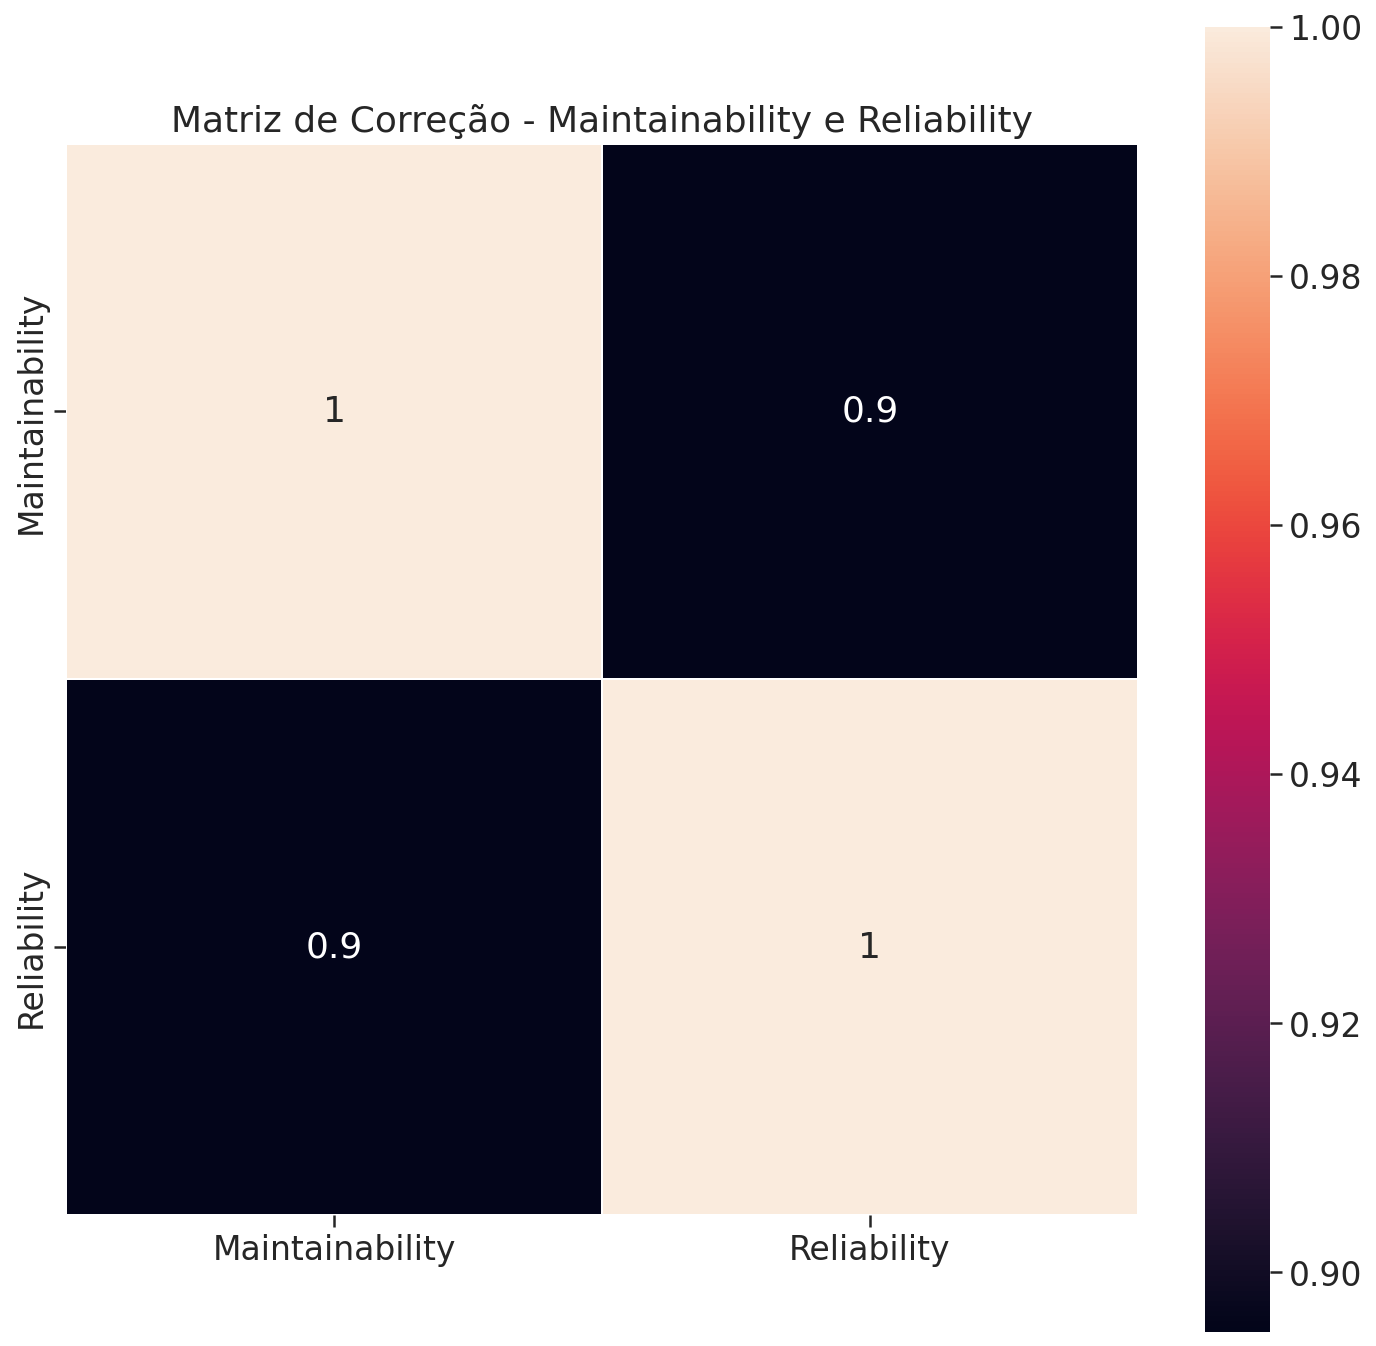

In [54]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(descriptive_df.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção - Maintainability e Reliability')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ec6ee0100>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ec6ee0820>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ec6ecfd30>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9ec6ee0e80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ec6eec250>,
 'means': []}

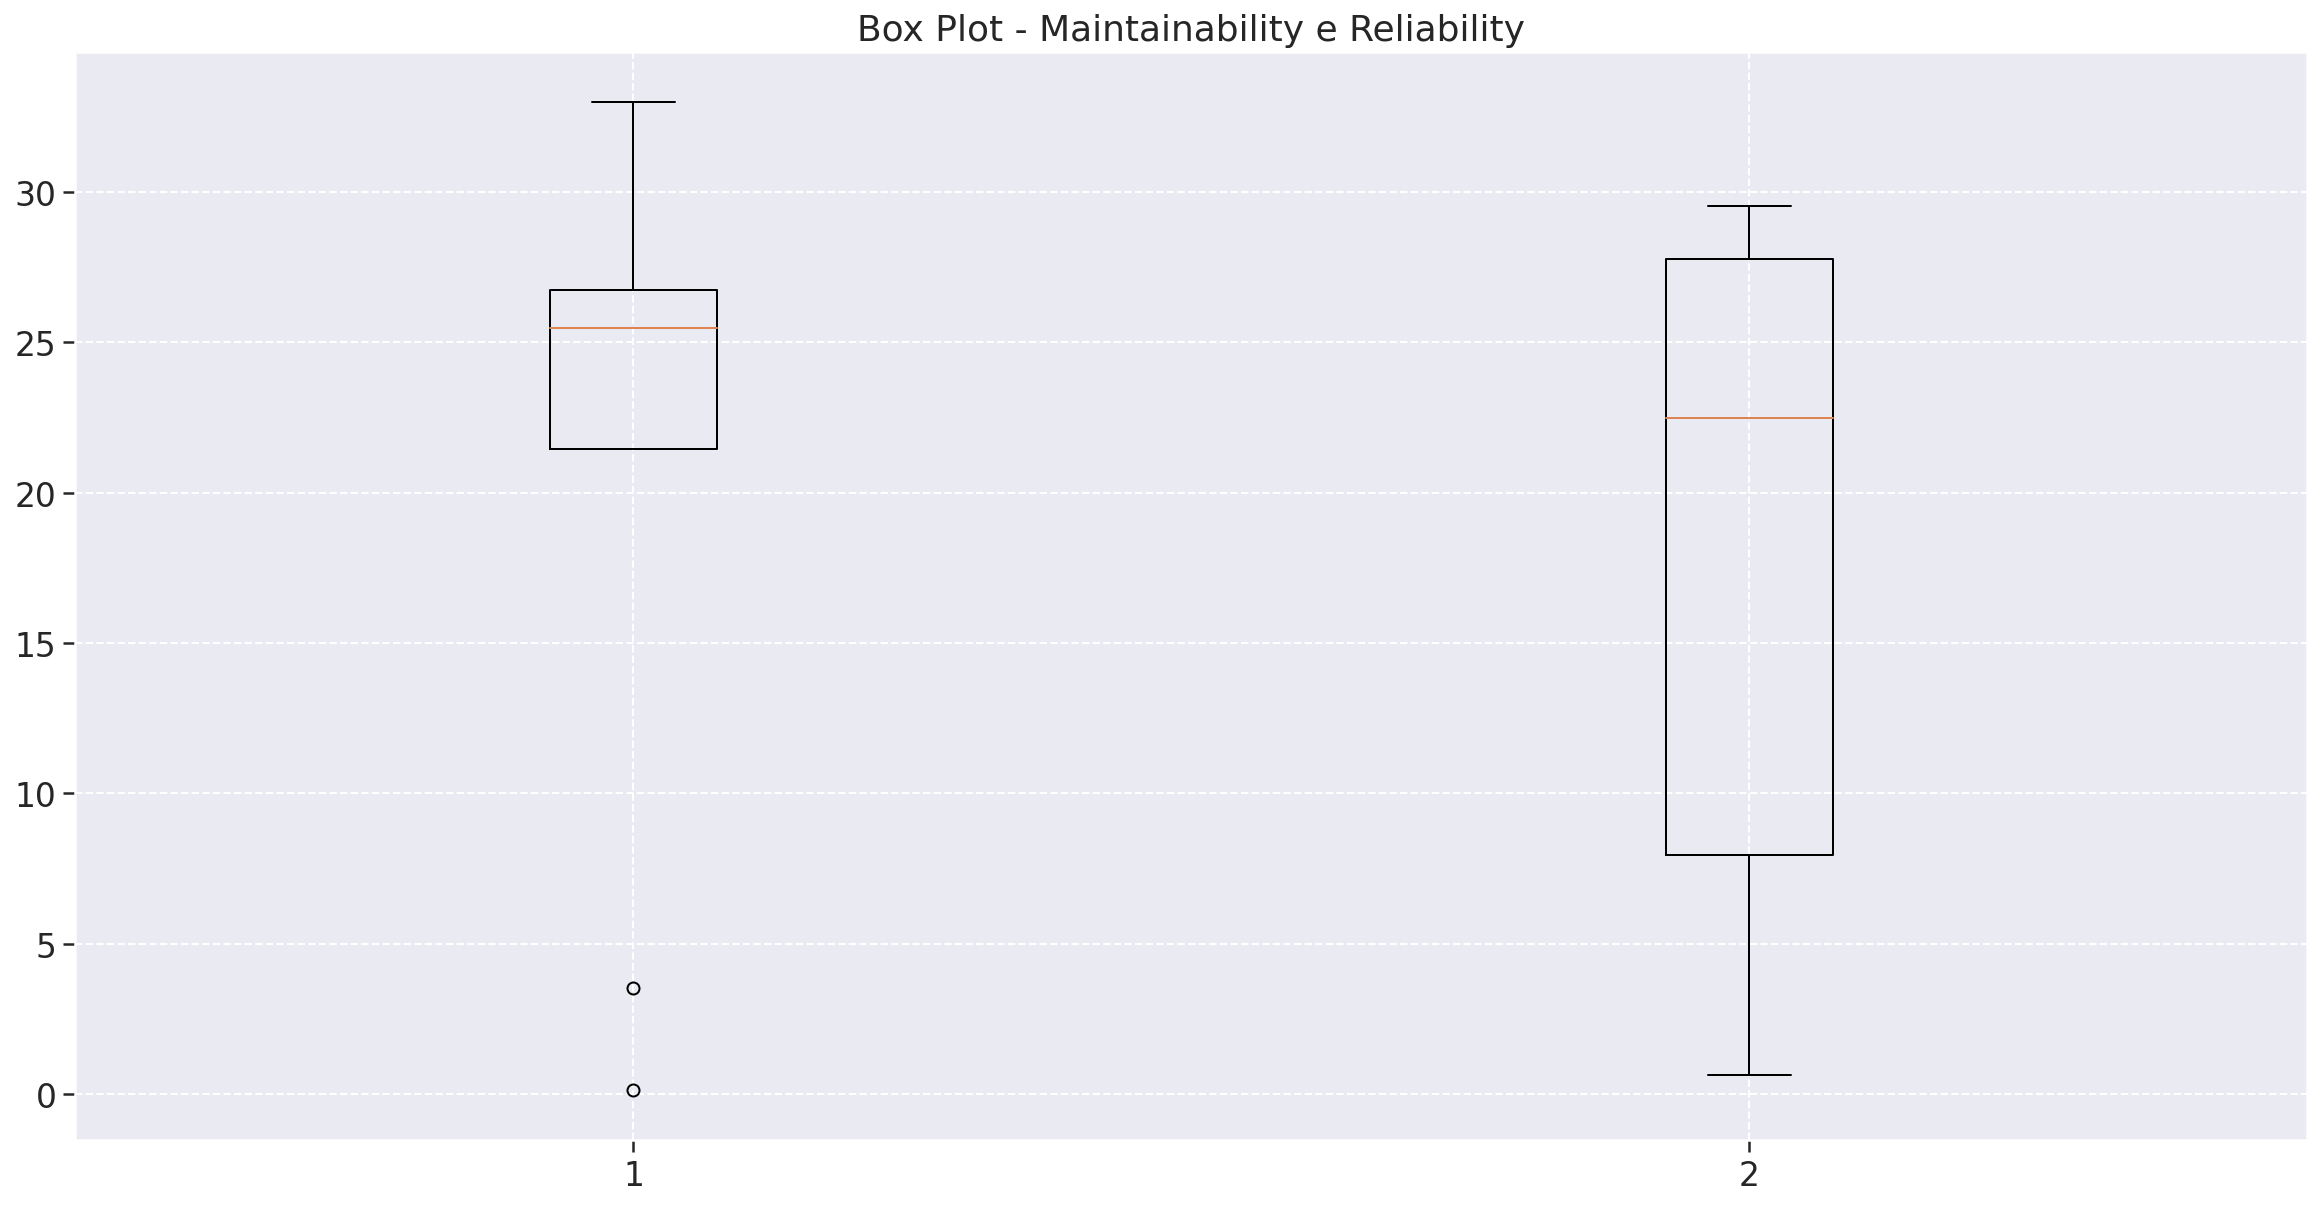

In [55]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Maintainability e Reliability')
plt.boxplot(descriptive_df)

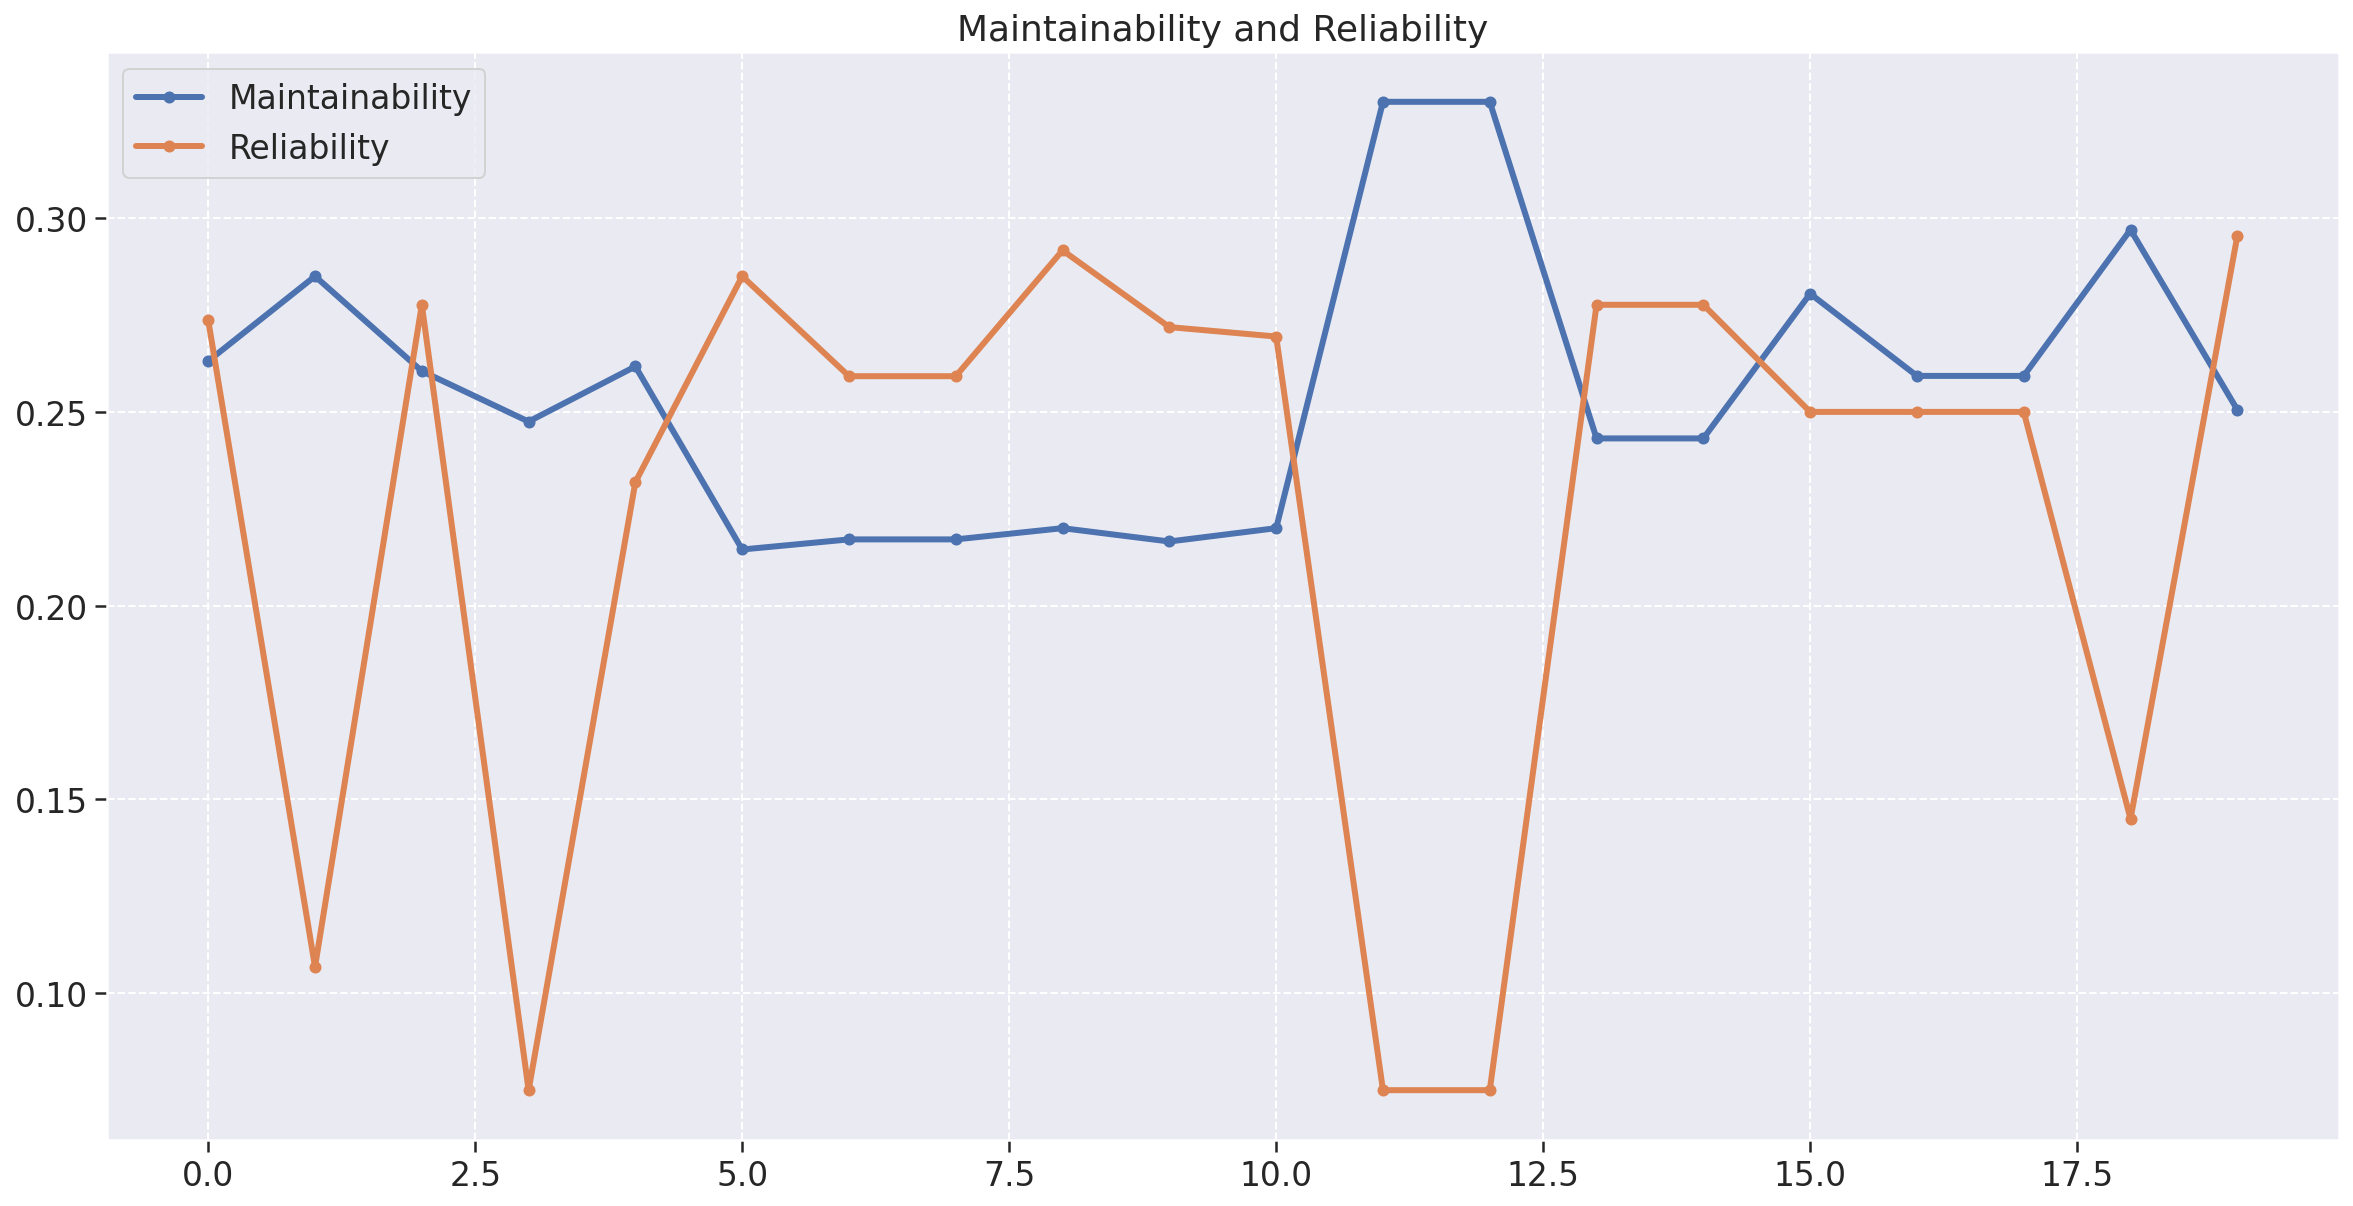

In [56]:
fig = plt.figure(figsize=(20, 10))

plt.title('Maintainability and Reliability')
plt.plot(metrics_df['maintainability'], linewidth=3, marker='o', markersize=5, label='Maintainability')
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5, label='Reliability')

#plt.ylim(.45,.7)
plt.legend(loc='upper left')


{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ec6dd2eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ec6ddf610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ec6dd2c40>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ec6ddfd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ec6dea100>],
 'means': []}

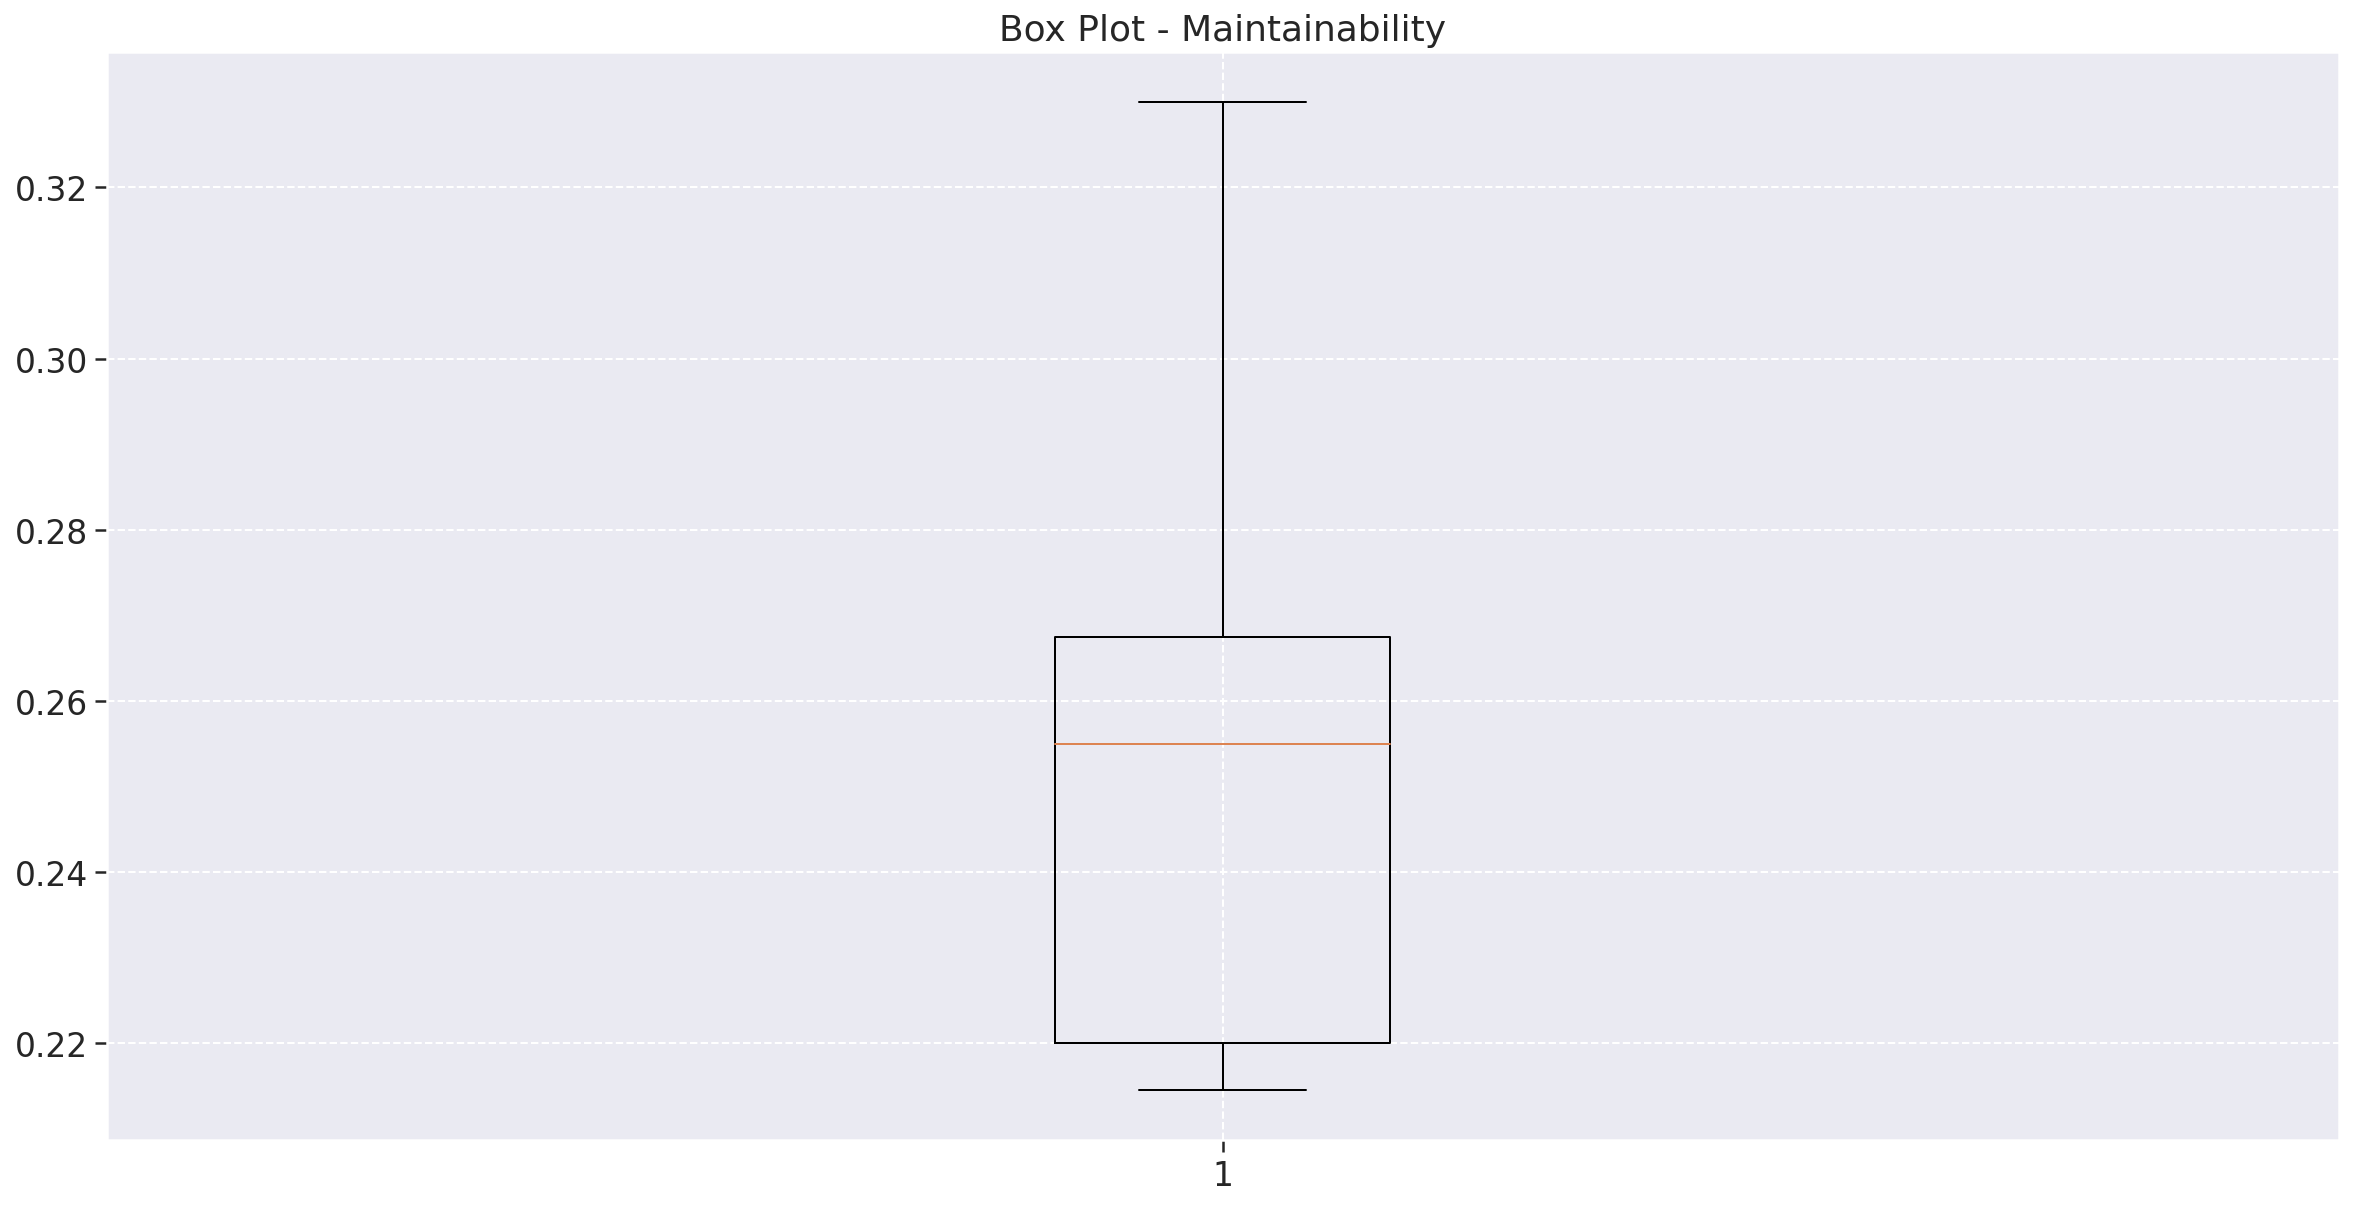

In [57]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Maintainability')
plt.boxplot(metrics_df['maintainability'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ec6dbae80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ec6d485e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ec6dbaaf0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ec6d48d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ec6d560d0>],
 'means': []}

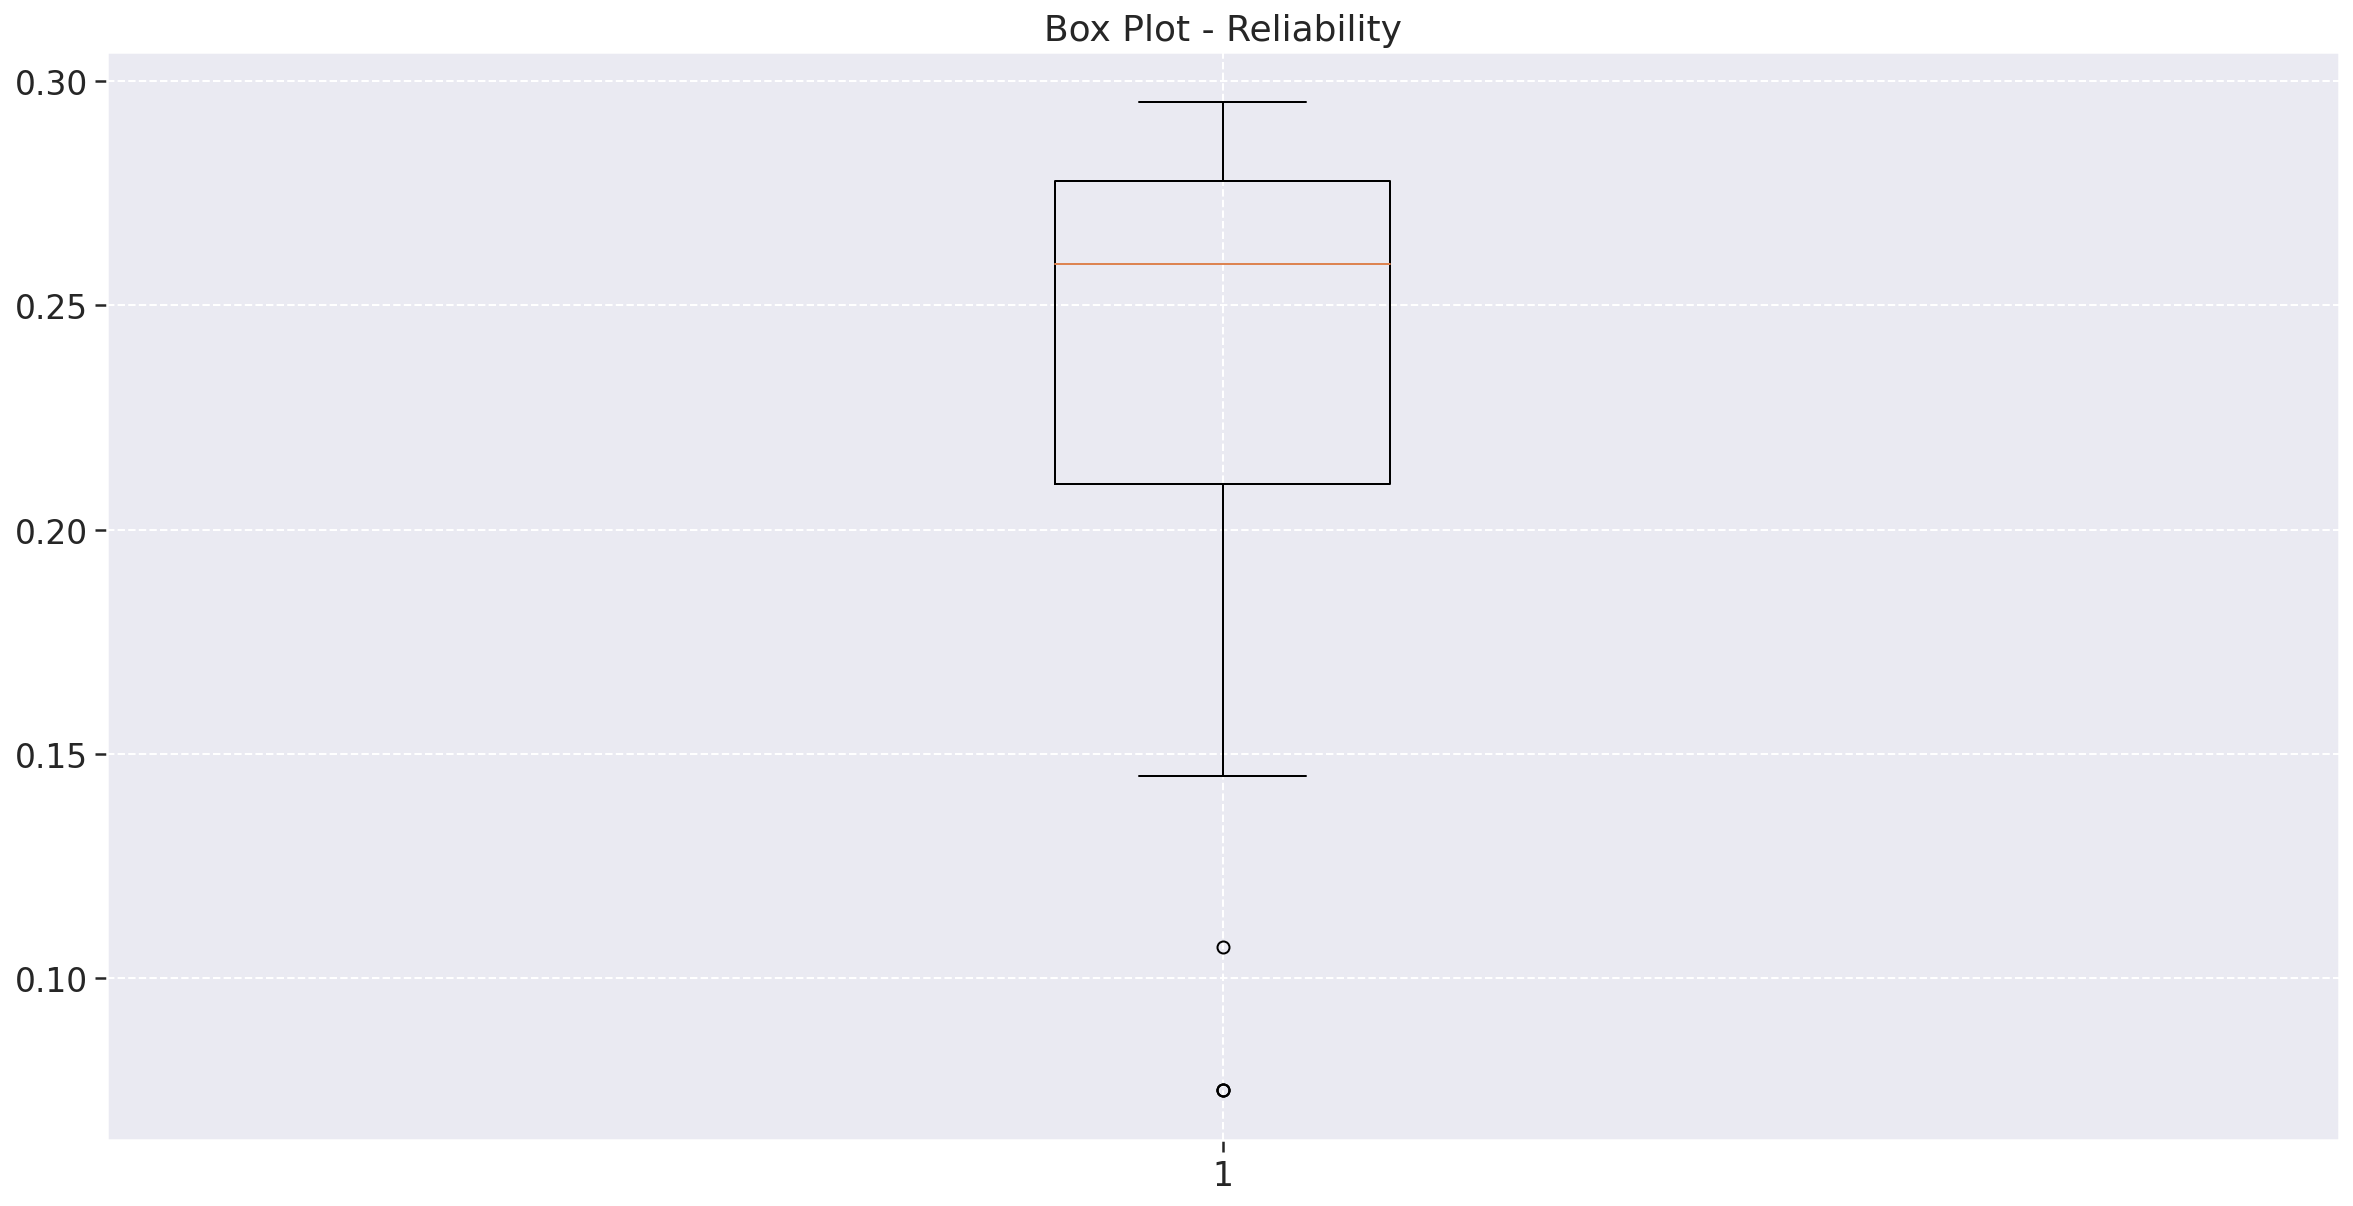

In [58]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Reliability')
plt.boxplot(metrics_df['Reliability'])

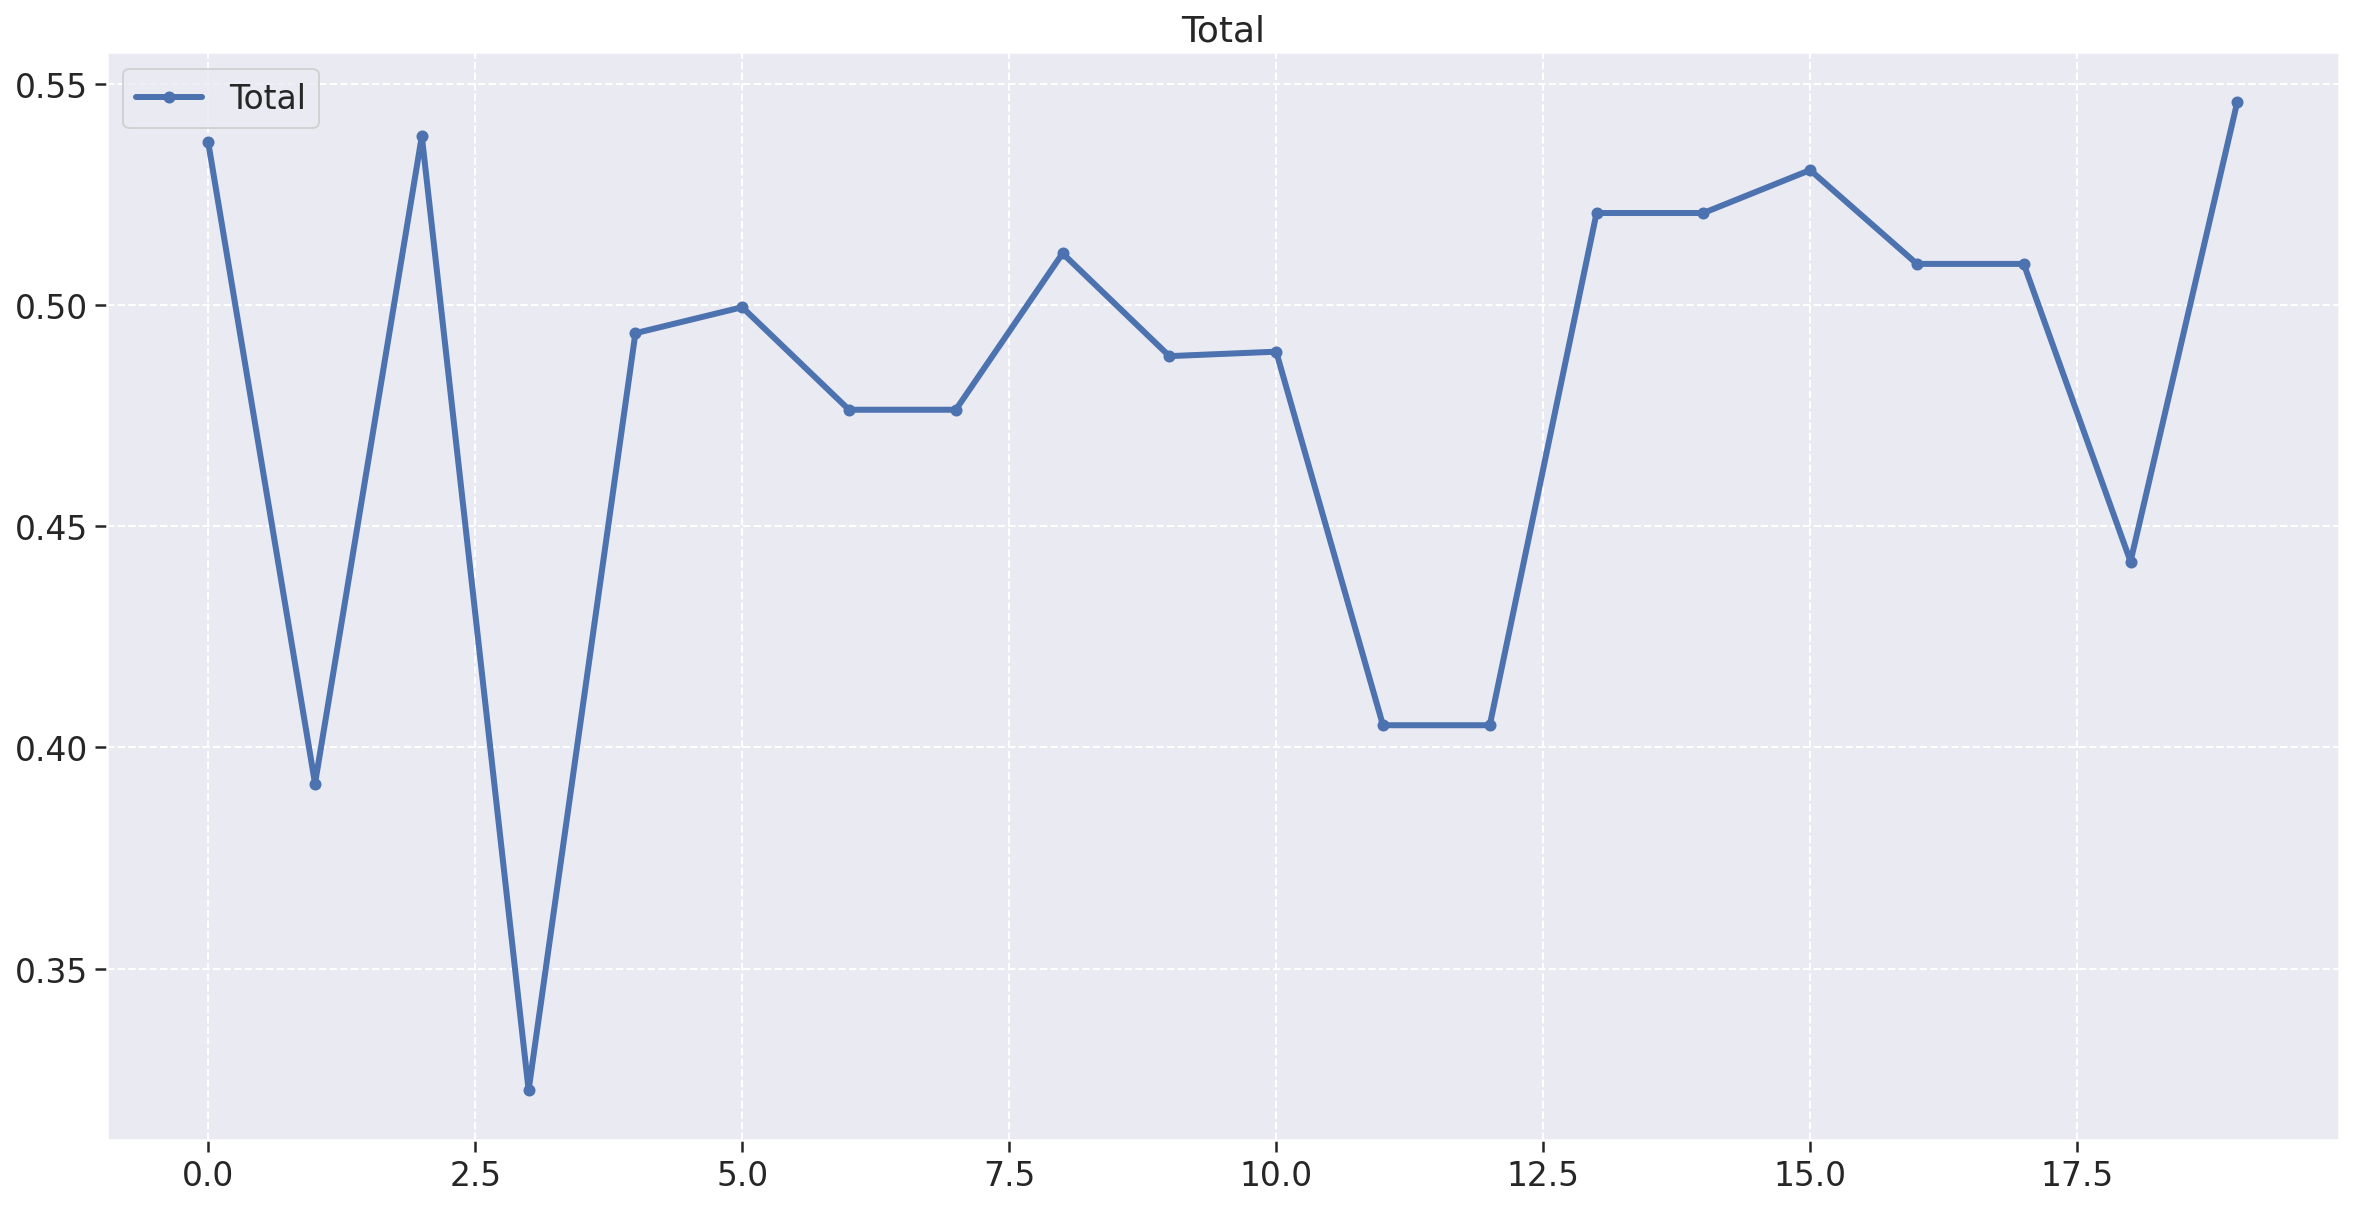

In [59]:
fig = plt.figure(figsize=(20, 10))

plt.title('Total')
plt.plot(metrics_df['total'], linewidth=3, marker='o', markersize=5, label='Total')

plt.legend(loc='upper left')

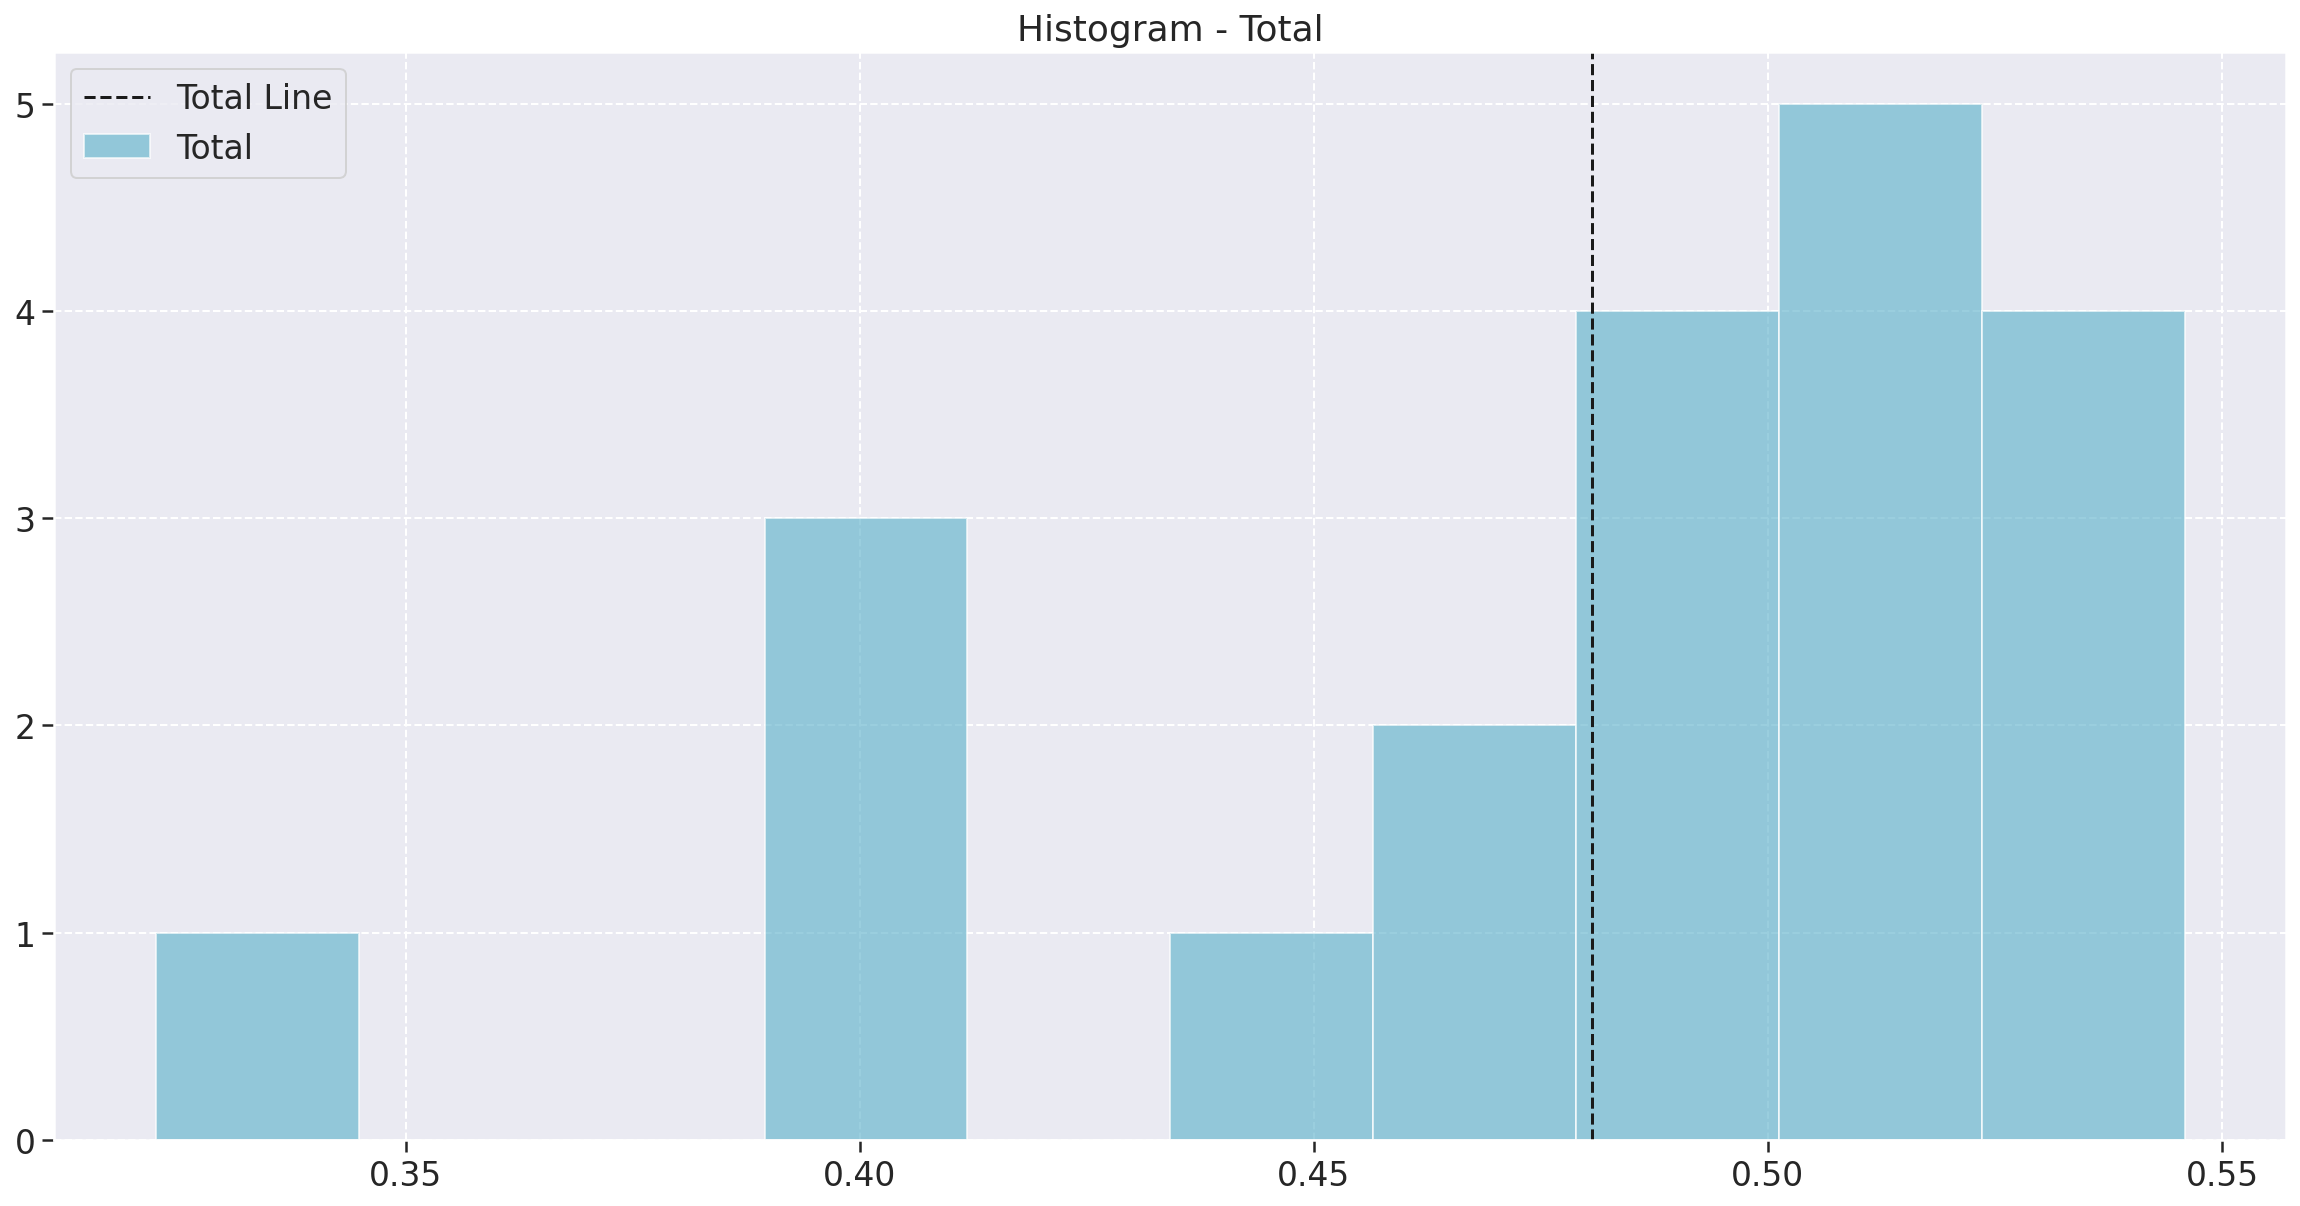

In [60]:
fig = plt.figure(figsize=(20, 10))

plt.title('Histogram - Total')
plt.hist(metrics_df['total'], bins=10, color='c', alpha=0.65, label='Total')
plt.axvline(metrics_df['total'].mean(), color='k', linestyle='dashed', label='Total Line')

plt.legend(loc='upper left')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9ec6c1dc70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9ec6c2a3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9ec6c0f790>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9ec6c2aaf0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9ec6c2ae80>],
 'means': []}

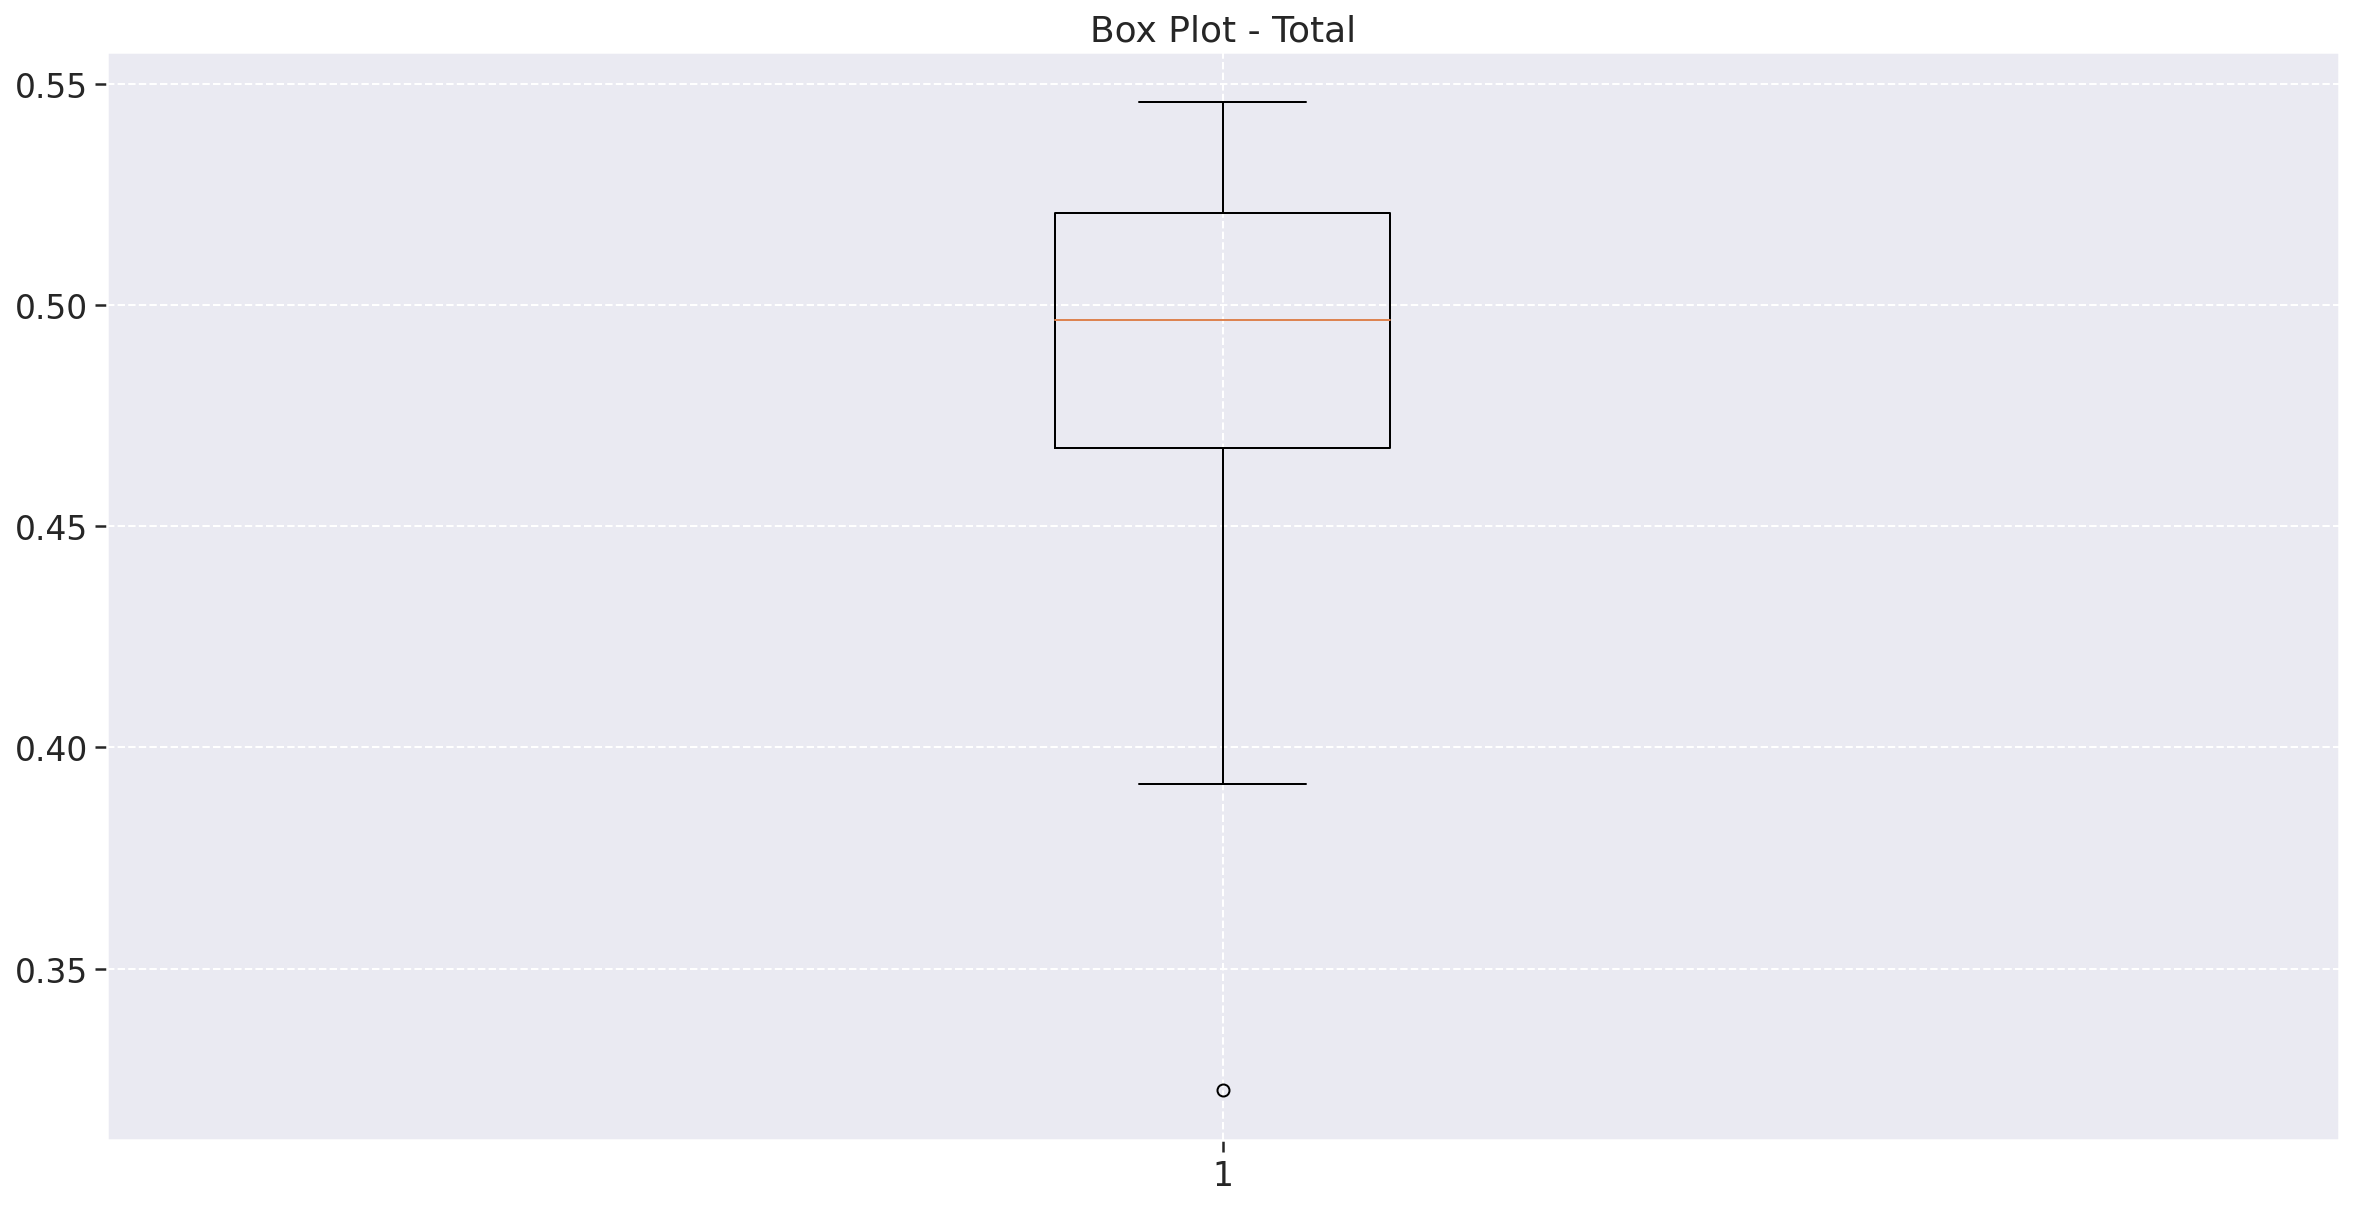

In [61]:
fig = plt.figure(figsize=(20, 10))

plt.title('Box Plot - Total')
plt.boxplot(metrics_df['total'])

Text(0.5, 1.0, 'Matriz de Correção')

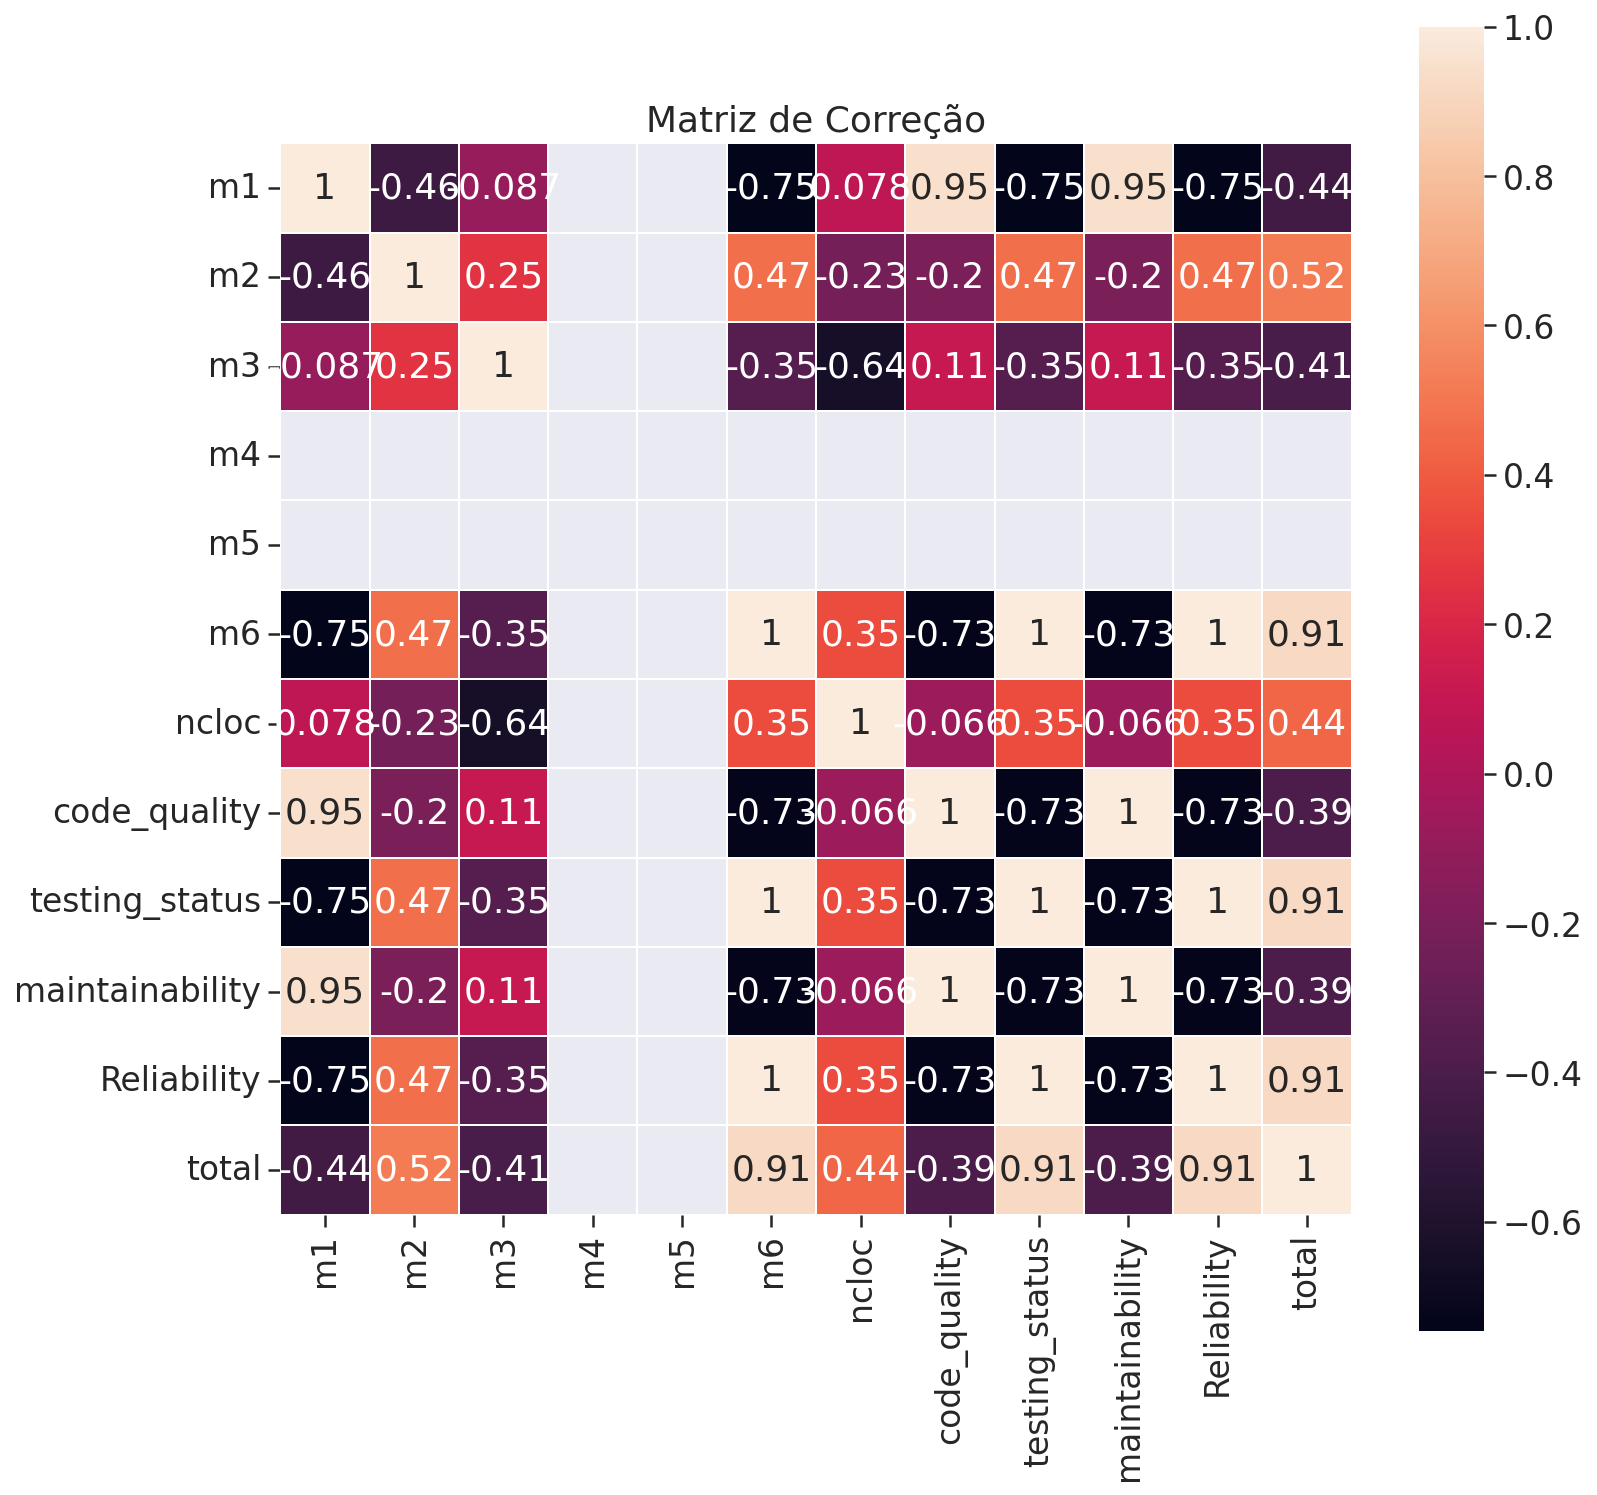

In [62]:
fig = plt.figure(figsize=(12, 12))

ax = plt.axes()
heatmap = sns.heatmap(metrics_df.corr(), square=True, linewidths=1, annot=True, ax = ax)
ax.set_title('Matriz de Correção')

In [63]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,maintainability,Reliability,total
0,0.432432,0.162162,1.000000,1.0,0,0.567568,Scraper,02-11-2021-23-26,1348,0.526216,0.547297,0.263108,0.273649,0.536757
1,0.636364,0.090909,1.000000,1.0,0,0.090909,Scraper,07-10-2021-07-43,484,0.570000,0.213636,0.285000,0.106818,0.391818
2,0.421053,0.157895,1.000000,1.0,0,0.578947,Scraper,07-11-2021-19-54,1337,0.521053,0.555263,0.260526,0.277632,0.538158
3,0.500000,0.000000,1.000000,1.0,0,0.000000,Scraper,15-09-2021-00-01,138,0.495000,0.150000,0.247500,0.075000,0.322500
4,0.482759,0.103448,1.000000,1.0,0,0.448276,Scraper,21-10-2021-15-11,1058,0.523448,0.463793,0.261724,0.231897,0.493621
5,0.200000,0.100000,1.000000,1.0,0,0.600000,DocumentsAPI,02-11-2021-23-35,359,0.429000,0.570000,0.214500,0.285000,0.499500
6,0.210526,0.105263,1.000000,1.0,0,0.526316,DocumentsAPI,07-10-2021-07-31,336,0.434211,0.518421,0.217105,0.259211,0.476316
7,0.210526,0.105263,1.000000,1.0,0,0.526316,DocumentsAPI,07-10-2021-12-28,341,0.434211,0.518421,0.217105,0.259211,0.476316
8,0.238095,0.095238,1.000000,1.0,0,0.619048,DocumentsAPI,07-11-2021-18-29,482,0.440000,0.583333,0.220000,0.291667,0.511667
9,0.187500,0.125000,1.000000,1.0,0,0.562500,DocumentsAPI,15-09-2021-00-24,289,0.433125,0.543750,0.216562,0.271875,0.488437


### Análise

Observando-se todas a métricas apresentadas, pode se concluir que com os valores são bem abaixo do esperado, diante de tomadas de decisões, tais como prioridades a serem realizadas, como consequência, houve uma enorme carência relacionado aos testes nos demais projetos, foi realizado testes apenas nos projetos: Documents API e no Scraper.

Com o gráfico de Confiabilidade e Manutenibilidade, os valores estão basicamente se opondo um ao outro. Tais dados pode se ver claramente por questões de impactos ocorridos diante ao seu desenvolvimento do projeto. Tais como decisões tomadas, problemas relacionados ao time também, como saídas de alguns integrantes (ocorrendo uma carência para desenvolvimento maior), curva de aprendizados, desafios diante ao desenvolvimento e outras circunstâncias.

Pode se reparar diante aos valores do Reliability com a sua depedência referente aos testes, tais como teste de unidades, testes de execução e dentre outros, há um gráfico não constante e bem abaixo do esperado. Contudo visando o futuro e as melhorias, então há uma dependência para implementações de testes, em todos os projetos e visando o 100% diante do coverage.

Com o Maintainalibity, também se encontra com valores abaixo do esperado, tais como valores podem ser solucionados com a ajuda do SonarQube, tais como qualidade de código, complexidades, comentários, duplicações de códigos e dentre outros. Pode se ver que na última linha do gráfico, foi visto um ganho maior, visando valores melhores para ser atingindos. 

In [64]:
# ANALYSIS_DATE FORMAT: YYYY-MM-DD
currentTime = datetime.datetime.now().strftime("%Y-%m-%d")

metrics_df.to_excel('./data/fga-eps-mds-2021_1-PCTs-DATASET-{}.xlsx'.format(currentTime), index = False)
metrics_df.to_csv('./data/fga-eps-mds-2021_1-PCTs-DATASET-{}.csv'.format(currentTime), index = False)